# Next Instruction Prediction Training


In [1]:
import torch

torch.cuda.is_available()
#!/usr/bin/env python3

import sys,os
from elftools.elf.elffile import ELFFile
from elftools.elf.segments import Segment
from capstone import *
from capstone.x86 import *

import os
import json 

import sys,os
device = 'cuda:1' if torch.cuda.is_available() else 'cpu'


# DATASET GENERATION

# Creating the pipeline

In [2]:
from transformers import BertTokenizer, BertForNextSentencePrediction,BertForPreTraining
import torch
from transformers import PreTrainedTokenizerFast
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

tokenizer = PreTrainedTokenizerFast.from_pretrained("./../models/cusTokenizer")
print(tokenizer.pad_token) 
# model = BertForNextSentencePrediction.from_pretrained('bert-base-uncased')
model = BertForPreTraining.from_pretrained('bert-base-uncased')
MAX_TOKEN_LEN = 512
BATCH_SIZE = 256 +128


[PAD]


In [3]:
DATA_PATH = "/home/raisul/ANALYSED_DATA/mlm_x86_O2_d4_single_functions"

json_files = [os.path.join(DATA_PATH, f) for f in os.listdir(DATA_PATH) ]



def get_training_corpus():

    all = []

    for k, j_file in enumerate(json_files):
        if k>20000:
            break
        try:
            with open(j_file, 'r') as file:
                funct = file.read()
                funct = '\n'.join([line.split('|')[1] for line in funct.split('\n')[:-1]])    
                all.append(funct)
        except :
            pass
    # all.sort(key=len)
    return all
    
  

text = get_training_corpus()

# text = text[0:5000]
print("Functions Count: ",len(text), '\n')
example = text[10]


Functions Count:  20001 



In [4]:
print(text[-1])


ENDBR64
PUSH RBP
LEA RSI,[8196]
MOV EDI,2
LEA RBP,[8217]
PUSH RBX
MOV EBX,1
SUB RSP,24
MOV RAX,qword ptr FS:[40]
MOV qword ptr [RSP + 8],RAX
XOR EAX,EAX
CALL 4224
LEA RDX,[RSP + 4]
MOV RSI,RSP
XOR EAX,EAX
LEA RDI,[8211]
CALL 4240
MOV ECX,dword ptr [RSP + 4]
MOV EDX,EBX
MOV RSI,RBP
MOV EDI,2
XOR EAX,EAX
SHL EDX,CL
OR EDX,dword ptr [RSP]
CALL 4224
MOV ECX,dword ptr [RSP + 4]
MOV EDX,EBX
MOV RSI,RBP
MOV EDI,2
XOR EAX,EAX
SHL EDX,CL
NOT EDX
AND EDX,dword ptr [RSP]
CALL 4224
MOV ECX,dword ptr [RSP + 4]
MOV EDX,dword ptr [RSP]
XOR EAX,EAX
MOV RSI,RBP
MOV EDI,2
SHL EBX,CL
XOR EDX,EBX
CALL 4224
MOV RAX,qword ptr [RSP + 8]
SUB RAX,qword ptr FS:[40]
JNZ 4438
ADD RSP,24
XOR EAX,EAX
POP RBX
POP RBP
RET
CALL 4208


In [5]:
# text[51].split(delim)

We'll assign a 50% probability of using the genuine next sentence, and 50% probability of using another random sentence.

To make this simpler, we'll create a *'bag'* of individual sentences to pull from when selecting a random sentence B.

In [6]:
delim = '\n'
bag = [instruction for instruction_cluster in text for instruction in instruction_cluster.split(delim)  if instruction!= '']
bag_size = len(bag)
print(bag_size)

1028376


And now we create our 50/50 NIP training data.

In [7]:
import random

history = []
next_instruction = []
label = []

page_len = 5
instruction_pages = []
for instruction_cluster in text:
    instructions = [
        instruction for instruction in instruction_cluster.split(delim) if instruction != ''
    ]
    if len(instructions)>page_len:
        
        for i in range(0,len(instructions),page_len):
            instruction_pages.append(instructions[i:i+page_len])
        
print(len(instruction_pages))
print(instruction_pages[0])

for instruction_page in instruction_pages:
    
#     instructions = [
#         instruction for instruction in instruction_page.split(';') if instruction != ''
#     ]
    
    
#     num_instructions = len(instruction_page)
    
    

#     start = random.randint(0, num_instructions-2)
    # 50/50 whether is IsNextSentence or NotNextSentence
    if random.random() >= 0.5:
        # this is IsNextSentence
        history.append(delim.join(instruction_page[:-1]))
        next_instruction.append(instruction_page[-1])
        label.append(0)
    else:
        index = random.randint(0, bag_size-1)
        # this is NotNextSentence
        history.append(delim.join(instruction_page[:-1]))
        next_instruction.append(bag[index])
        label.append(1)

213191
['ENDBR64', 'PUSH RBX', 'LEA RBX,[8616]', 'MOV RDI,RBX', 'SUB RSP,16']


In [8]:
print(len(label))
for i in range(3):
    print(label[i])
    print('->',history[i] , '\n')
    print('# ',next_instruction[i] , '\n')

213191
1
-> ENDBR64
PUSH RBX
LEA RBX,[8616]
MOV RDI,RBX 

#  ENDBR64 

1
-> MOV RAX,qword ptr FS:[40]
MOV qword ptr [RSP + 8],RAX
XOR EAX,EAX
CALL 4320 

#  MOV qword ptr [RSP + 8],RAX 

1
-> CALL 4320
LEA RSI,[8283]
MOV EDI,2
XOR EAX,EAX 

#  MOV R9,qword ptr [RDX + 8] 



Our data is now ready for tokenization, this time we truncate/pad each token to the same length of *512* tokens.

In [9]:
inputs = tokenizer(history, next_instruction, return_tensors='pt', 
                   max_length=MAX_TOKEN_LEN, truncation=True, padding=True)
ground_truth = inputs.copy() 

In [10]:
inputs.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

We can see that the *token_type_ids* tensors have been built correctly (eg **1** indicating sentence B tokens) by checking the first instance of *token_type_ids*:

In [11]:
print(inputs.input_ids.shape)
inputs.token_type_ids[0]

torch.Size([213191, 74])


tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0])

The **0** tokens following our sentence B tokens correspond to *PAD* tokens.

Alongside this, we need to create a *labels* tensor too - which corresponds to the values contained within our `label` variable. Our *labels* tensor must be a *LongTensor*, and we will need to transpose the tensor so that it matches our other tensors' dimensionality.

In [12]:
inputs['next_sentence_label'] = torch.LongTensor([label]).T


And the labels tensor is simply a clone of the input_ids tensor before masking.

In [13]:
inputs['labels'] = inputs.input_ids.detach().clone()

In [14]:
inputs.input_ids[-1]

tensor([  2,   3, 105, 232,   3,   1,   1,   1,   1,   1,   1,   1,   1,   1,
          1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
          1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
          1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
          1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
          1,   1,   1,   1])

Now we mask tokens in the input_ids tensor using the 15% probability for MLM - ensuring we don't mask CLS, SEP, or PAD tokens.

In [15]:
# create random array of floats with equal dimensions to input_ids tensor
rand = torch.rand(inputs.input_ids.shape)
# create mask array
mask_arr = (rand < 0.15) * (inputs.input_ids != 101) * \
           (inputs.input_ids != 102) * (inputs.input_ids != 0)

In [16]:
mask_arr.shape
# inputs.input_ids.shape[0]

torch.Size([213191, 74])

And now take the indices of each True value within each vector.

In [17]:
selection = []

for i in range(inputs.input_ids.shape[0]):
    selection.append(
        torch.flatten(mask_arr[i].nonzero()).tolist()
    )

In [18]:
len (selection) , len(inputs.input_ids), selection[0:3]

(213191,
 213191,
 [[17, 18, 39, 65, 69, 73],
  [1, 7, 23, 26, 45, 67, 70, 71],
  [0, 21, 33, 36, 44, 50, 52, 57, 61, 63, 73]])

Then apply these indices to each row in input_ids, assigning each value at these indices a value of 103.

In [19]:
inputs.input_ids[0][selection[0]]

tensor([1, 1, 1, 1, 1, 1])

In [20]:
masked_labels = []
for i in range(inputs.input_ids.shape[0]):
    masked_labels.append(inputs.input_ids[i, selection[i]])
    inputs.input_ids[i, selection[i]] = 103
# masked_labels[0]
inputs["mask_arr"] = mask_arr

In [21]:
inputs.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'next_sentence_label', 'labels', 'mask_arr'])

The `inputs` tensors are now ready, and we can begin building the model input pipeline for training. We first create a PyTorch dataset from our data.

In [22]:
class MeditationsDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings
    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
    def __len__(self):
        return len(self.encodings.input_ids)

Initialize our data using the `MeditationDataset` class.

In [23]:
dataset = MeditationsDataset(inputs)

In [24]:
train_size = int(0.8 * len(dataset))
validation_size = len(dataset) - train_size

train_dataset  = torch.utils.data.Subset(dataset, range(train_size))
validation_dataset = torch.utils.data.Subset(dataset, range(train_size , len(dataset)))

train_size, len(train_dataset) , len(validation_dataset)

(170552, 170552, 42639)

And initialize the dataloader, which we'll be using to load our data into the model during training.

In [25]:

train_loader      = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=True )

In [26]:
# 

Now we can move onto setting up the training loop. First we setup GPU/CPU usage.

In [27]:

# and move our model over to the selected device
model.to(device)

BertForPreTraining(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

Activate the training mode of our model, and initialize our optimizer (Adam with weighted decay - reduces chance of overfitting).

In [28]:
from sklearn.metrics import precision_recall_fscore_support , accuracy_score
import numpy as np


Now we can move onto the training loop, we'll train for a couple of epochs (change `epochs` to modify this).

In [29]:
# odict_keys(['loss', 'prediction_logits', 'seq_relationship_logits'])

In [30]:

from numpy import *
import math
import matplotlib.pyplot as plt


def plot_graph(training_data, validation_data , label ):

    font_size = 10
    x_labels = [ i for i in range(len(training_data)) ]

    plt.ylabel(' F1 ',fontsize=font_size)
    plt.plot(x_labels, training_data , 'r') 
    plt.plot(x_labels, validation_data , 'b') 
    plt.xlabel("Epoch", fontsize=font_size)
    plt.title(label,fontsize=font_size)
    plt.legend(['Training', 'Validation'], loc='upper left') 
    
    plt.savefig('./../results/'+label+'.pdf')
    plt.show()



/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 0: 100%|██████████| 445/445 [06:55<00:00,  1.07it/s, loss=2.76]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to c

Training:   Instruction f1:  0.5370498122050305   Masked Token f1 0.5297418422963251     SEQ F1 0.5239435544835765


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:40<00:00,  2.77it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation:  Instruction F1:  0.6716915041673834    v_masked_token_ F1:  0.5414952207593636  V SEQ F1:  0.5349067616825978


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


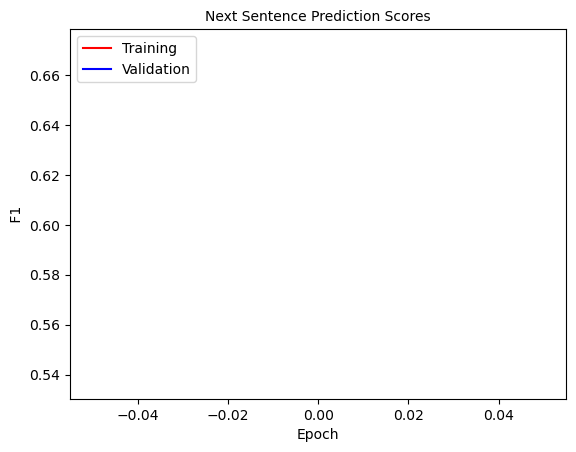

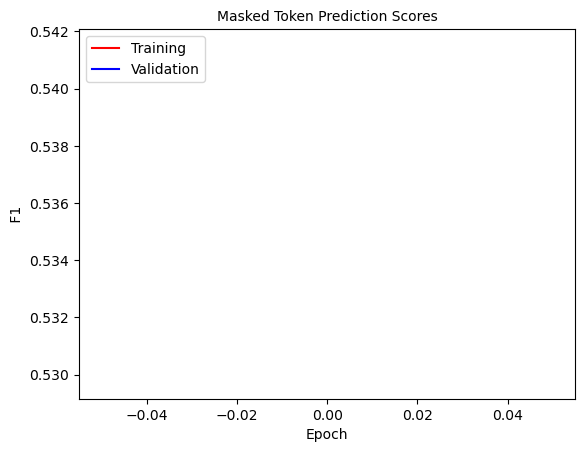

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 1: 100%|██████████| 445/445 [07:02<00:00,  1.05it/s, loss=2.15]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to c

Training:   Instruction f1:  0.5456838457447101   Masked Token f1 0.5528186801958874     SEQ F1 0.5637127357463816


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:40<00:00,  2.79it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior

Validation:  Instruction F1:  0.6727884909703091    v_masked_token_ F1:  0.6694328153367282  V SEQ F1:  0.6738316364193916


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


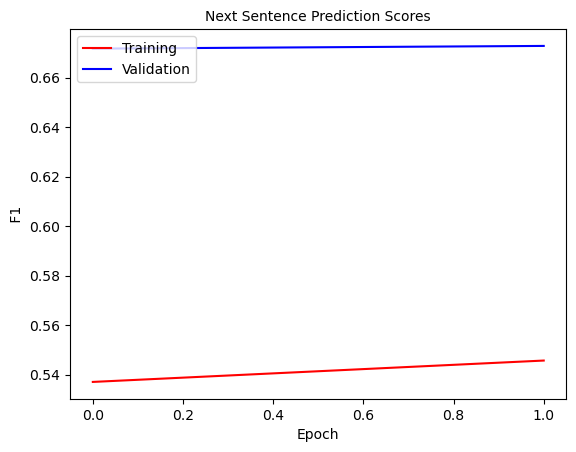

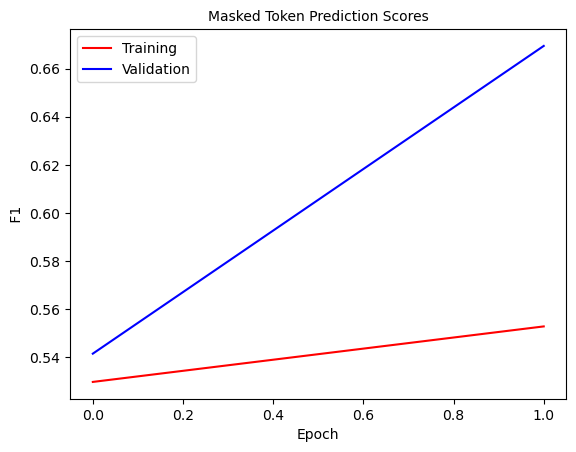

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 2: 100%|██████████| 445/445 [07:02<00:00,  1.05it/s, loss=1.98]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to c

Training:   Instruction f1:  0.5543186740430689   Masked Token f1 0.6735810267002857     SEQ F1 0.6871409906962267


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:40<00:00,  2.76it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior

Validation:  Instruction F1:  0.5483611158567837    v_masked_token_ F1:  0.6994300949539408  V SEQ F1:  0.7093462334584617


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


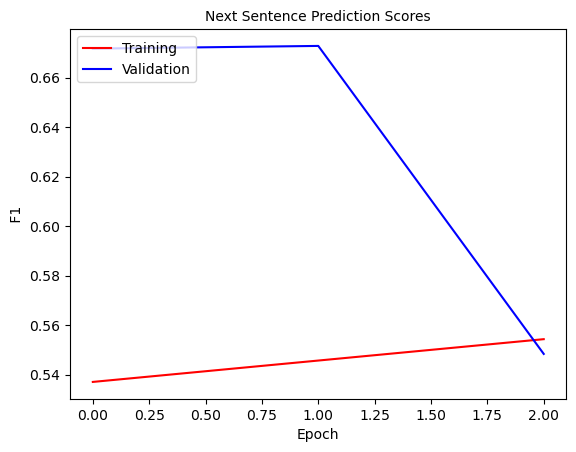

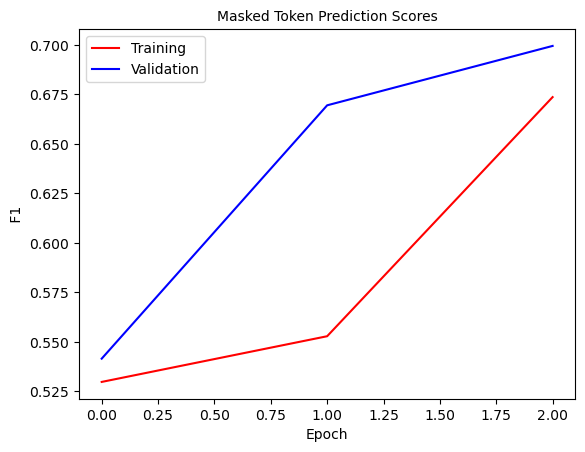

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 3: 100%|██████████| 445/445 [07:04<00:00,  1.05it/s, loss=1.74]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to c

Training:   Instruction f1:  0.5733367407786012   Masked Token f1 0.7049129547240175     SEQ F1 0.7316709455653403


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:40<00:00,  2.77it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior

Validation:  Instruction F1:  0.6193741868618933    v_masked_token_ F1:  0.721144188213965  V SEQ F1:  0.7876253218922159


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


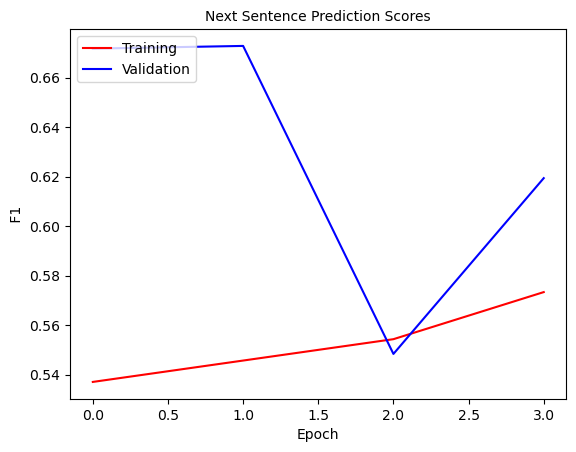

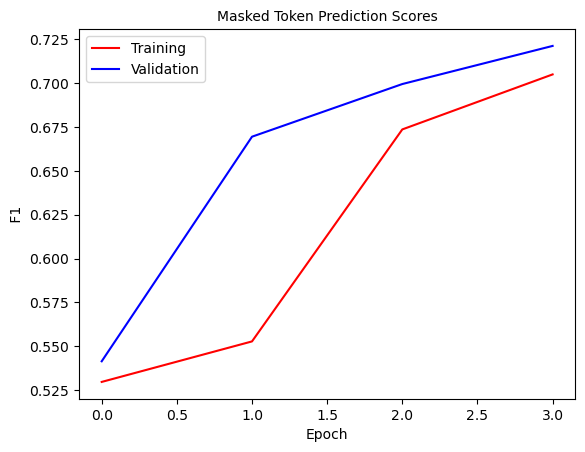

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 4: 100%|██████████| 445/445 [07:03<00:00,  1.05it/s, loss=1.2] 
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to c

Training:   Instruction f1:  0.5951738260343463   Masked Token f1 0.7240522974888886     SEQ F1 0.8600726110330131


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:40<00:00,  2.77it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior

Validation:  Instruction F1:  0.6961760865510166    v_masked_token_ F1:  0.7469698671189227  V SEQ F1:  0.9205520224227719


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


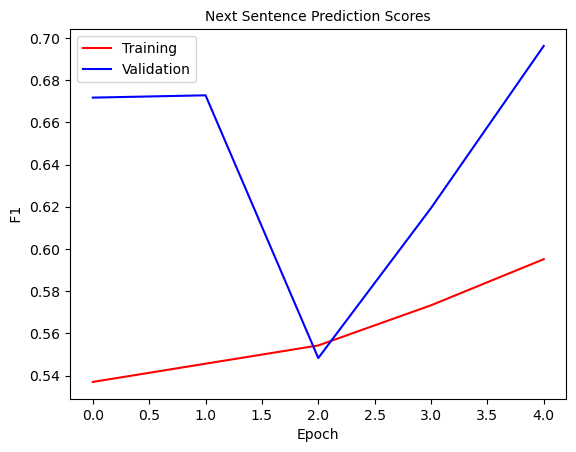

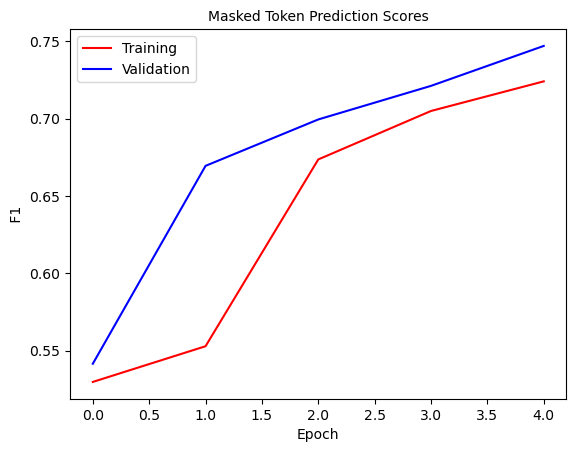

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 5: 100%|██████████| 445/445 [07:05<00:00,  1.05it/s, loss=1.03] 
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to 

Training:   Instruction f1:  0.6303813944350304   Masked Token f1 0.7492343696305848     SEQ F1 0.9212666445145944


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:40<00:00,  2.75it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior

Validation:  Instruction F1:  0.7095494853170536    v_masked_token_ F1:  0.7803292986633488  V SEQ F1:  0.9375368122632034


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


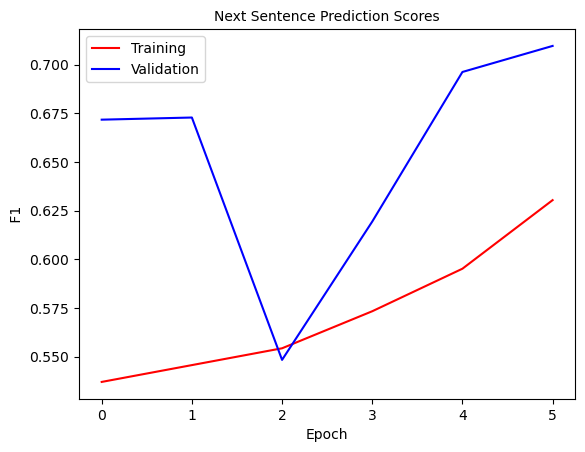

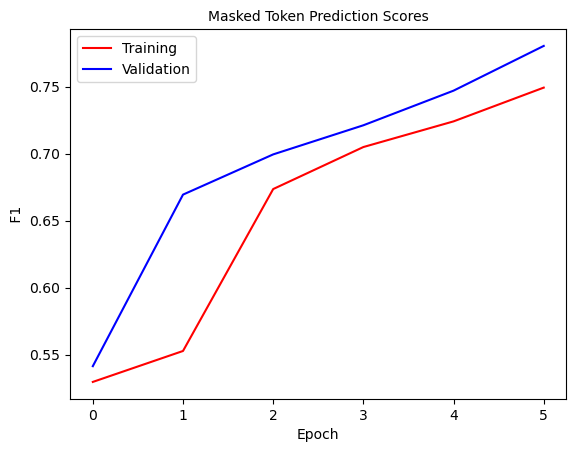

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 6: 100%|██████████| 445/445 [07:08<00:00,  1.04it/s, loss=0.781]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to 

Training:   Instruction f1:  0.6725984183378236   Masked Token f1 0.7765414964050097     SEQ F1 0.9361836799230775


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:40<00:00,  2.74it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior

Validation:  Instruction F1:  0.7300617820479692    v_masked_token_ F1:  0.8038692910160508  V SEQ F1:  0.9476260869605628


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


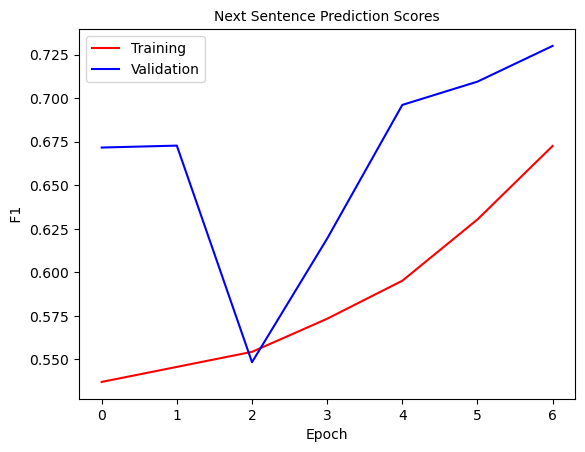

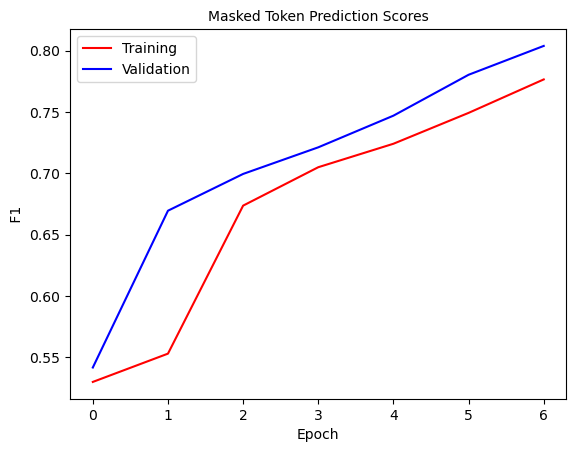

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 7: 100%|██████████| 445/445 [07:05<00:00,  1.05it/s, loss=0.699]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to 

Training:   Instruction f1:  0.7070536970911259   Masked Token f1 0.7969531310084574     SEQ F1 0.9445784795196683


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:40<00:00,  2.76it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior

Validation:  Instruction F1:  0.7268835616438356    v_masked_token_ F1:  0.8188432624334958  V SEQ F1:  0.953419410459528


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


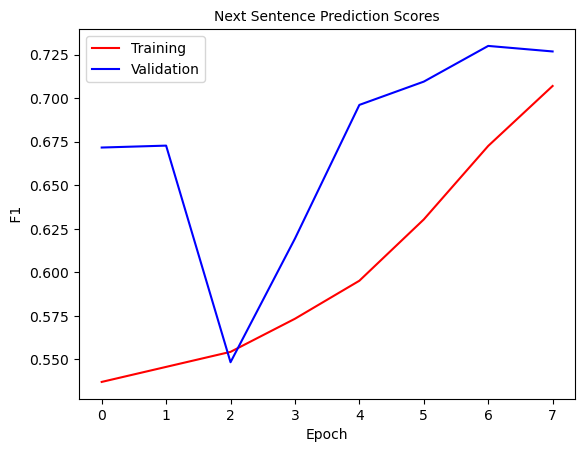

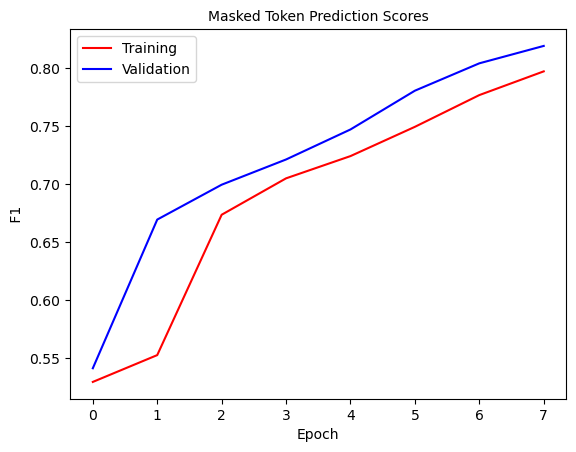

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 8: 100%|██████████| 445/445 [07:04<00:00,  1.05it/s, loss=0.9]  
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to 

Training:   Instruction f1:  0.7317177077754515   Masked Token f1 0.8110089490551167     SEQ F1 0.9499324432914666


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:40<00:00,  2.76it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior

Validation:  Instruction F1:  0.7580891441867229    v_masked_token_ F1:  0.8291877714502279  V SEQ F1:  0.9578753527411357


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


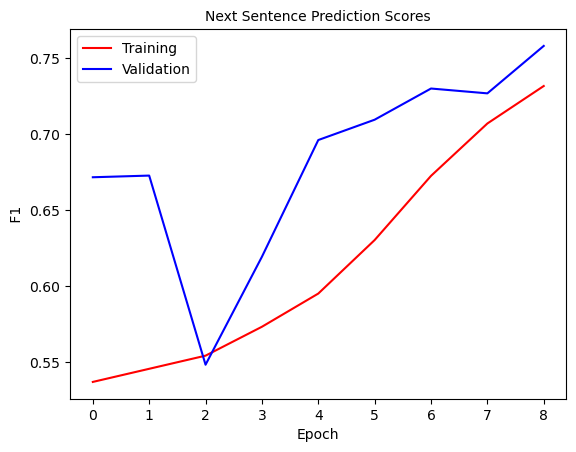

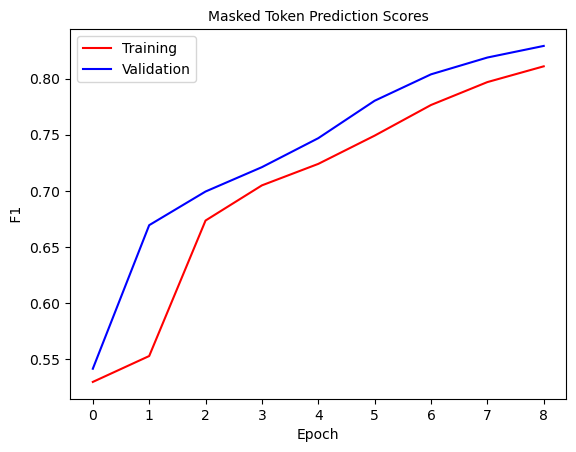

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 9: 100%|██████████| 445/445 [07:04<00:00,  1.05it/s, loss=0.698]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to 

Training:   Instruction f1:  0.7516597222640964   Masked Token f1 0.8219154159493283     SEQ F1 0.9539766304901304


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:40<00:00,  2.77it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior

Validation:  Instruction F1:  0.7624900872323552    v_masked_token_ F1:  0.8391431796434557  V SEQ F1:  0.961157890229176


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


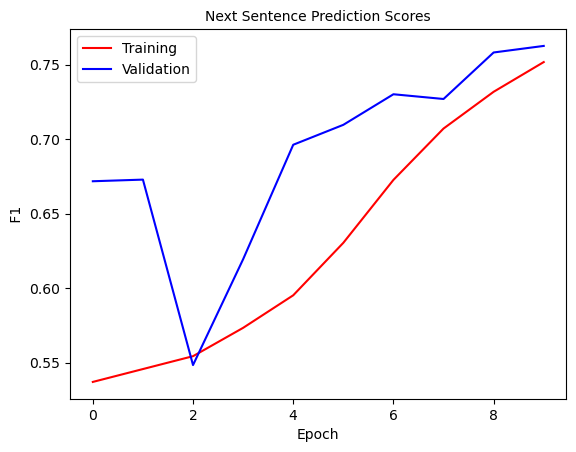

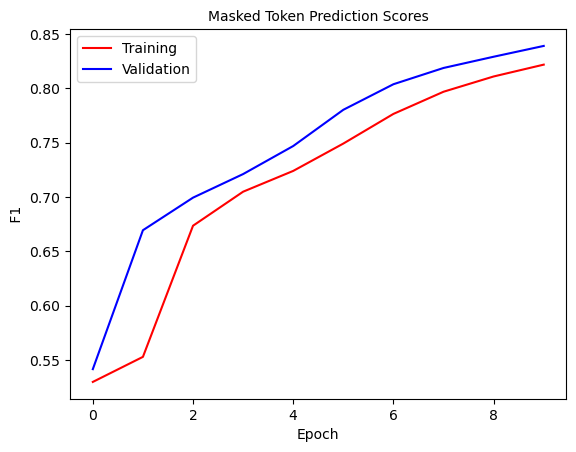

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 10: 100%|██████████| 445/445 [07:05<00:00,  1.05it/s, loss=0.674]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to

Training:   Instruction f1:  0.766181903091191   Masked Token f1 0.8316209505063676     SEQ F1 0.9571824793604115


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:40<00:00,  2.76it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior

Validation:  Instruction F1:  0.7824854004950614    v_masked_token_ F1:  0.8463120426700469  V SEQ F1:  0.963431463231403


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


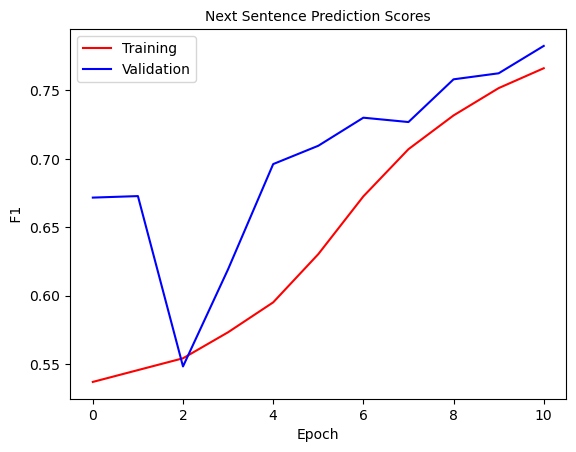

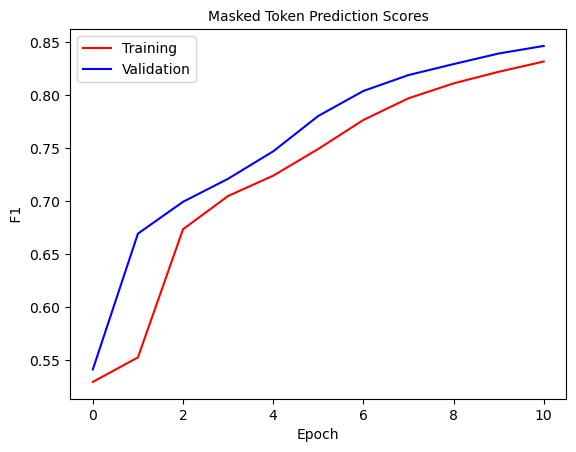

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 11: 100%|██████████| 445/445 [07:05<00:00,  1.05it/s, loss=0.52] 
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to

Training:   Instruction f1:  0.7797549522061452   Masked Token f1 0.8391729361906163     SEQ F1 0.9596916270542742


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:40<00:00,  2.77it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior

Validation:  Instruction F1:  0.7997468710448601    v_masked_token_ F1:  0.8531247071757673  V SEQ F1:  0.9660168003591768


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


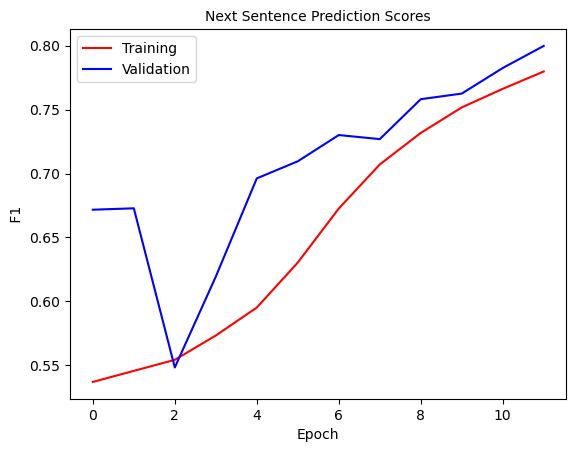

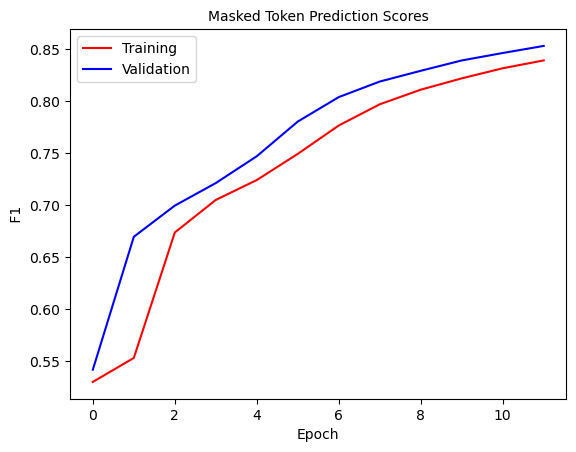

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 12: 100%|██████████| 445/445 [07:05<00:00,  1.05it/s, loss=0.573]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to

Training:   Instruction f1:  0.7901826334663486   Masked Token f1 0.8456136519059579     SEQ F1 0.9618907273093799


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:40<00:00,  2.76it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior

Validation:  Instruction F1:  0.799980859412384    v_masked_token_ F1:  0.858357407377575  V SEQ F1:  0.9678387767842713


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


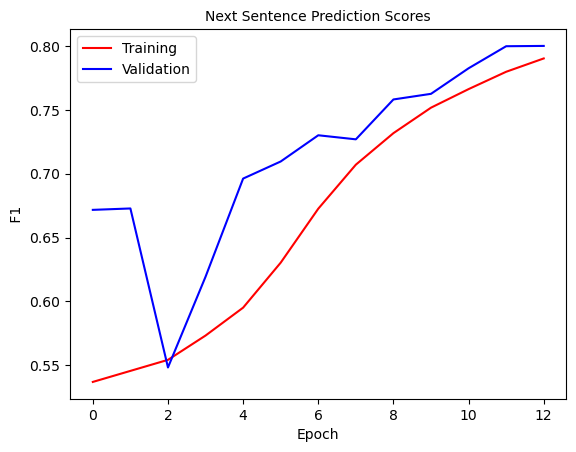

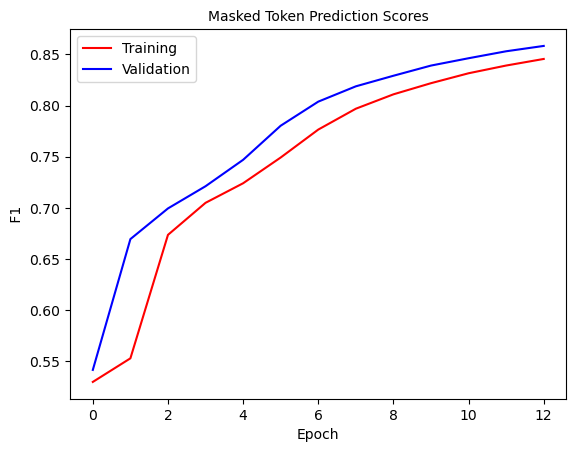

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 13: 100%|██████████| 445/445 [07:05<00:00,  1.05it/s, loss=0.558]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to

Training:   Instruction f1:  0.8004680613469237   Masked Token f1 0.8507942319420259     SEQ F1 0.9637620491835015


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:40<00:00,  2.74it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior

Validation:  Instruction F1:  0.8147976664505973    v_masked_token_ F1:  0.8622704041053283  V SEQ F1:  0.969319441520768


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


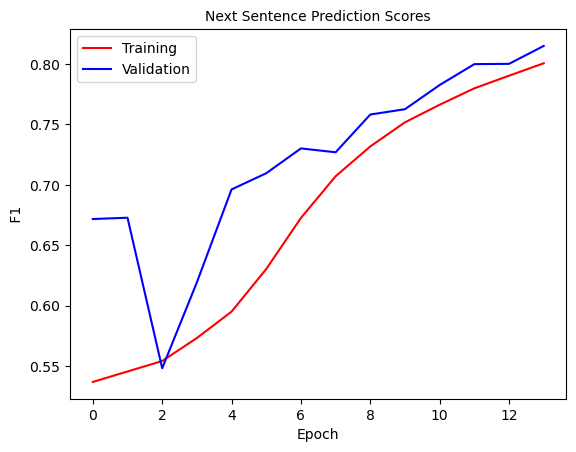

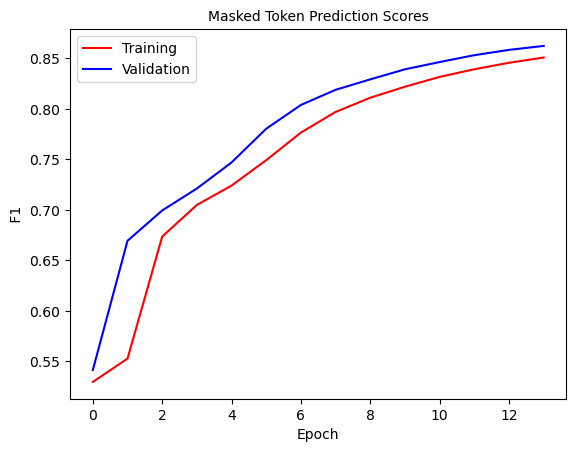

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 14: 100%|██████████| 445/445 [07:07<00:00,  1.04it/s, loss=0.471]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to

Training:   Instruction f1:  0.8093880653743823   Masked Token f1 0.8556038079423098     SEQ F1 0.9654645860390436


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:40<00:00,  2.76it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior

Validation:  Instruction F1:  0.8139959672636697    v_masked_token_ F1:  0.8658890526800745  V SEQ F1:  0.9706619888498695


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


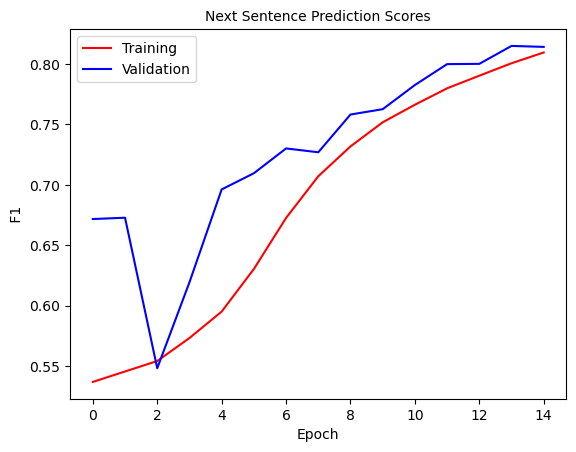

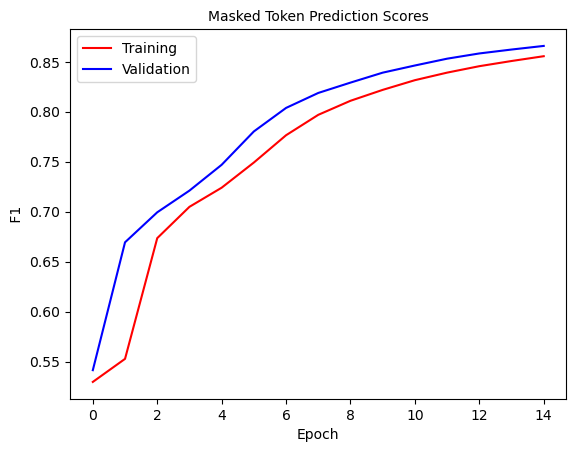

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 15: 100%|██████████| 445/445 [07:07<00:00,  1.04it/s, loss=0.653]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to

Training:   Instruction f1:  0.8155630555687599   Masked Token f1 0.8594920187067782     SEQ F1 0.9670300650637139


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:40<00:00,  2.76it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior

Validation:  Instruction F1:  0.8216930346270481    v_masked_token_ F1:  0.8691182090566445  V SEQ F1:  0.9724407643371421


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


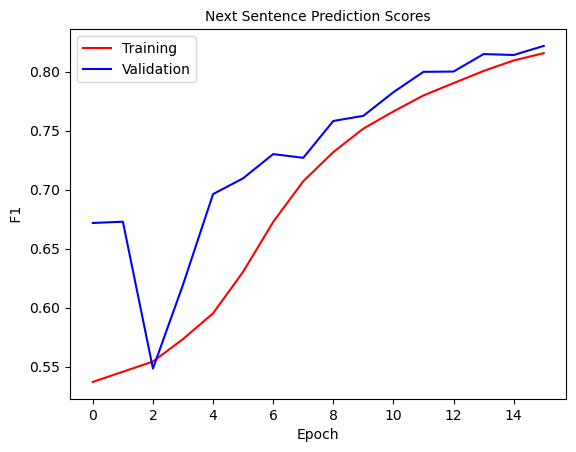

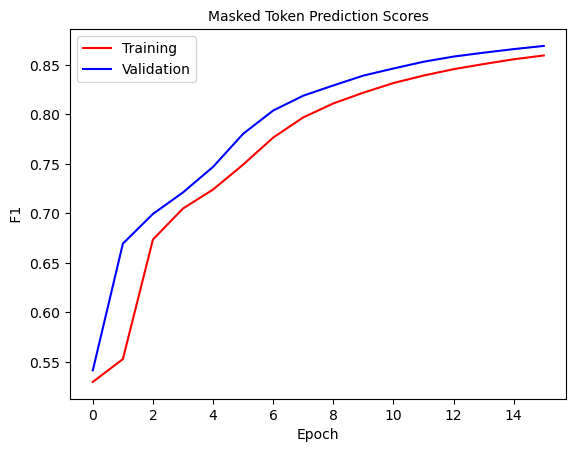

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 16: 100%|██████████| 445/445 [07:04<00:00,  1.05it/s, loss=0.579]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to

Training:   Instruction f1:  0.8220718981808679   Masked Token f1 0.8624120316950713     SEQ F1 0.9684694777152018


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:40<00:00,  2.77it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior

Validation:  Instruction F1:  0.8229074468339593    v_masked_token_ F1:  0.8716418272883582  V SEQ F1:  0.9738724681963847


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


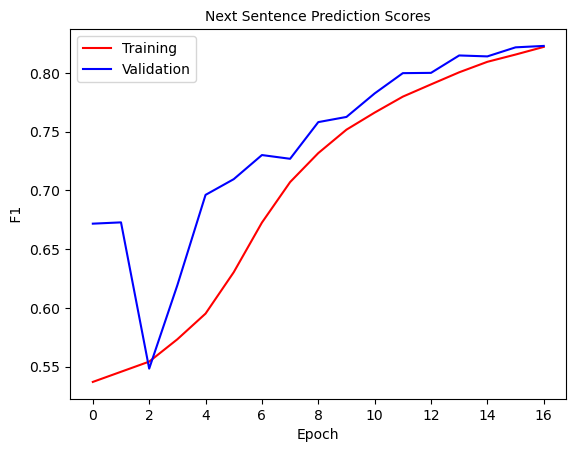

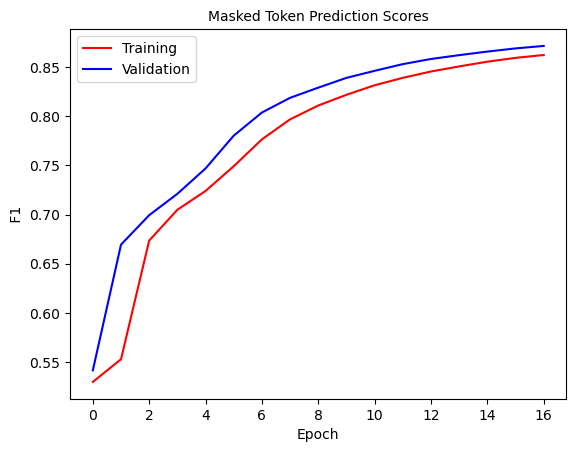

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 17: 100%|██████████| 445/445 [07:05<00:00,  1.05it/s, loss=0.444]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to

Training:   Instruction f1:  0.8271097434922596   Masked Token f1 0.8653021571002717     SEQ F1 0.969784973046668


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:40<00:00,  2.77it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior

Validation:  Instruction F1:  0.8322101340938888    v_masked_token_ F1:  0.874762297313128  V SEQ F1:  0.9750673527974268


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


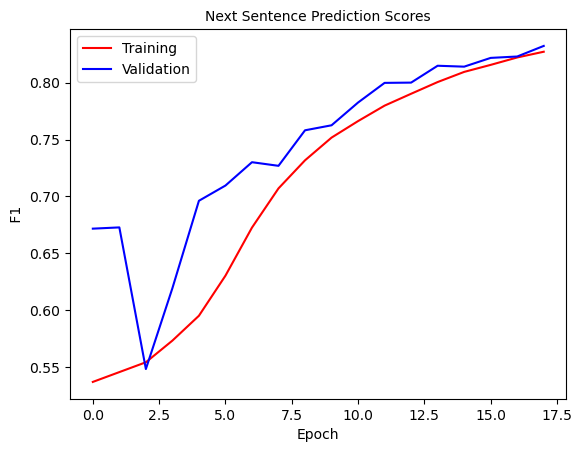

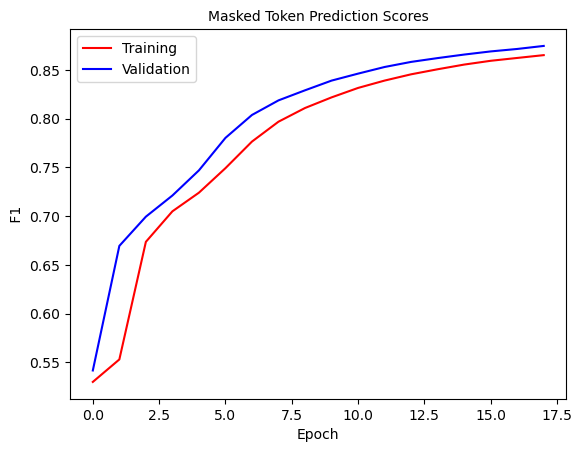

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 18: 100%|██████████| 445/445 [07:04<00:00,  1.05it/s, loss=0.52] 
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to

Training:   Instruction f1:  0.8325787553622569   Masked Token f1 0.8676793689620738     SEQ F1 0.9710617814408237


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:40<00:00,  2.77it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior

Validation:  Instruction F1:  0.8296809463216929    v_masked_token_ F1:  0.8760426518840262  V SEQ F1:  0.975886894363932


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


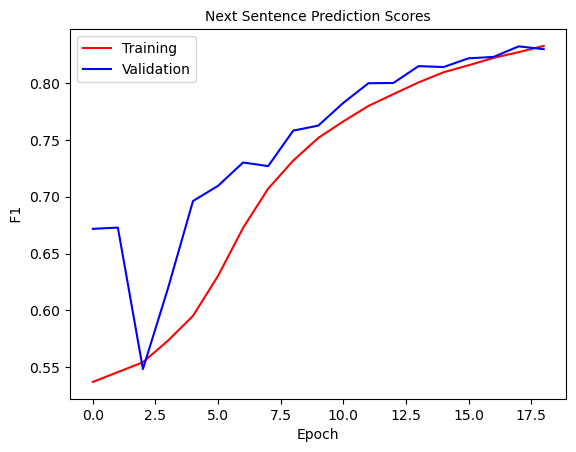

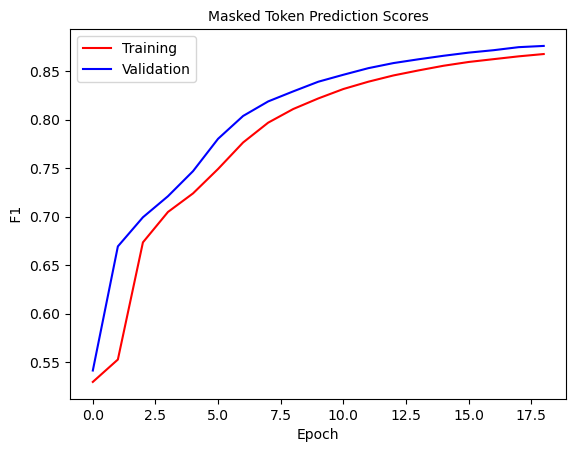

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 19: 100%|██████████| 445/445 [07:04<00:00,  1.05it/s, loss=0.476]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to

Training:   Instruction f1:  0.837689868532   Masked Token f1 0.8699704075697767     SEQ F1 0.9722682089573821


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:40<00:00,  2.76it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior

Validation:  Instruction F1:  0.8312451149901707    v_masked_token_ F1:  0.8779121778514929  V SEQ F1:  0.9771390668375305


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


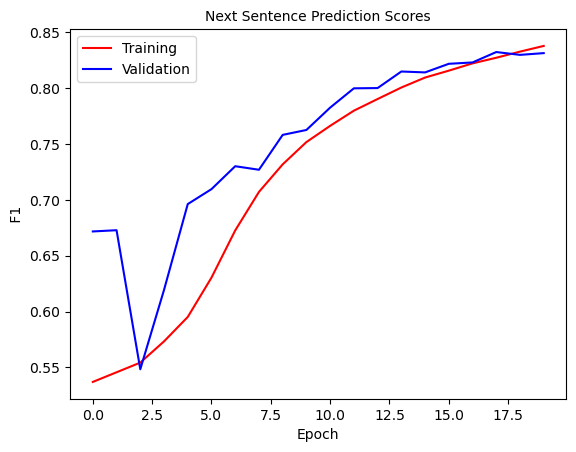

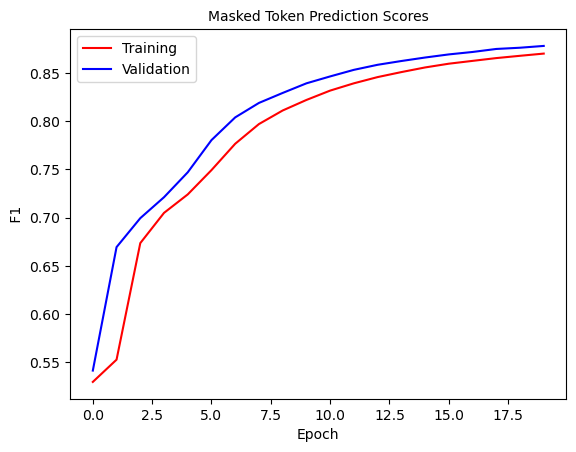

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 20: 100%|██████████| 445/445 [07:04<00:00,  1.05it/s, loss=0.408]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to

Training:   Instruction f1:  0.8427439723772338   Masked Token f1 0.8719376196675361     SEQ F1 0.9733969082250474


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:40<00:00,  2.74it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior

Validation:  Instruction F1:  0.8342738412863315    v_masked_token_ F1:  0.8793935372525562  V SEQ F1:  0.9776908893481594


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


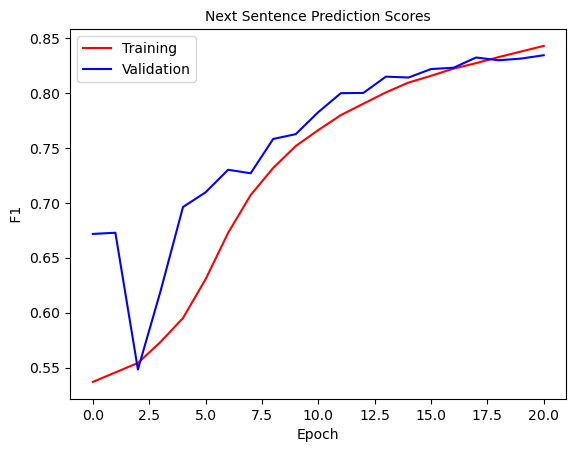

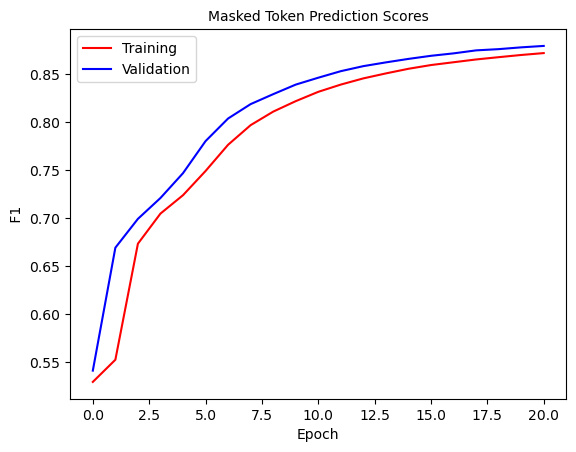

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 21: 100%|██████████| 445/445 [07:02<00:00,  1.05it/s, loss=0.387]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to

Training:   Instruction f1:  0.845678168976435   Masked Token f1 0.8735669723579055     SEQ F1 0.9743979235069714


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:40<00:00,  2.77it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior

Validation:  Instruction F1:  0.8381458073913963    v_masked_token_ F1:  0.8804707617791022  V SEQ F1:  0.9785710705306375


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


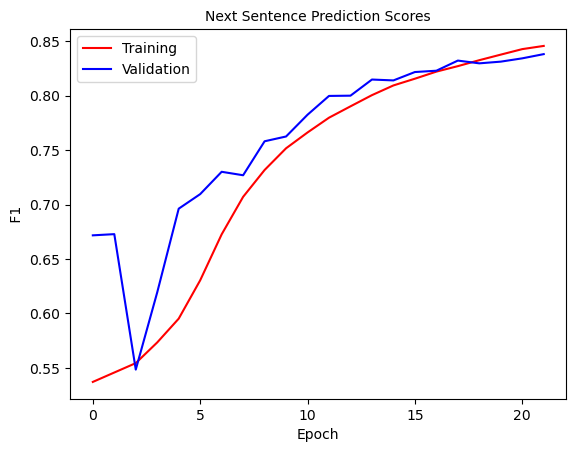

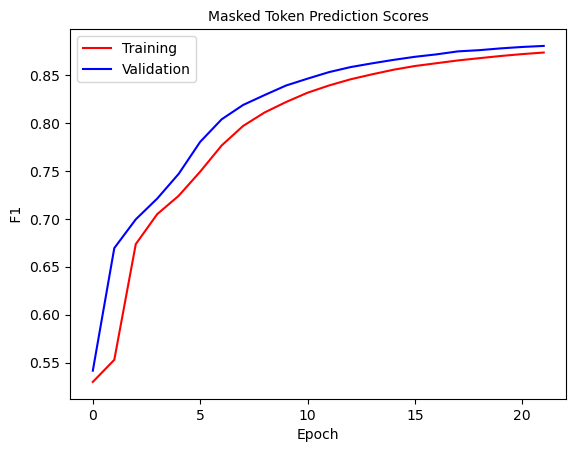

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 22: 100%|██████████| 445/445 [07:03<00:00,  1.05it/s, loss=0.398]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to

Training:   Instruction f1:  0.8503570282889968   Masked Token f1 0.8750403359389934     SEQ F1 0.9753348306629106


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:40<00:00,  2.77it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior

Validation:  Instruction F1:  0.8380952380952381    v_masked_token_ F1:  0.8820633418482156  V SEQ F1:  0.9794565700836128


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


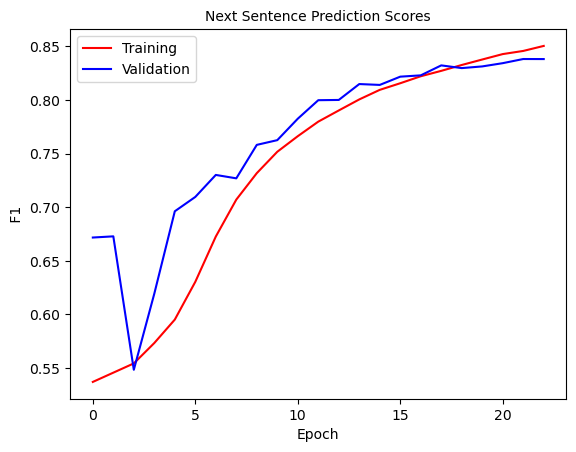

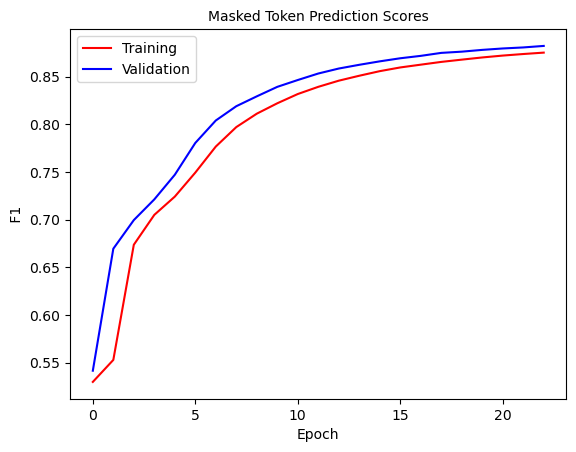

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 23: 100%|██████████| 445/445 [07:02<00:00,  1.05it/s, loss=0.356]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to

Training:   Instruction f1:  0.8539753080551826   Masked Token f1 0.8765586119214718     SEQ F1 0.9762328226406366


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:40<00:00,  2.78it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior

Validation:  Instruction F1:  0.8404126213592233    v_masked_token_ F1:  0.8829526142579914  V SEQ F1:  0.9801050219552916


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


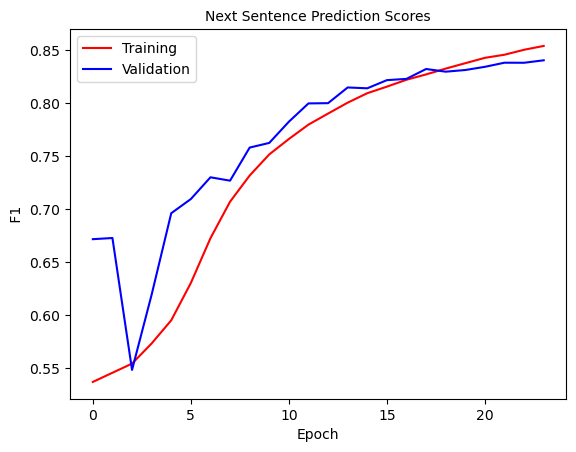

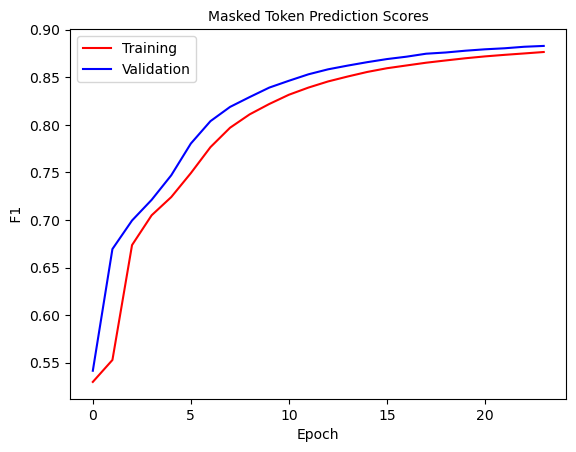

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 24: 100%|██████████| 445/445 [07:03<00:00,  1.05it/s, loss=0.464]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to

Training:   Instruction f1:  0.8573668176986526   Masked Token f1 0.8777444431732209     SEQ F1 0.9769916287903109


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:40<00:00,  2.78it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior

Validation:  Instruction F1:  0.8415860278498938    v_masked_token_ F1:  0.8839833679426945  V SEQ F1:  0.9804928318389888


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


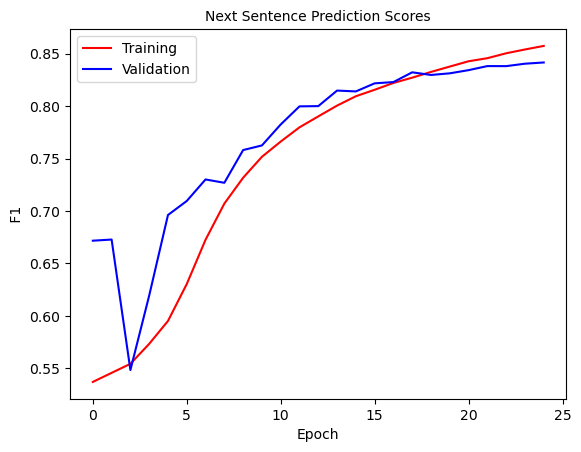

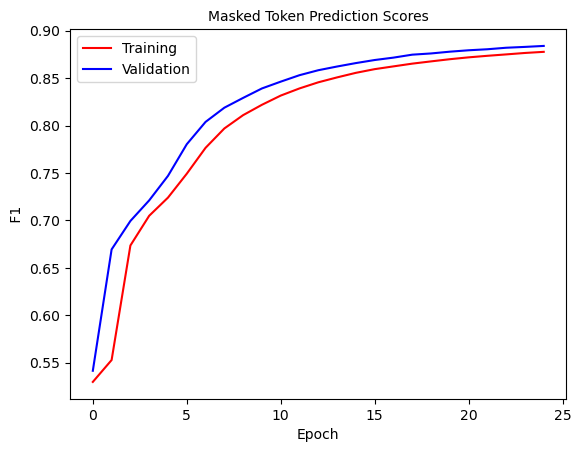

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 25: 100%|██████████| 445/445 [07:03<00:00,  1.05it/s, loss=0.392]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to

Training:   Instruction f1:  0.8612435645445746   Masked Token f1 0.879178633820474     SEQ F1 0.9776891176267752


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:40<00:00,  2.77it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior

Validation:  Instruction F1:  0.8384902768464413    v_masked_token_ F1:  0.8853647117020893  V SEQ F1:  0.981255134535978


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


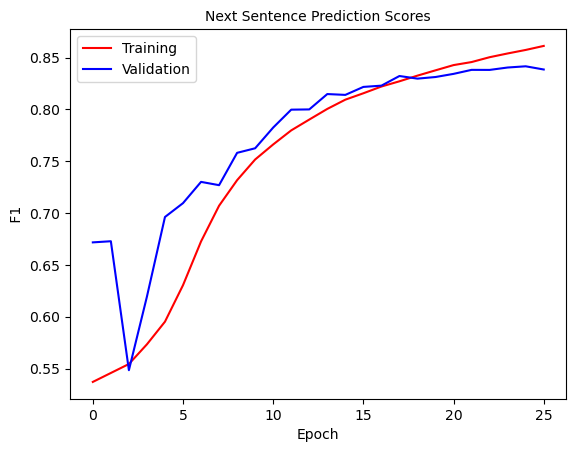

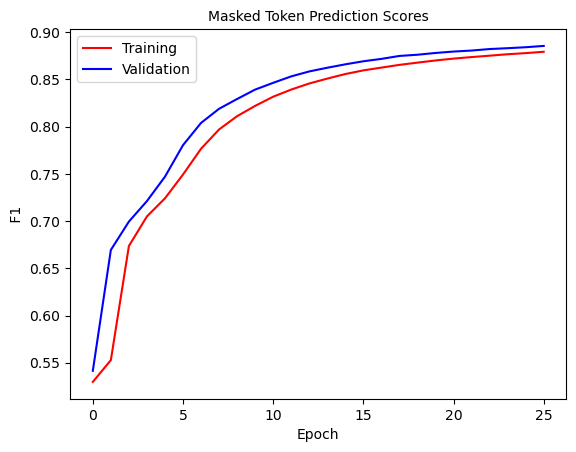

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 26: 100%|██████████| 445/445 [07:05<00:00,  1.05it/s, loss=0.517]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to

Training:   Instruction f1:  0.8646381598488719   Masked Token f1 0.8801245590150797     SEQ F1 0.9783135090069818


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:40<00:00,  2.77it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior

Validation:  Instruction F1:  0.842749089550845    v_masked_token_ F1:  0.8862608435679517  V SEQ F1:  0.9815765563509945


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


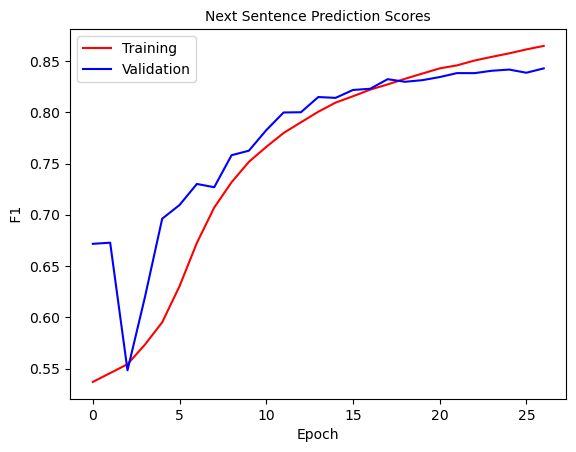

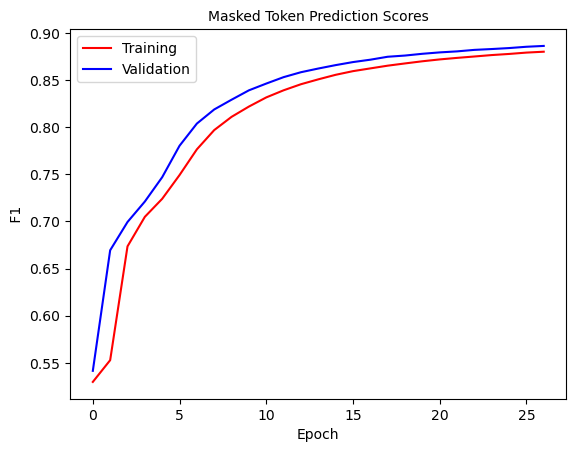

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 27: 100%|██████████| 445/445 [07:05<00:00,  1.05it/s, loss=0.291]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to

Training:   Instruction f1:  0.8682945952849073   Masked Token f1 0.881156028867639     SEQ F1 0.9788259008214812


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:40<00:00,  2.76it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior

Validation:  Instruction F1:  0.8384604309641503    v_masked_token_ F1:  0.8873561299925725  V SEQ F1:  0.9819567126851894


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


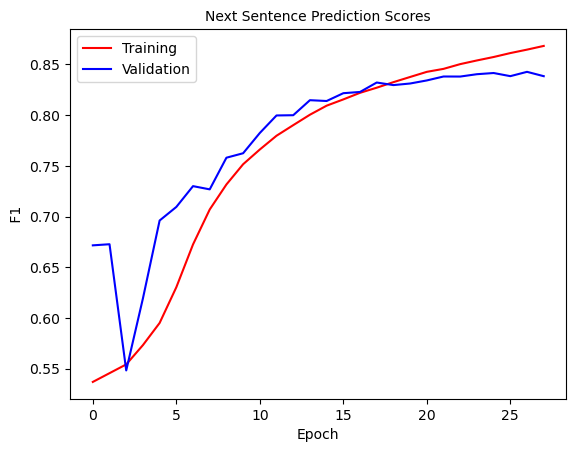

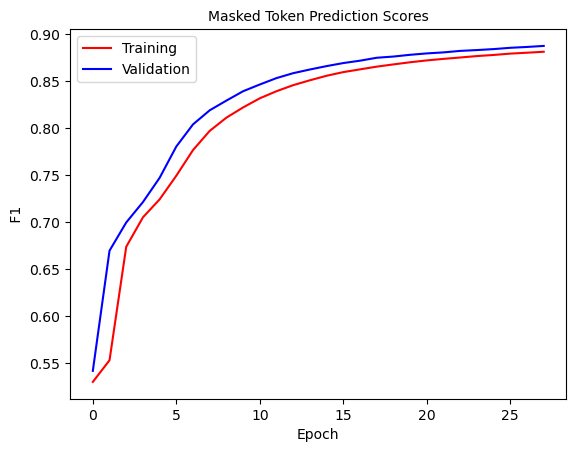

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 28: 100%|██████████| 445/445 [07:04<00:00,  1.05it/s, loss=0.432]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to

Training:   Instruction f1:  0.8716788676534326   Masked Token f1 0.8821868037585948     SEQ F1 0.9793912628838429


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:40<00:00,  2.77it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior

Validation:  Instruction F1:  0.8407486377635631    v_masked_token_ F1:  0.8886189968320127  V SEQ F1:  0.982371612661589


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


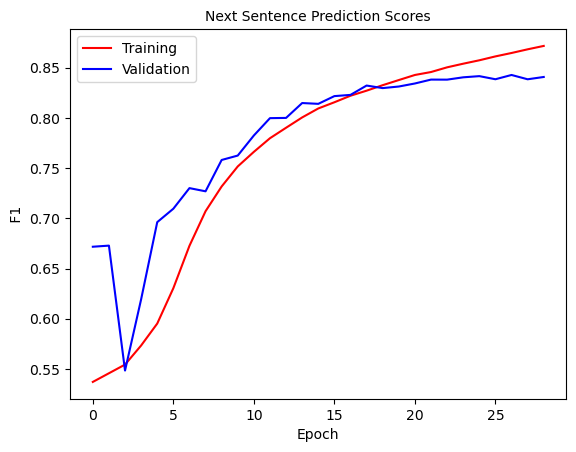

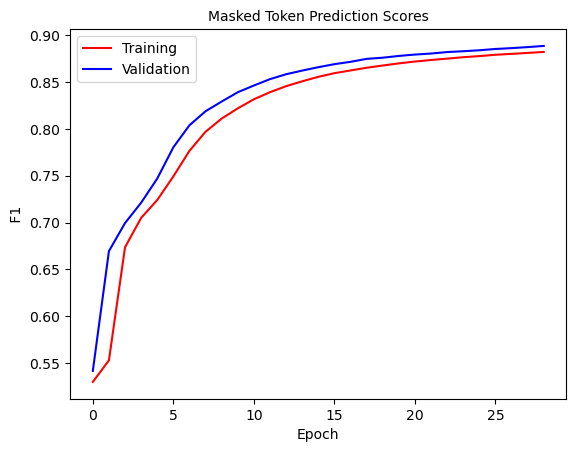

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 29: 100%|██████████| 445/445 [07:05<00:00,  1.05it/s, loss=0.474]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to

Training:   Instruction f1:  0.8743596288667138   Masked Token f1 0.8829501008144439     SEQ F1 0.97981317521181


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:40<00:00,  2.73it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior

Validation:  Instruction F1:  0.8431257206051908    v_masked_token_ F1:  0.8890032986471456  V SEQ F1:  0.9827094913870679


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


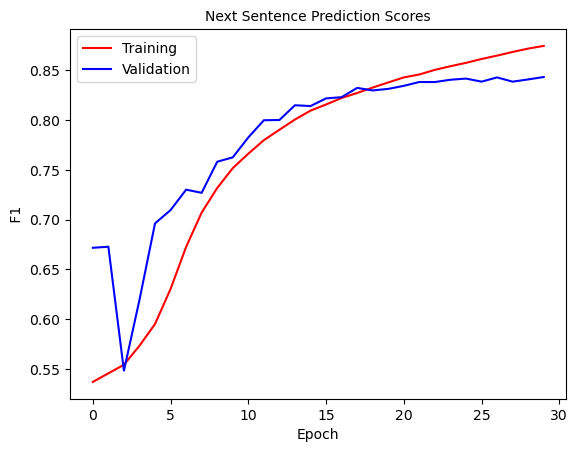

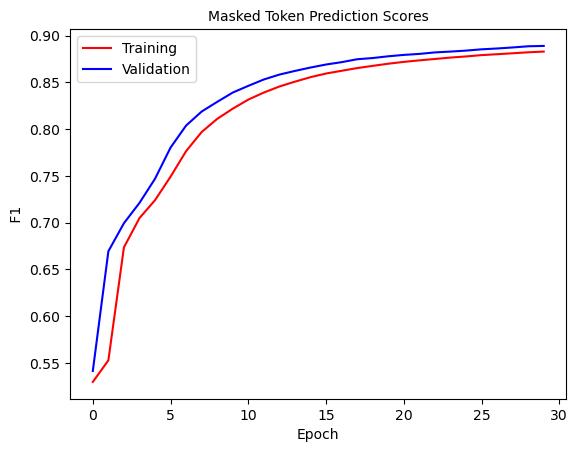

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 30: 100%|██████████| 445/445 [07:04<00:00,  1.05it/s, loss=0.299]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to

Training:   Instruction f1:  0.8784003802959177   Masked Token f1 0.883871882387255     SEQ F1 0.9802469305425424


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:40<00:00,  2.75it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior

Validation:  Instruction F1:  0.8448069755994656    v_masked_token_ F1:  0.8895149513959829  V SEQ F1:  0.9829450235120752


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


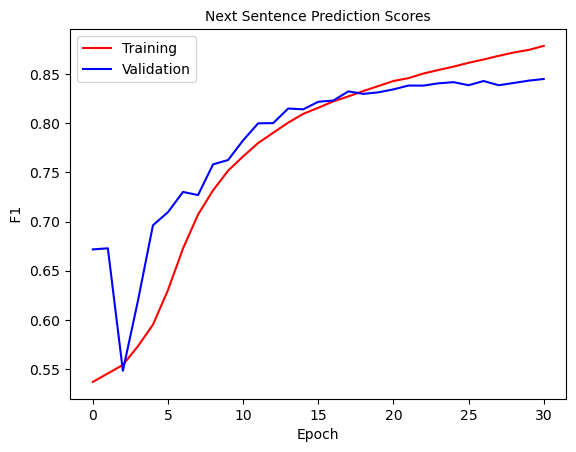

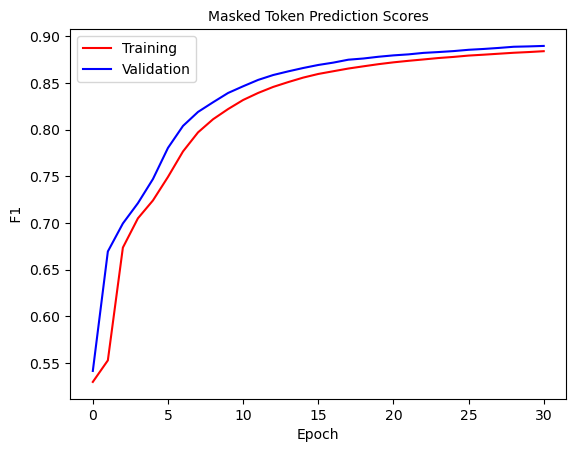

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 31: 100%|██████████| 445/445 [07:08<00:00,  1.04it/s, loss=0.37] 
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to

Training:   Instruction f1:  0.880483164514198   Masked Token f1 0.8844078804179786     SEQ F1 0.9806298879643953


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:40<00:00,  2.75it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior

Validation:  Instruction F1:  0.8444034003457176    v_masked_token_ F1:  0.8903358319044176  V SEQ F1:  0.9830759687966597


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


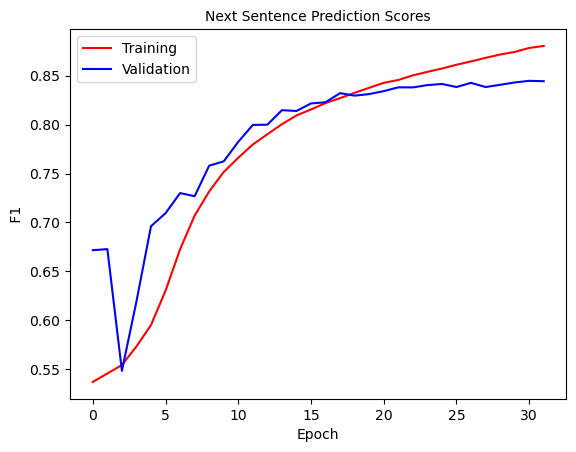

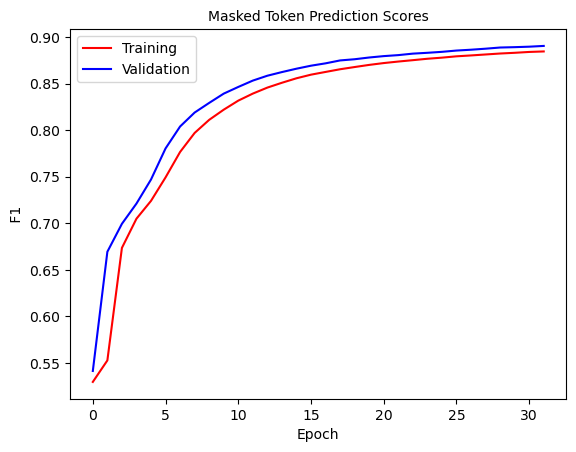

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 32: 100%|██████████| 445/445 [07:05<00:00,  1.05it/s, loss=0.511]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to

Training:   Instruction f1:  0.8842929607546498   Masked Token f1 0.8851508237990114     SEQ F1 0.9809545548753589


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:40<00:00,  2.75it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior

Validation:  Instruction F1:  0.8422640425226261    v_masked_token_ F1:  0.890959515134059  V SEQ F1:  0.9835355255508812


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


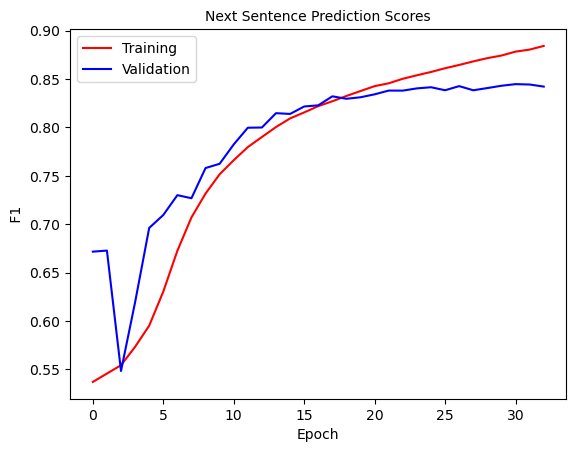

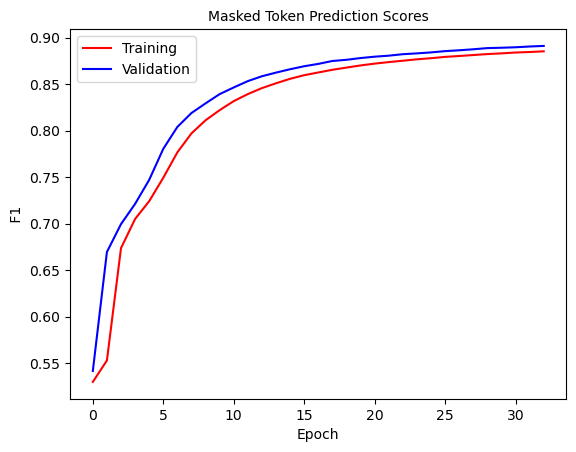

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 33: 100%|██████████| 445/445 [07:06<00:00,  1.04it/s, loss=0.455]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to

Training:   Instruction f1:  0.8868753594999911   Masked Token f1 0.8859296975581572     SEQ F1 0.9813251461048097


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:40<00:00,  2.76it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior

Validation:  Instruction F1:  0.8445575106588462    v_masked_token_ F1:  0.8919811804911121  V SEQ F1:  0.9837817183655364


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


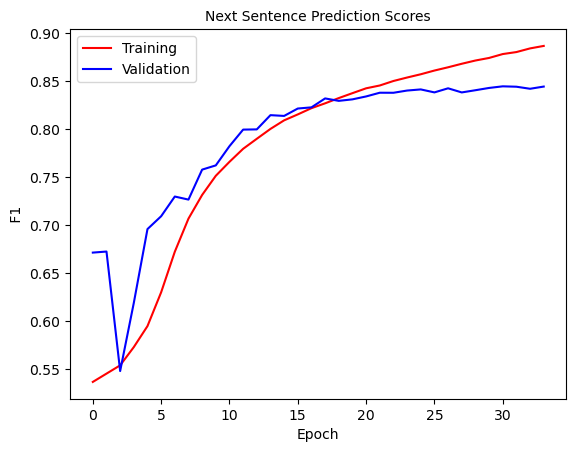

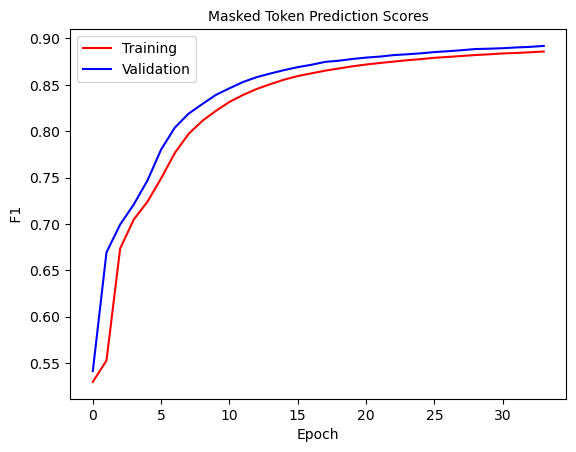

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 34: 100%|██████████| 445/445 [07:05<00:00,  1.05it/s, loss=0.338]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to

Training:   Instruction f1:  0.8891278261592748   Masked Token f1 0.886476528264504     SEQ F1 0.9816374013102263


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:40<00:00,  2.76it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior

Validation:  Instruction F1:  0.8457304830518484    v_masked_token_ F1:  0.8922233670634466  V SEQ F1:  0.9839235525551602


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


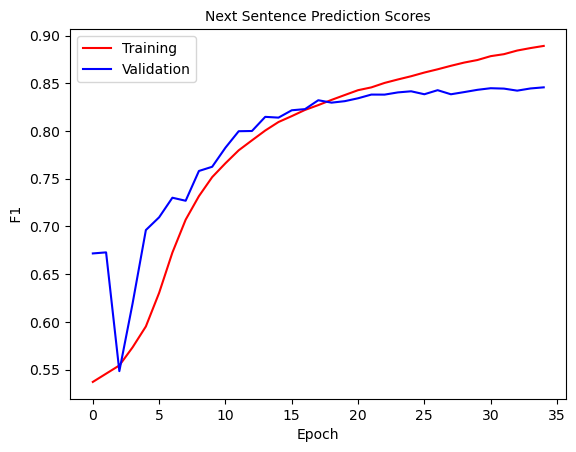

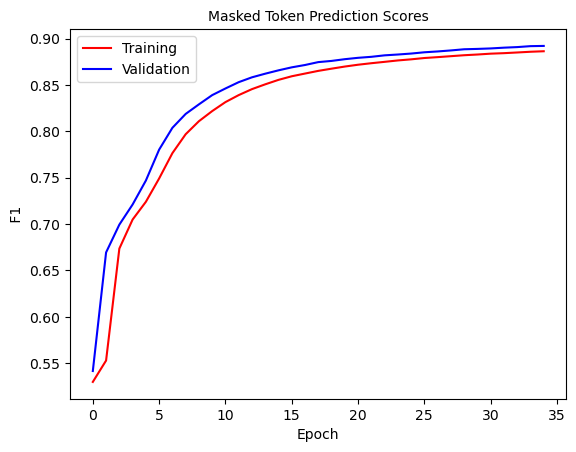

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 35: 100%|██████████| 445/445 [07:07<00:00,  1.04it/s, loss=0.355]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to

Training:   Instruction f1:  0.893197315245064   Masked Token f1 0.887105103177055     SEQ F1 0.9818991225981438


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:40<00:00,  2.75it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior

Validation:  Instruction F1:  0.8449801865078423    v_masked_token_ F1:  0.892301796925882  V SEQ F1:  0.984108939411931


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


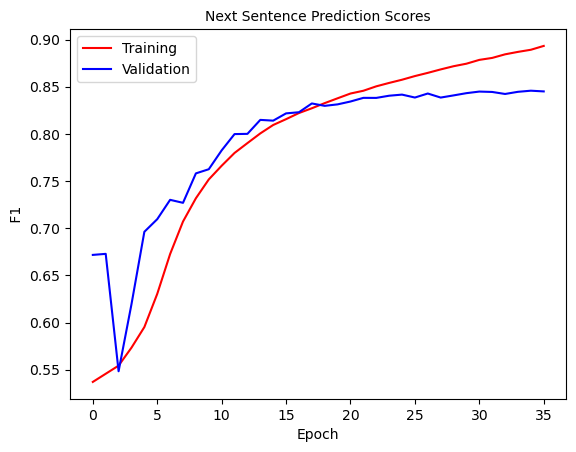

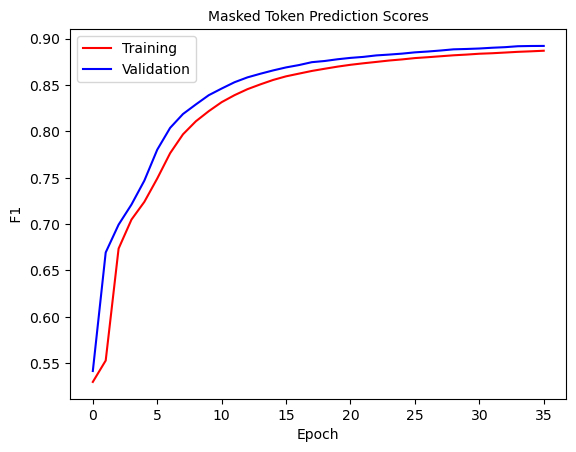

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 36: 100%|██████████| 445/445 [07:06<00:00,  1.04it/s, loss=0.374]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to

Training:   Instruction f1:  0.8950771055753263   Masked Token f1 0.8876658846068668     SEQ F1 0.9821851019536647


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:40<00:00,  2.74it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior

Validation:  Instruction F1:  0.8463145049632741    v_masked_token_ F1:  0.8932772907338619  V SEQ F1:  0.9842825609698972


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


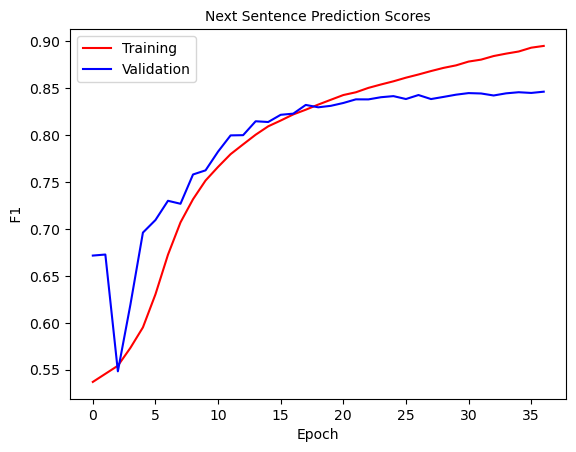

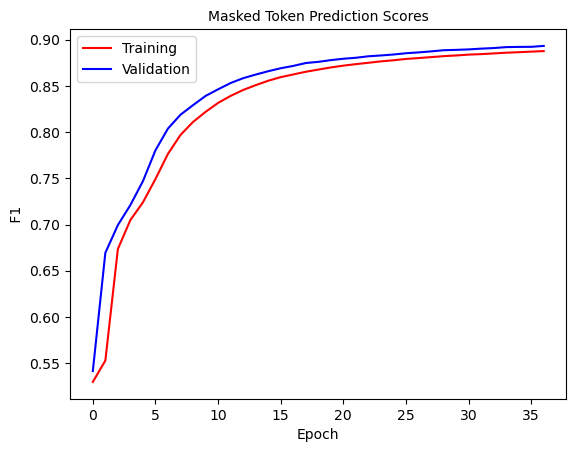

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 37: 100%|██████████| 445/445 [07:06<00:00,  1.04it/s, loss=0.524]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to

Training:   Instruction f1:  0.8981680203948539   Masked Token f1 0.8883786010206814     SEQ F1 0.9824479169553345


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:40<00:00,  2.75it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior

Validation:  Instruction F1:  0.8434458728823742    v_masked_token_ F1:  0.8936136939286853  V SEQ F1:  0.9844933667373353


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


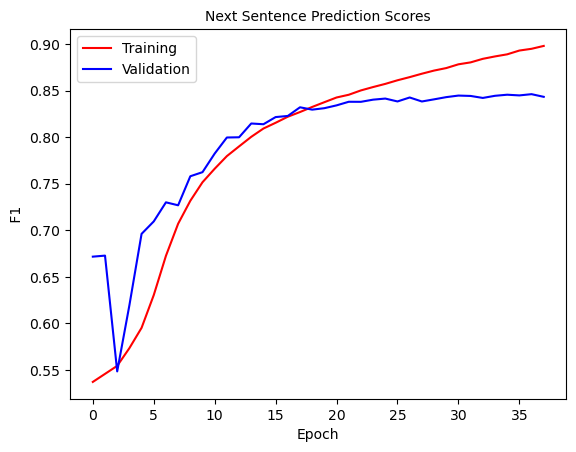

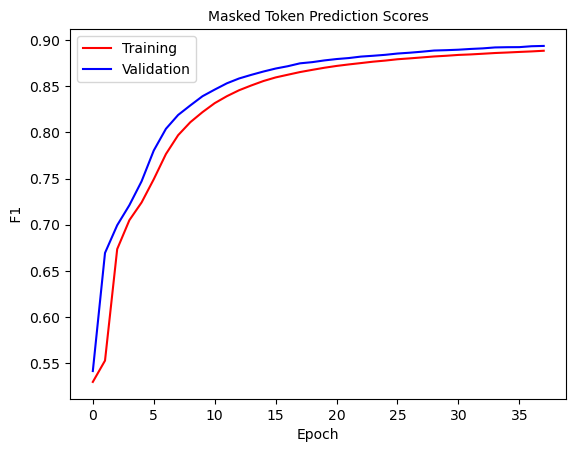

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 38: 100%|██████████| 445/445 [07:05<00:00,  1.05it/s, loss=0.356]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to

Training:   Instruction f1:  0.9008338967771017   Masked Token f1 0.8887362082920128     SEQ F1 0.9826610303623261


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:40<00:00,  2.75it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior

Validation:  Instruction F1:  0.8453861798231093    v_masked_token_ F1:  0.8937630959965224  V SEQ F1:  0.9845983430334654


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


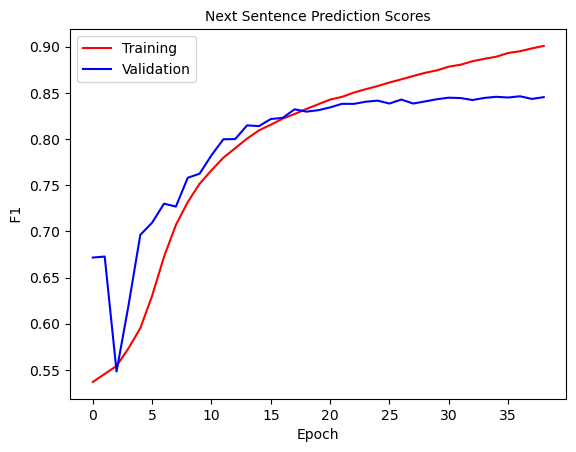

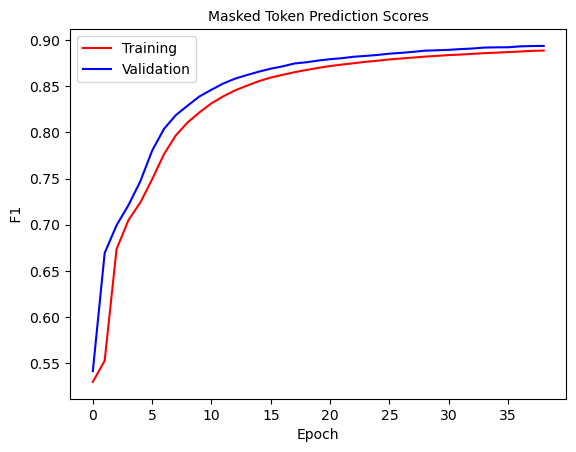

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 39: 100%|██████████| 445/445 [07:06<00:00,  1.04it/s, loss=0.382]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to

Training:   Instruction f1:  0.9029142894382928   Masked Token f1 0.8893181488840673     SEQ F1 0.9829236932340075


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:40<00:00,  2.76it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior

Validation:  Instruction F1:  0.8474432420963293    v_masked_token_ F1:  0.8943185711035349  V SEQ F1:  0.9847473143639551


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


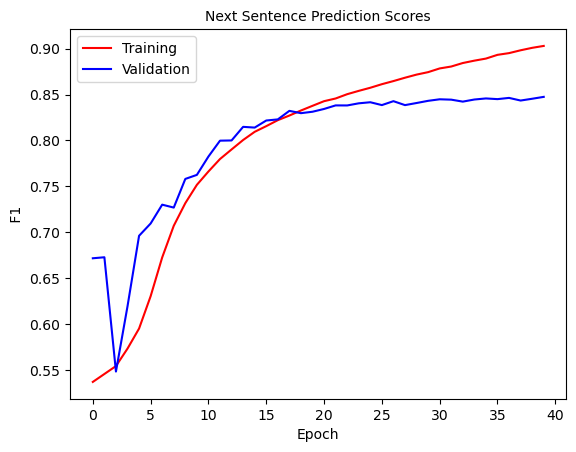

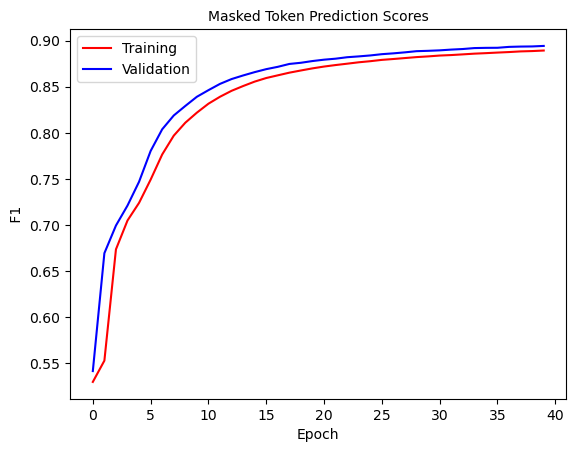

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 40: 100%|██████████| 445/445 [07:07<00:00,  1.04it/s, loss=0.299]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to

Training:   Instruction f1:  0.905401560239964   Masked Token f1 0.8898061050169279     SEQ F1 0.9831109463931696


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:40<00:00,  2.75it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior

Validation:  Instruction F1:  0.8478486506888092    v_masked_token_ F1:  0.8954239308350028  V SEQ F1:  0.9848833411543325


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


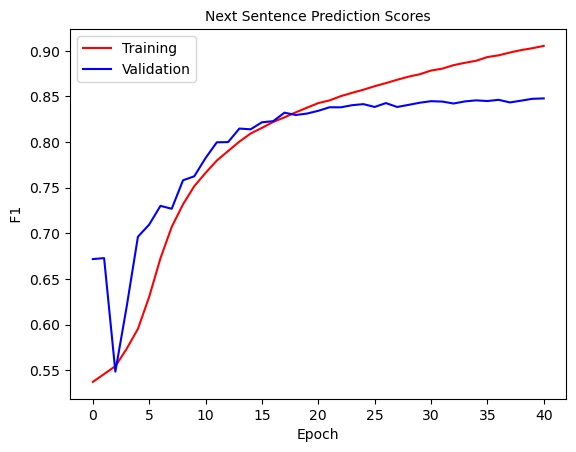

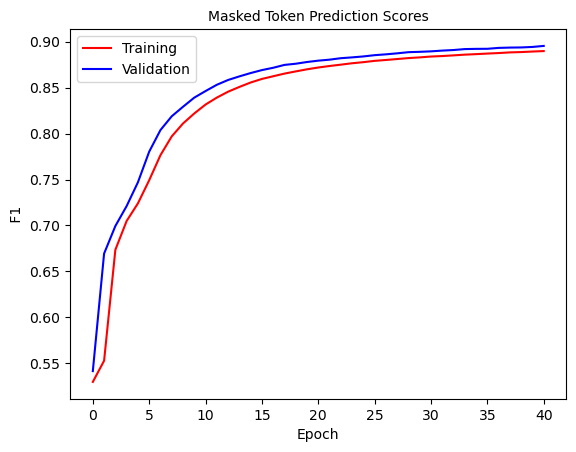

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 41: 100%|██████████| 445/445 [07:05<00:00,  1.05it/s, loss=0.308]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to

Training:   Instruction f1:  0.907653934794329   Masked Token f1 0.8900730155969431     SEQ F1 0.9832832033326788


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:40<00:00,  2.78it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior

Validation:  Instruction F1:  0.8478240347399226    v_masked_token_ F1:  0.8953464878653694  V SEQ F1:  0.984996040551011


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


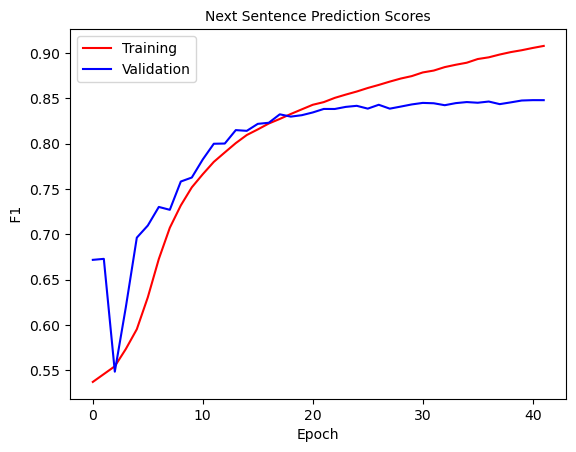

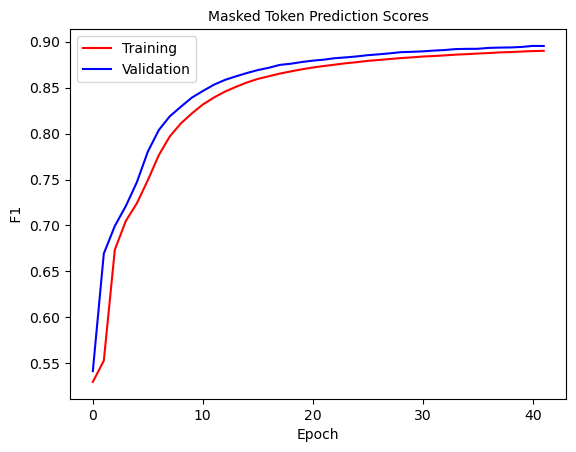

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 42: 100%|██████████| 445/445 [07:05<00:00,  1.05it/s, loss=0.291]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to

Training:   Instruction f1:  0.9106971452948914   Masked Token f1 0.8906742945595697     SEQ F1 0.9834896571859073


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:40<00:00,  2.75it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior

Validation:  Instruction F1:  0.8463633564644861    v_masked_token_ F1:  0.895605812811723  V SEQ F1:  0.9850779354756538


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


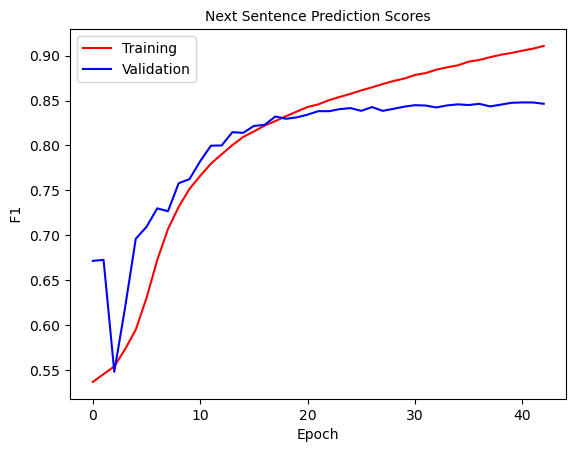

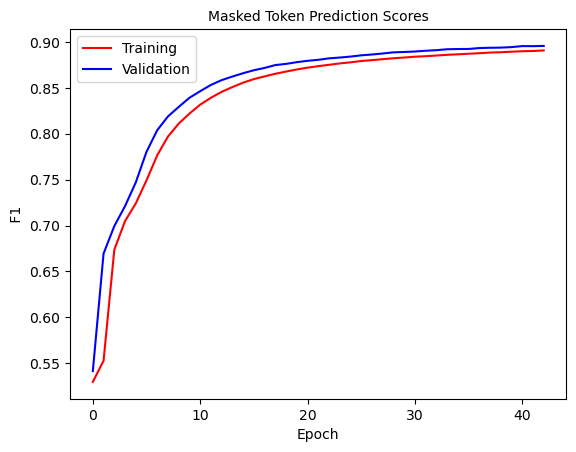

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 43: 100%|██████████| 445/445 [07:04<00:00,  1.05it/s, loss=0.313]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to

Training:   Instruction f1:  0.9143835008082615   Masked Token f1 0.8912504245824769     SEQ F1 0.983667534201526


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:40<00:00,  2.75it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior

Validation:  Instruction F1:  0.8460018814675447    v_masked_token_ F1:  0.8962684550237651  V SEQ F1:  0.9851786047222826


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


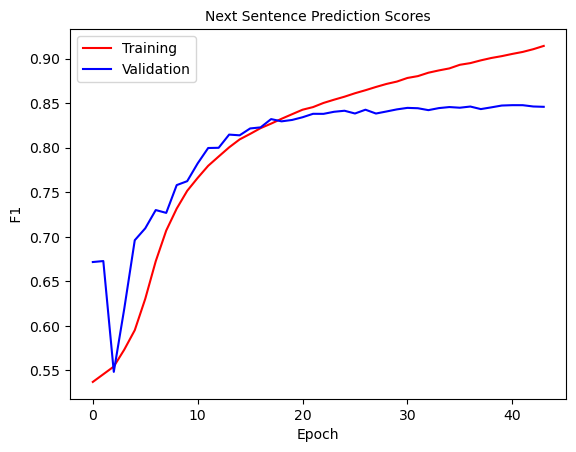

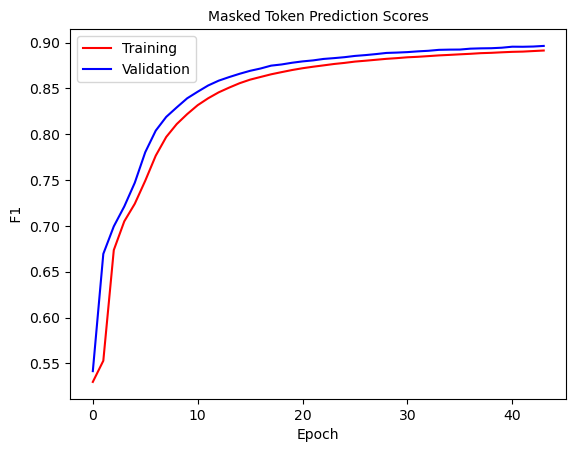

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 44: 100%|██████████| 445/445 [07:04<00:00,  1.05it/s, loss=0.181]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to

Training:   Instruction f1:  0.9152694894382873   Masked Token f1 0.8914352111152499     SEQ F1 0.9837819937499587


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:40<00:00,  2.77it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior

Validation:  Instruction F1:  0.8475502083676689    v_masked_token_ F1:  0.8963664985646691  V SEQ F1:  0.985249386207597


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


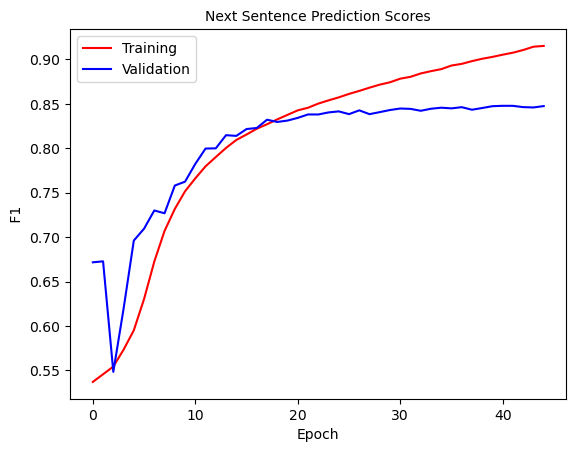

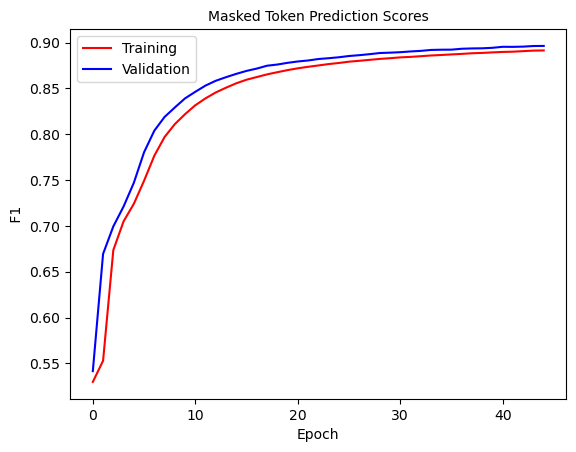

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 45: 100%|██████████| 445/445 [07:02<00:00,  1.05it/s, loss=0.299]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to

Training:   Instruction f1:  0.9183506668877781   Masked Token f1 0.8918230566912647     SEQ F1 0.9839305916776651


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:40<00:00,  2.77it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior

Validation:  Instruction F1:  0.8478215013945204    v_masked_token_ F1:  0.8969996408720251  V SEQ F1:  0.985345441031918


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


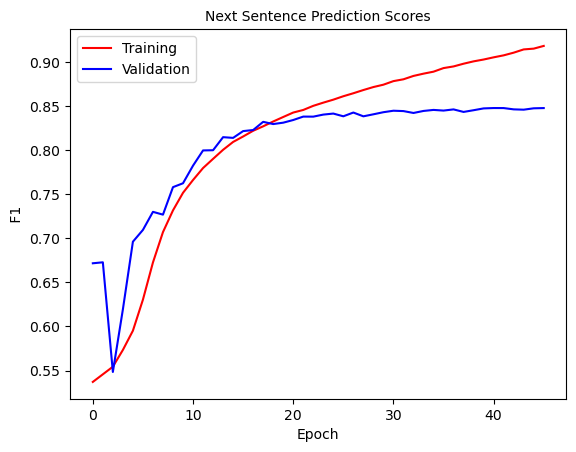

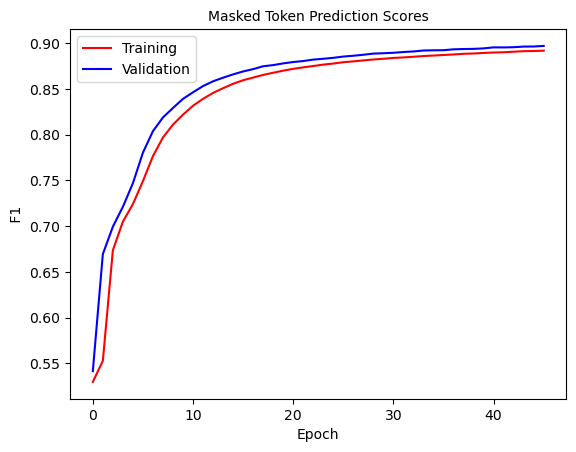

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 46: 100%|██████████| 445/445 [07:02<00:00,  1.05it/s, loss=0.307]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to

Training:   Instruction f1:  0.9201404722283089   Masked Token f1 0.8919276707335366     SEQ F1 0.9840370337951019


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:40<00:00,  2.76it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior

Validation:  Instruction F1:  0.8479236812570146    v_masked_token_ F1:  0.8970020529353953  V SEQ F1:  0.9854139512137927


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


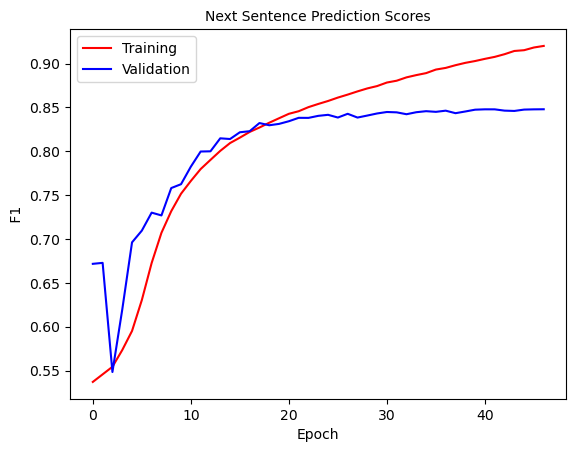

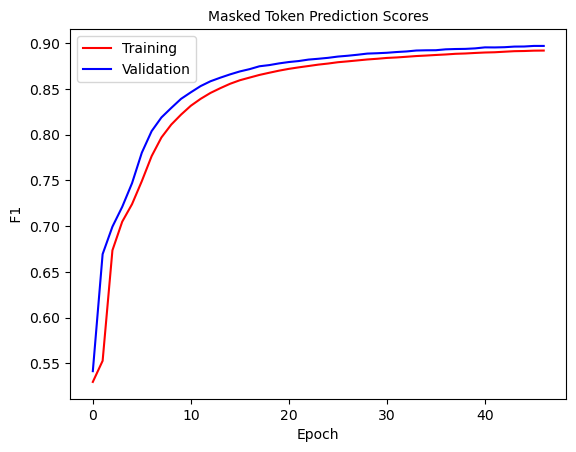

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 47: 100%|██████████| 445/445 [07:05<00:00,  1.05it/s, loss=0.284]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to

Training:   Instruction f1:  0.923297101020734   Masked Token f1 0.8922694487628919     SEQ F1 0.9841754712509483


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:40<00:00,  2.75it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior

Validation:  Instruction F1:  0.8476296104018689    v_masked_token_ F1:  0.8975328019799161  V SEQ F1:  0.9854865834185249


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


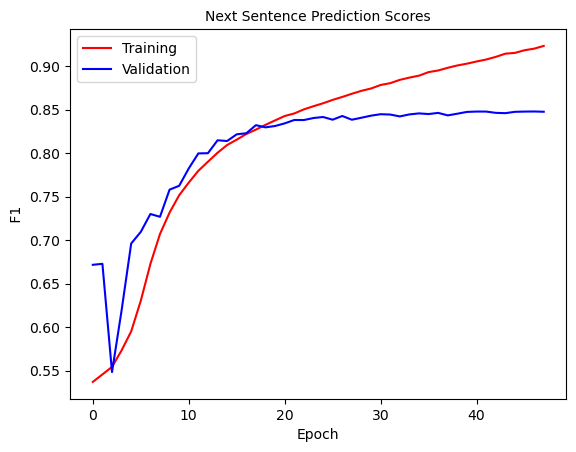

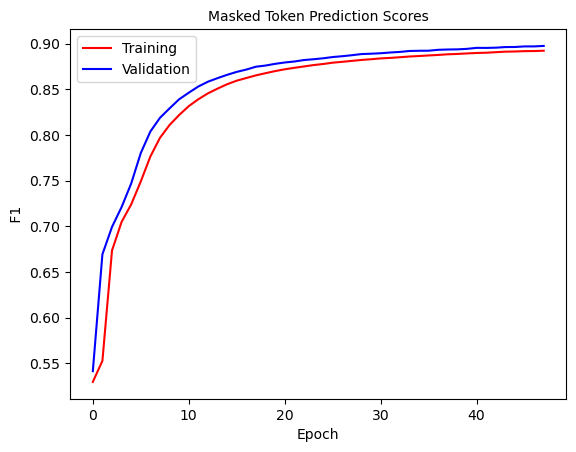

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 48: 100%|██████████| 445/445 [07:07<00:00,  1.04it/s, loss=0.284]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to

Training:   Instruction f1:  0.9249181451755889   Masked Token f1 0.892841155829198     SEQ F1 0.9843034759780177


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:40<00:00,  2.75it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior

Validation:  Instruction F1:  0.8469833179962719    v_masked_token_ F1:  0.8979832349788814  V SEQ F1:  0.9855703888984116


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


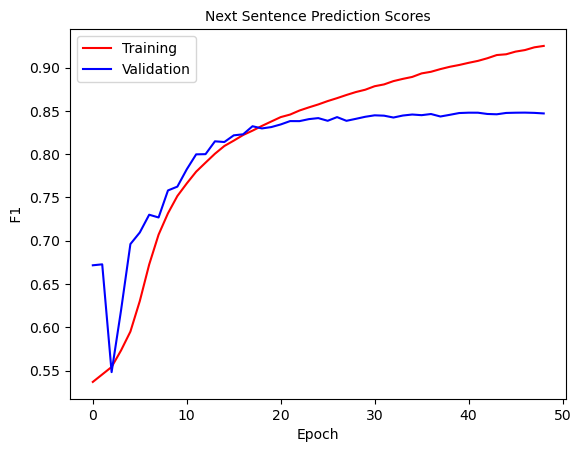

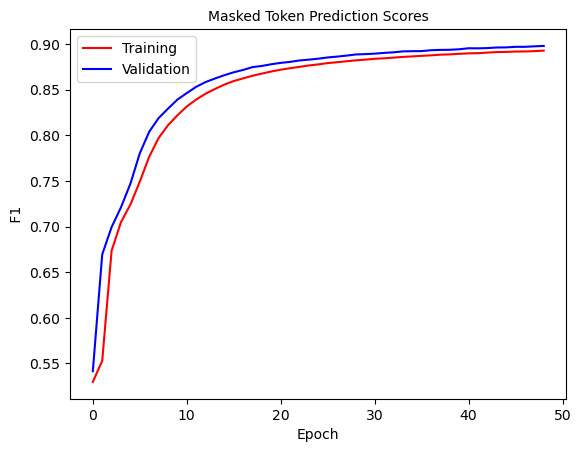

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 49: 100%|██████████| 445/445 [07:08<00:00,  1.04it/s, loss=0.356]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to

Training:   Instruction f1:  0.9272614438960962   Masked Token f1 0.8930206271940404     SEQ F1 0.9843965197973162


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:40<00:00,  2.76it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior

Validation:  Instruction F1:  0.8484241421882643    v_masked_token_ F1:  0.8979860282345692  V SEQ F1:  0.9856087287402051


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


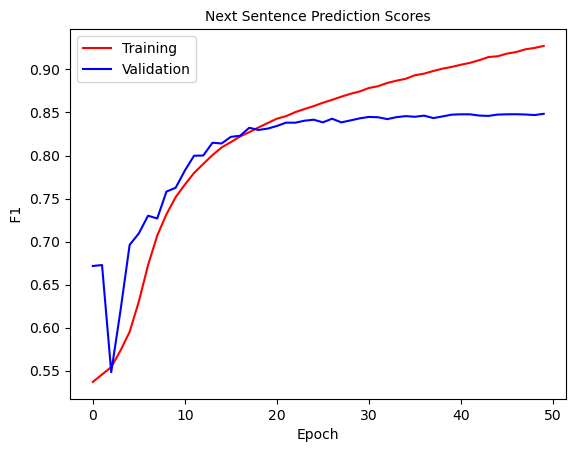

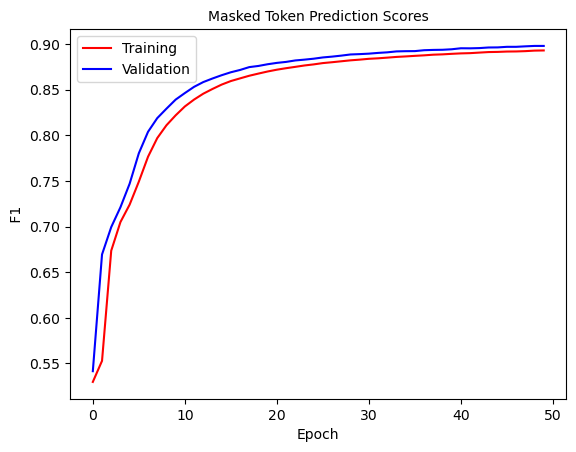

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 50: 100%|██████████| 445/445 [07:04<00:00,  1.05it/s, loss=0.232]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to

Training:   Instruction f1:  0.9290667044662579   Masked Token f1 0.8934003866879984     SEQ F1 0.984506409180419


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:40<00:00,  2.77it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior

Validation:  Instruction F1:  0.8452332993672835    v_masked_token_ F1:  0.8983581210268187  V SEQ F1:  0.9856482797939513


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


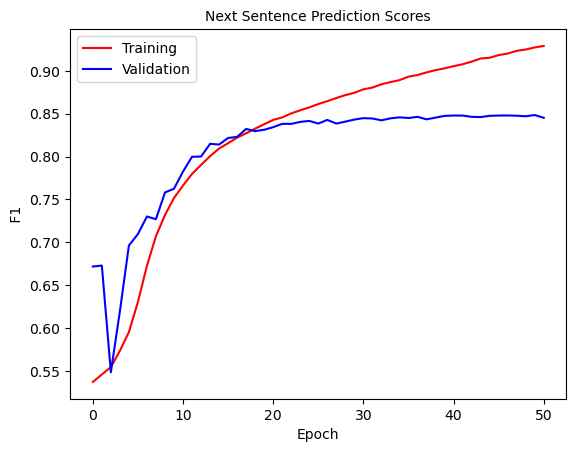

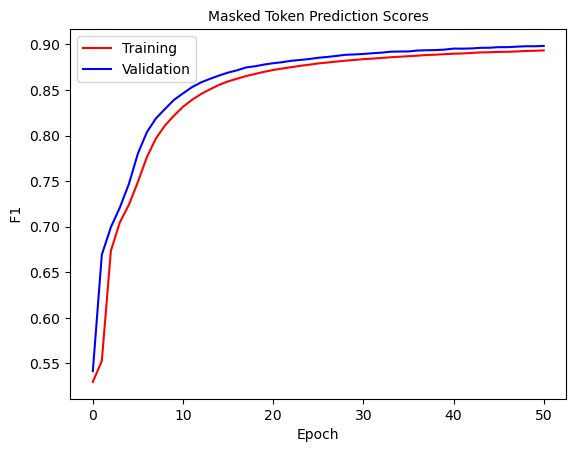

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 51: 100%|██████████| 445/445 [07:04<00:00,  1.05it/s, loss=0.289]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to

Training:   Instruction f1:  0.9312388820925601   Masked Token f1 0.8936692610106782     SEQ F1 0.9845812584889301


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:40<00:00,  2.76it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior

Validation:  Instruction F1:  0.8449588501766953    v_masked_token_ F1:  0.8986251934425888  V SEQ F1:  0.9857550816664394


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


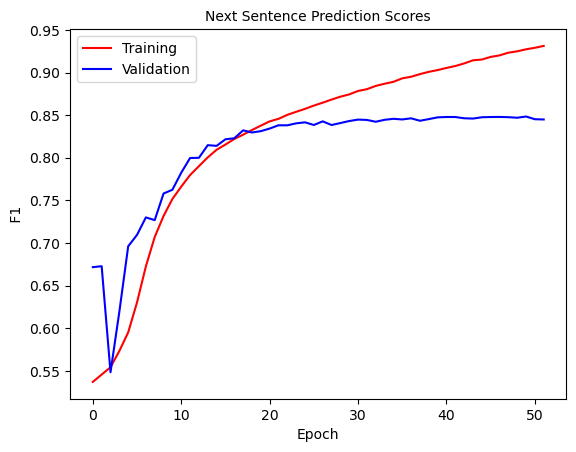

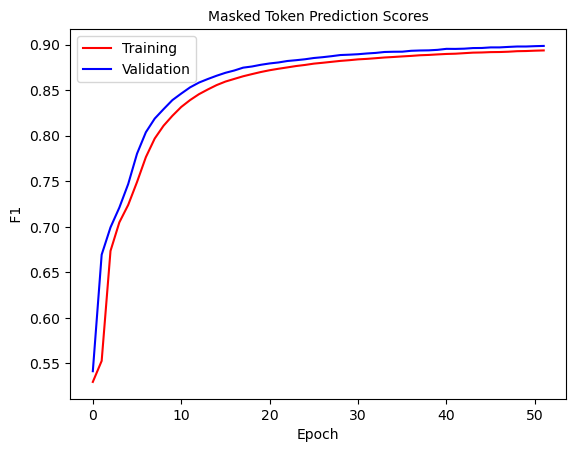

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 52: 100%|██████████| 445/445 [07:06<00:00,  1.04it/s, loss=0.28] 
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to

Training:   Instruction f1:  0.9332639767340135   Masked Token f1 0.894121343436733     SEQ F1 0.9847357046232815


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:40<00:00,  2.76it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior

Validation:  Instruction F1:  0.847099437848429    v_masked_token_ F1:  0.8989592611751874  V SEQ F1:  0.9858431077000412


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


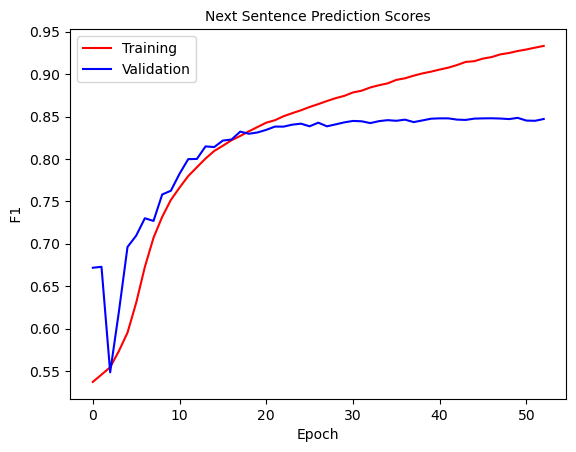

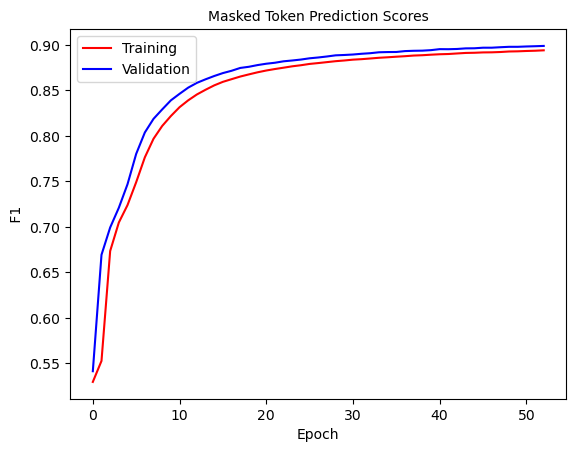

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 53: 100%|██████████| 445/445 [07:05<00:00,  1.05it/s, loss=0.243]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to

Training:   Instruction f1:  0.9348089410958338   Masked Token f1 0.8942426630216113     SEQ F1 0.984781040310186


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:40<00:00,  2.77it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior

Validation:  Instruction F1:  0.8449904139742952    v_masked_token_ F1:  0.8991181745088037  V SEQ F1:  0.9858138081987169


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


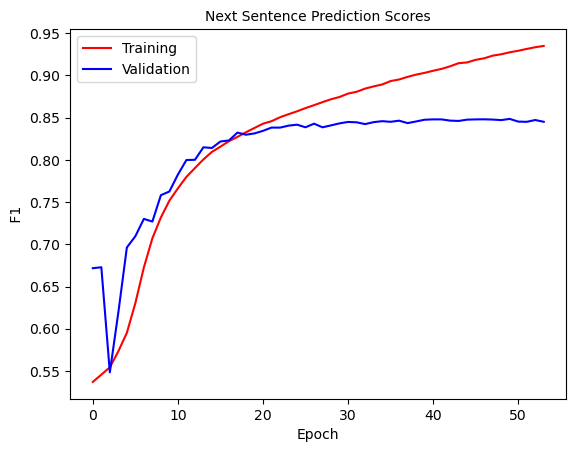

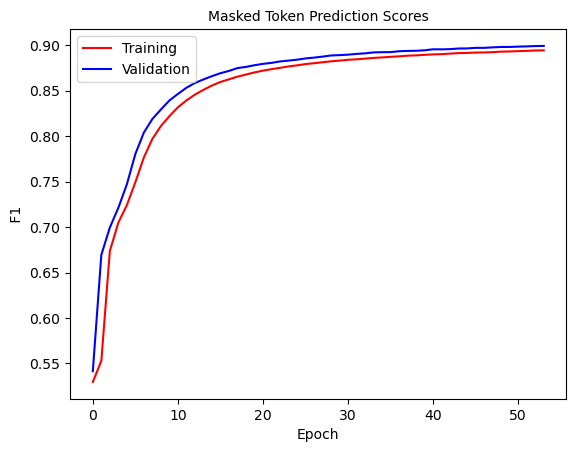

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 54: 100%|██████████| 445/445 [07:03<00:00,  1.05it/s, loss=0.195]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to

Training:   Instruction f1:  0.9374406072375061   Masked Token f1 0.8945774556739431     SEQ F1 0.9848660880359941


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:40<00:00,  2.76it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior

Validation:  Instruction F1:  0.8427894573938716    v_masked_token_ F1:  0.8991887003544803  V SEQ F1:  0.9858803965379684


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


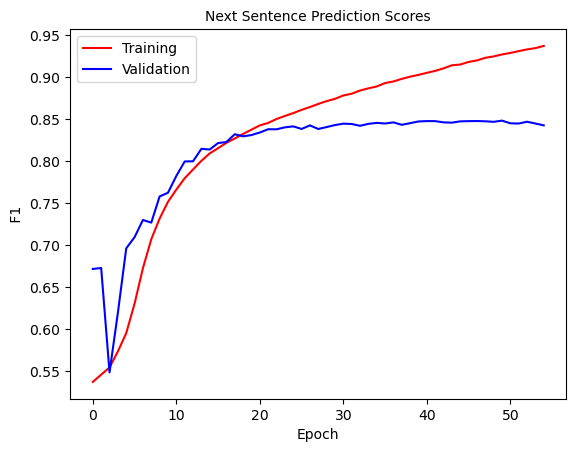

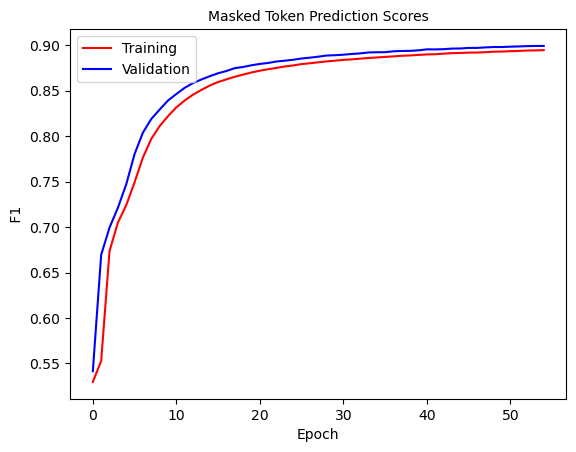

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 55: 100%|██████████| 445/445 [07:05<00:00,  1.05it/s, loss=0.229]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to

Training:   Instruction f1:  0.9392000377786173   Masked Token f1 0.8947252652897596     SEQ F1 0.9849309779892339


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:40<00:00,  2.74it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior

Validation:  Instruction F1:  0.845348293595138    v_masked_token_ F1:  0.8995329230189733  V SEQ F1:  0.9859321528953461


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


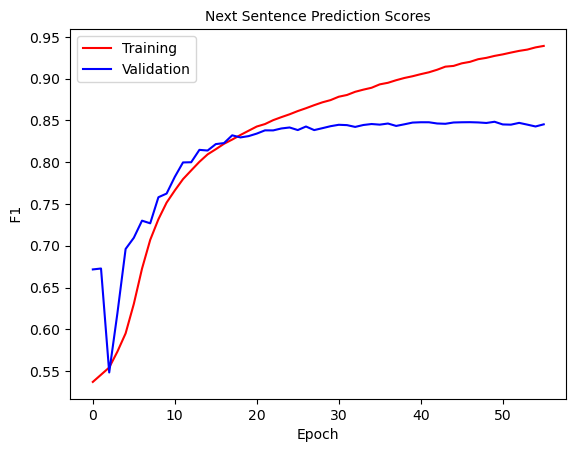

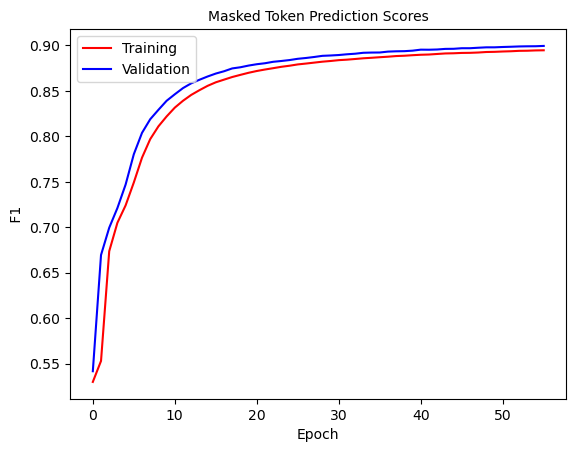

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 56: 100%|██████████| 445/445 [07:06<00:00,  1.04it/s, loss=0.201]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to

Training:   Instruction f1:  0.9409541134848118   Masked Token f1 0.8951204143241088     SEQ F1 0.9850171446287317


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:40<00:00,  2.76it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior

Validation:  Instruction F1:  0.8453497093568348    v_masked_token_ F1:  0.8991447044474131  V SEQ F1:  0.9859202002077905


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


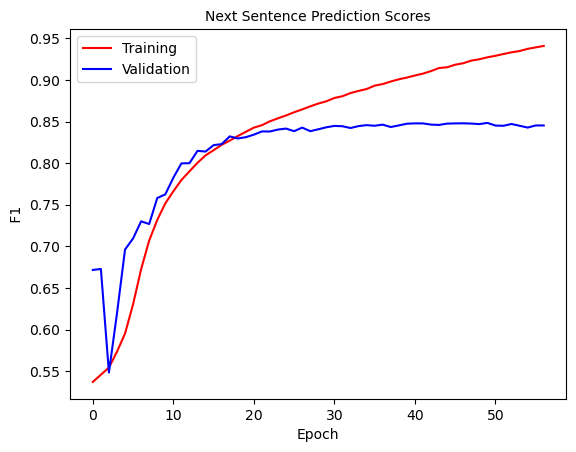

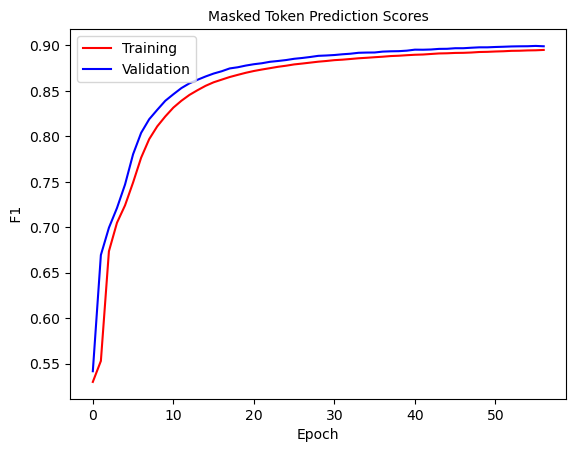

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 57: 100%|██████████| 445/445 [07:04<00:00,  1.05it/s, loss=0.172]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to

Training:   Instruction f1:  0.9422258428226515   Masked Token f1 0.8953685323919212     SEQ F1 0.9850642244000899


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:40<00:00,  2.78it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior

Validation:  Instruction F1:  0.8452526009935326    v_masked_token_ F1:  0.8995051843288622  V SEQ F1:  0.9859804942966066


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


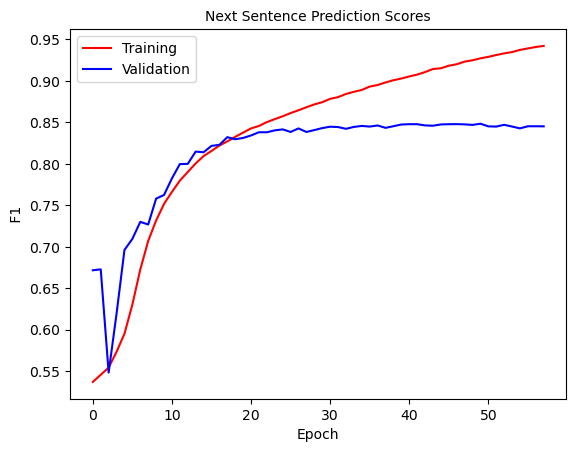

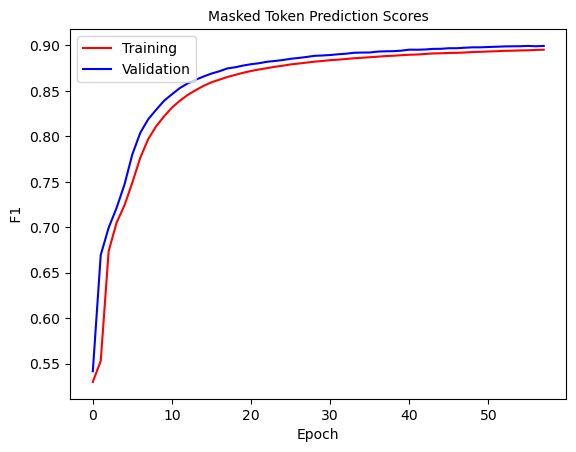

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 58: 100%|██████████| 445/445 [07:03<00:00,  1.05it/s, loss=0.129]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to

Training:   Instruction f1:  0.9443333510296295   Masked Token f1 0.8957261254317199     SEQ F1 0.9851505175694361


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:40<00:00,  2.76it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior

Validation:  Instruction F1:  0.8456765552927954    v_masked_token_ F1:  0.9002530831893533  V SEQ F1:  0.9860220406742503


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


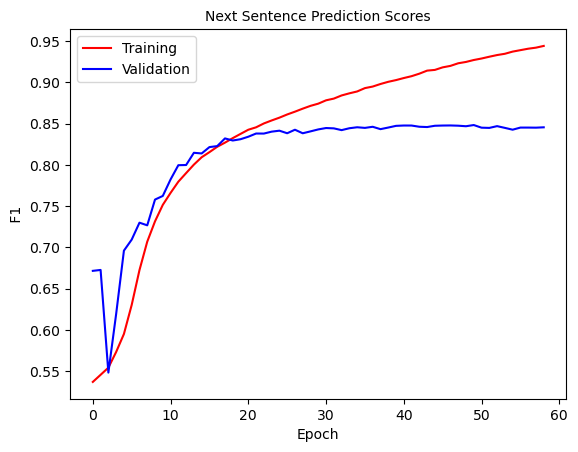

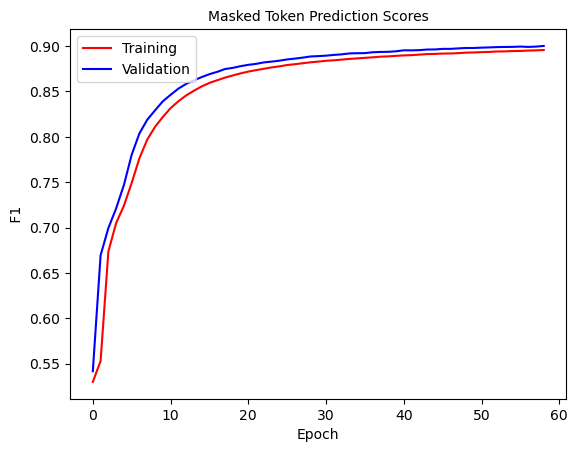

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 59: 100%|██████████| 445/445 [07:06<00:00,  1.04it/s, loss=0.295]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to

Training:   Instruction f1:  0.9466976623437924   Masked Token f1 0.8958632059546798     SEQ F1 0.9851916072652273


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:40<00:00,  2.75it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior

Validation:  Instruction F1:  0.8444954773398322    v_masked_token_ F1:  0.9004086336875808  V SEQ F1:  0.9860756803825648


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


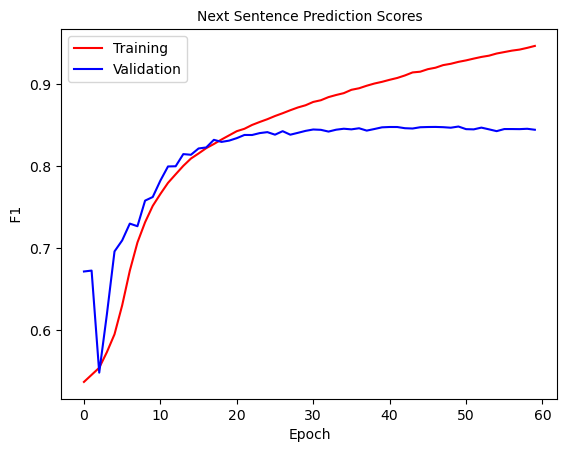

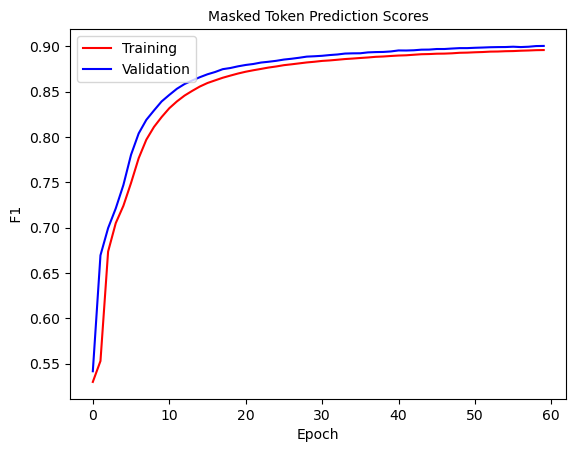

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 60: 100%|██████████| 445/445 [07:06<00:00,  1.04it/s, loss=0.304]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to

Training:   Instruction f1:  0.9475273153962722   Masked Token f1 0.8960869751947673     SEQ F1 0.985257694271092


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:41<00:00,  2.73it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior

Validation:  Instruction F1:  0.8451049198087657    v_masked_token_ F1:  0.9005443857437004  V SEQ F1:  0.9861293401541773


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


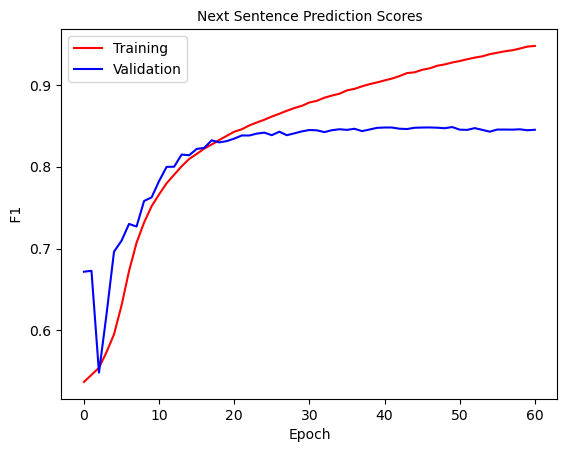

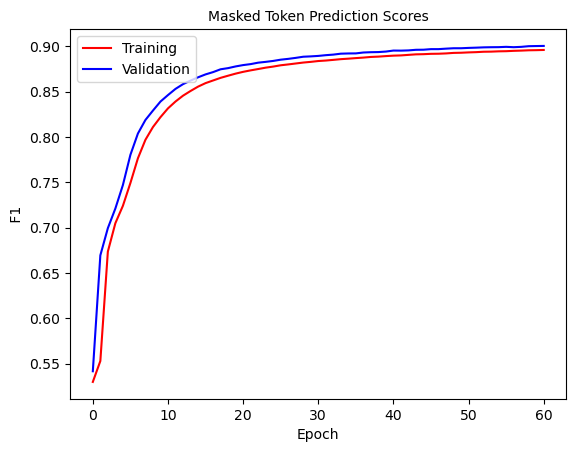

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 61: 100%|██████████| 445/445 [07:07<00:00,  1.04it/s, loss=0.208]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to

Training:   Instruction f1:  0.9493663424697908   Masked Token f1 0.8964505738503504     SEQ F1 0.9853343375728271


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:40<00:00,  2.75it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior

Validation:  Instruction F1:  0.8454570791527313    v_masked_token_ F1:  0.9009143558302675  V SEQ F1:  0.9861723413485052


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


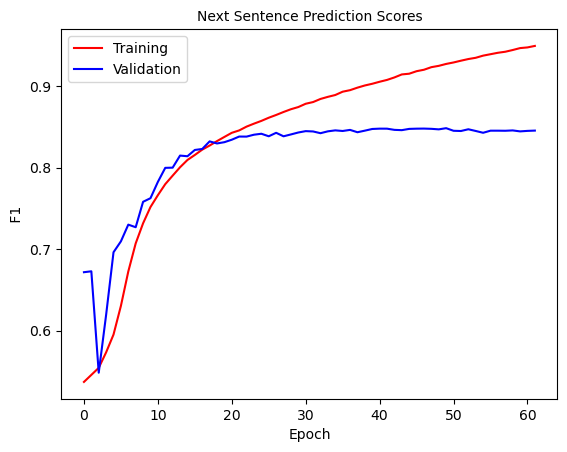

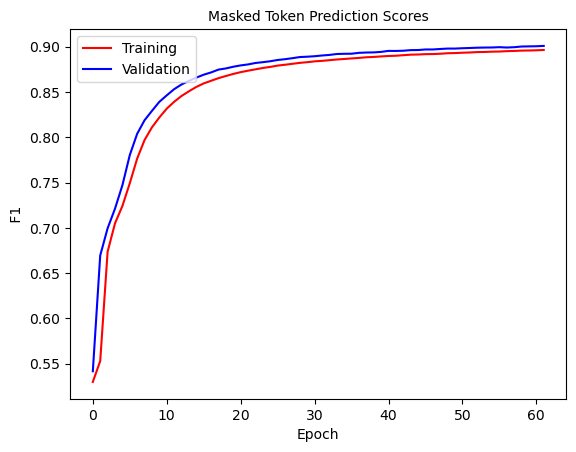

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 62: 100%|██████████| 445/445 [07:06<00:00,  1.04it/s, loss=0.102]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to

Training:   Instruction f1:  0.9511837196555809   Masked Token f1 0.8966716433645056     SEQ F1 0.9853802008673626


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:40<00:00,  2.75it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior

Validation:  Instruction F1:  0.8426931869064171    v_masked_token_ F1:  0.901172507311253  V SEQ F1:  0.9861866597059897


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


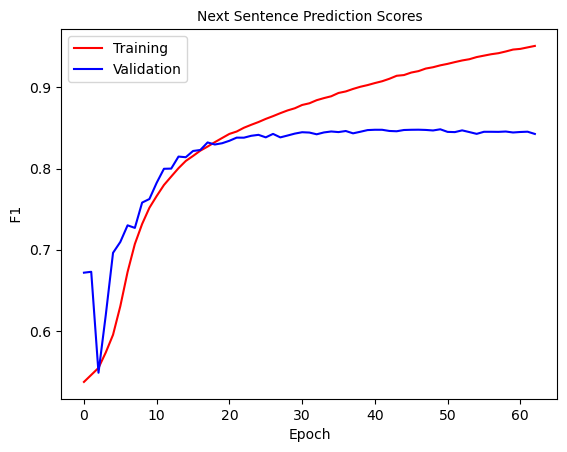

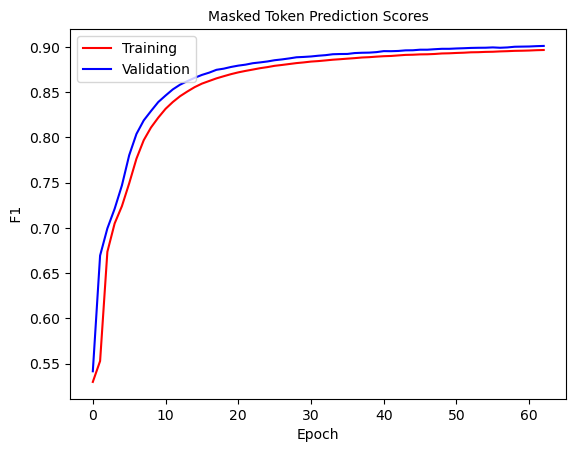

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 63: 100%|██████████| 445/445 [07:05<00:00,  1.04it/s, loss=0.164]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to

Training:   Instruction f1:  0.9522085914886844   Masked Token f1 0.896873107284946     SEQ F1 0.9854277940192068


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:40<00:00,  2.75it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior

Validation:  Instruction F1:  0.8453498342951169    v_masked_token_ F1:  0.90105672197371  V SEQ F1:  0.9862064835075129


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


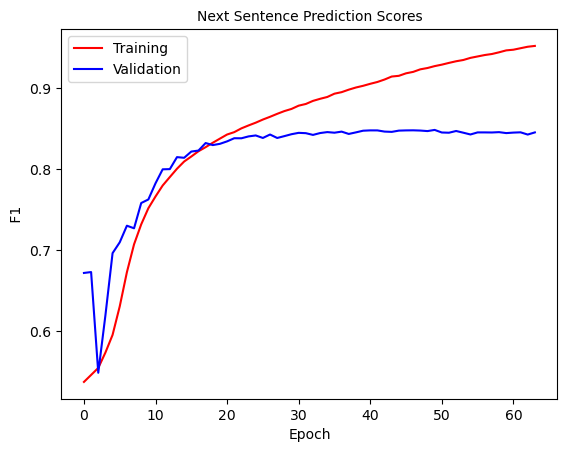

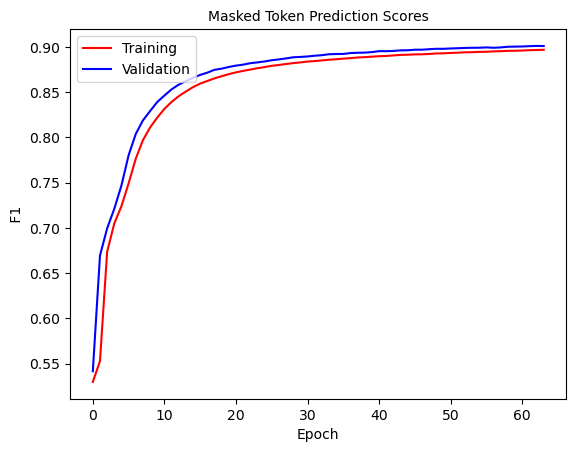

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 64: 100%|██████████| 445/445 [07:07<00:00,  1.04it/s, loss=0.174]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to

Training:   Instruction f1:  0.9535943479540772   Masked Token f1 0.8970247946871559     SEQ F1 0.9854755642232079


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:40<00:00,  2.75it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior

Validation:  Instruction F1:  0.8450737132309992    v_masked_token_ F1:  0.9016108854796667  V SEQ F1:  0.9862559775199441


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


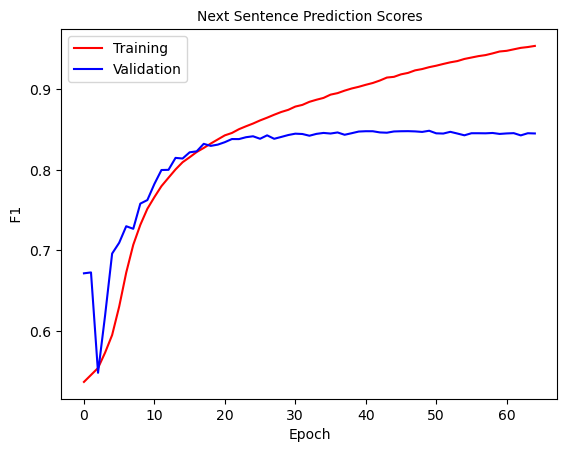

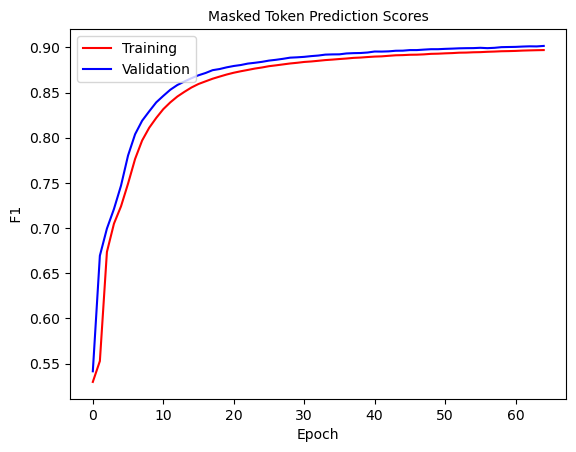

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 65: 100%|██████████| 445/445 [07:06<00:00,  1.04it/s, loss=0.105]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to

Training:   Instruction f1:  0.9550456608906082   Masked Token f1 0.8971662932129647     SEQ F1 0.9855182198971446


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:40<00:00,  2.75it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior

Validation:  Instruction F1:  0.8442932551319648    v_masked_token_ F1:  0.9015176079090369  V SEQ F1:  0.9863089507023618


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


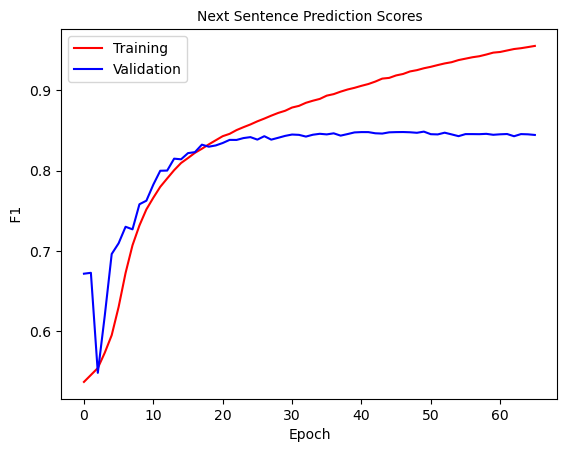

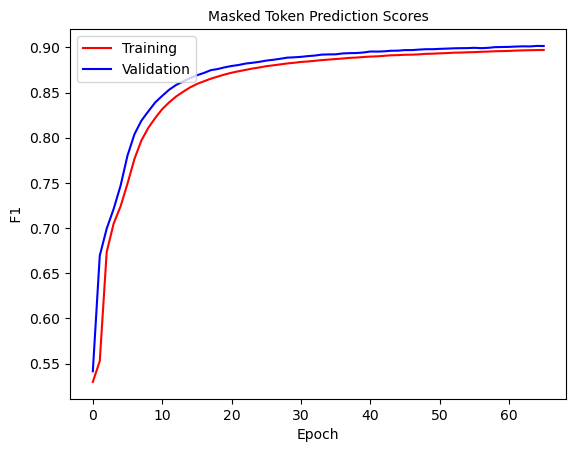

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 66: 100%|██████████| 445/445 [07:06<00:00,  1.04it/s, loss=0.119]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to

Training:   Instruction f1:  0.9567224738091172   Masked Token f1 0.8972777865849353     SEQ F1 0.9855544570280532


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:40<00:00,  2.76it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior

Validation:  Instruction F1:  0.84235815059943    v_masked_token_ F1:  0.9017693246761647  V SEQ F1:  0.9863407037211708


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


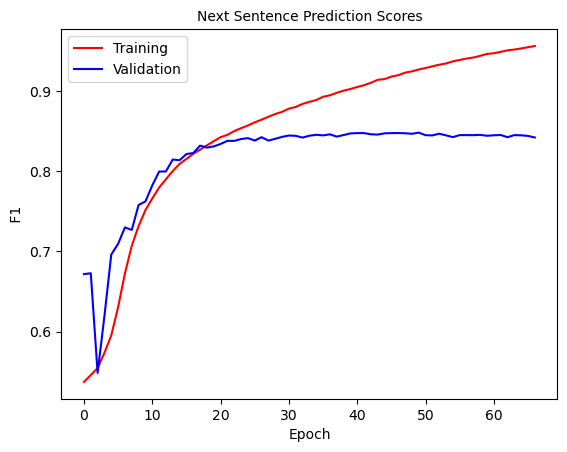

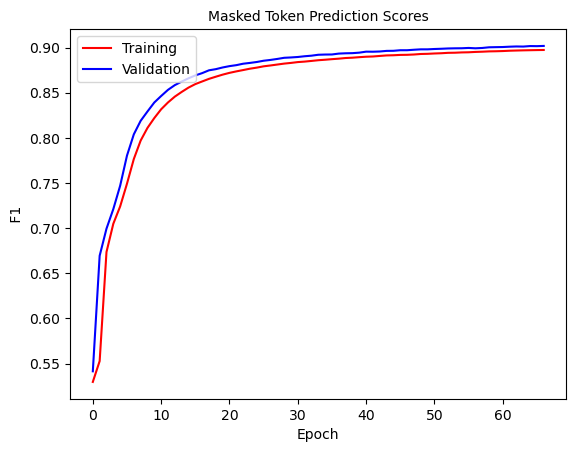

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 67: 100%|██████████| 445/445 [07:05<00:00,  1.05it/s, loss=0.129]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to

Training:   Instruction f1:  0.9578446611087561   Masked Token f1 0.8976719781206779     SEQ F1 0.9856101025273


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:40<00:00,  2.75it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior

Validation:  Instruction F1:  0.8430028502108213    v_masked_token_ F1:  0.9017477642854752  V SEQ F1:  0.9863677489688957


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


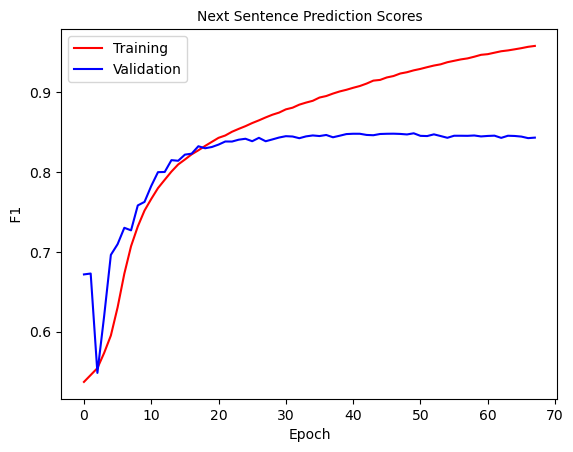

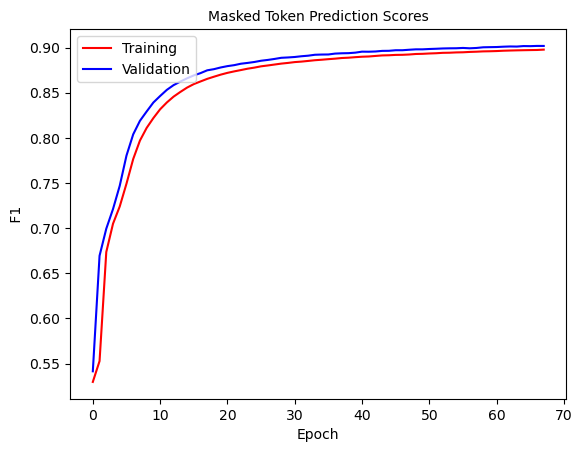

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 68: 100%|██████████| 445/445 [07:04<00:00,  1.05it/s, loss=0.161]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to

Training:   Instruction f1:  0.9585148724712089   Masked Token f1 0.8977821462484775     SEQ F1 0.9856538955740648


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:40<00:00,  2.76it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior

Validation:  Instruction F1:  0.844969978605443    v_masked_token_ F1:  0.902081390995542  V SEQ F1:  0.986368086031889


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


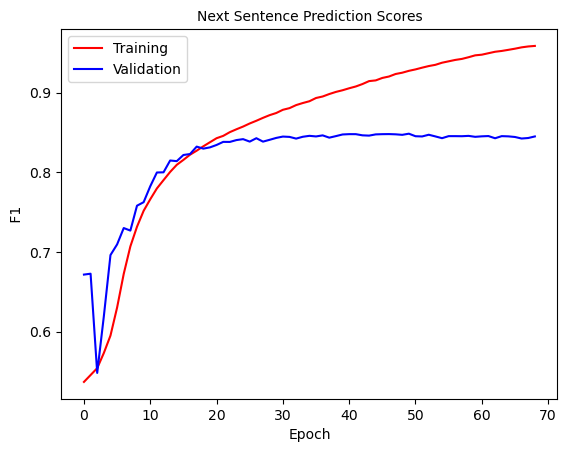

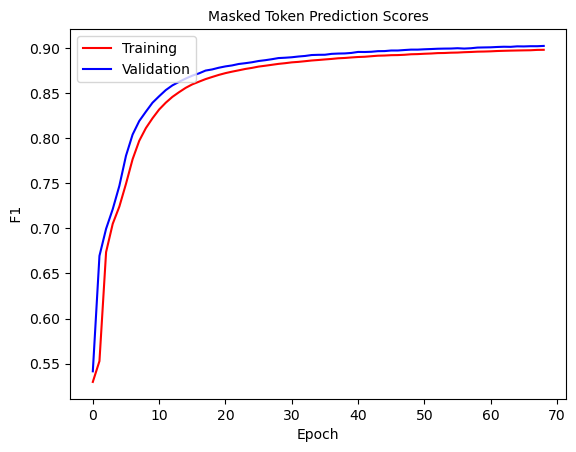

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 69: 100%|██████████| 445/445 [07:06<00:00,  1.04it/s, loss=0.262]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to

Training:   Instruction f1:  0.9599957623876592   Masked Token f1 0.8982113590140451     SEQ F1 0.9857209454158945


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:40<00:00,  2.75it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior

Validation:  Instruction F1:  0.8433565449813604    v_masked_token_ F1:  0.9021542216003912  V SEQ F1:  0.9863903784515081


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


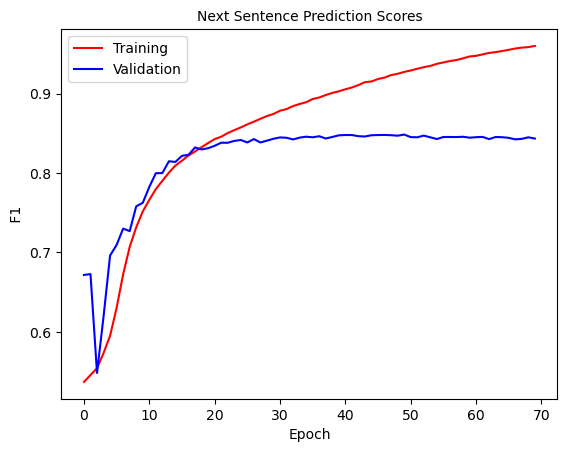

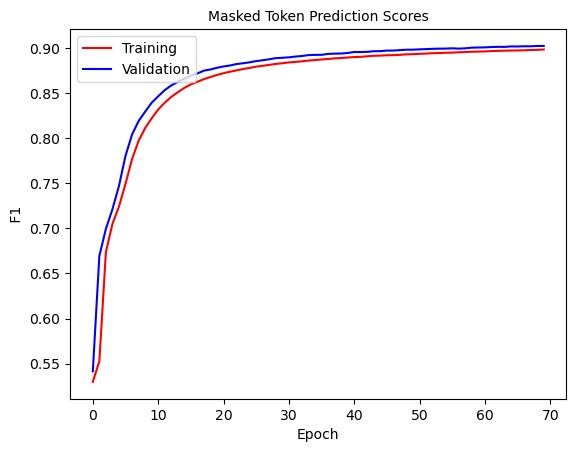

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 70: 100%|██████████| 445/445 [07:07<00:00,  1.04it/s, loss=0.175]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to

Training:   Instruction f1:  0.9608966141760064   Masked Token f1 0.898176983736709     SEQ F1 0.9857316117544278


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:40<00:00,  2.75it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior

Validation:  Instruction F1:  0.8444236614449381    v_masked_token_ F1:  0.9025373936111265  V SEQ F1:  0.9864514736390907


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


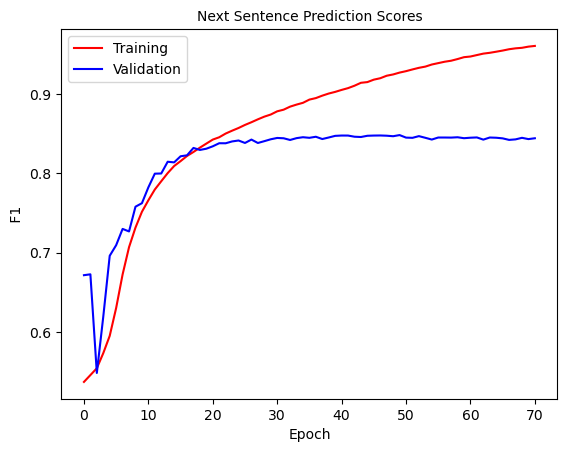

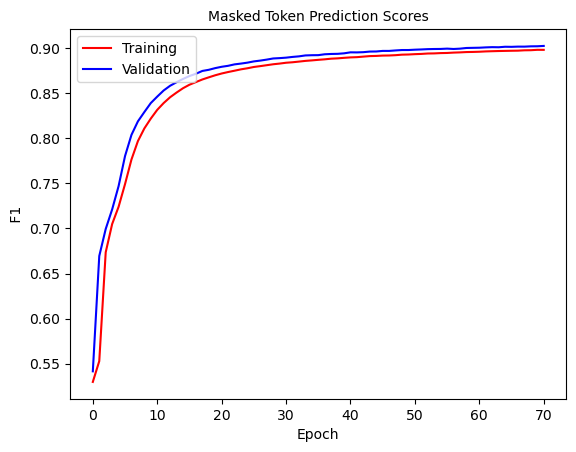

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 71: 100%|██████████| 445/445 [07:07<00:00,  1.04it/s, loss=0.109]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to

Training:   Instruction f1:  0.9629964960139219   Masked Token f1 0.8983192787169774     SEQ F1 0.985757201385956


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:40<00:00,  2.75it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior

Validation:  Instruction F1:  0.8431070811335496    v_masked_token_ F1:  0.9025193218976197  V SEQ F1:  0.9864578874683914


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


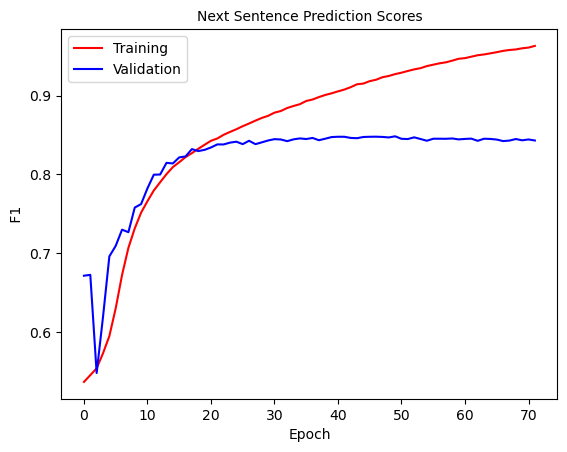

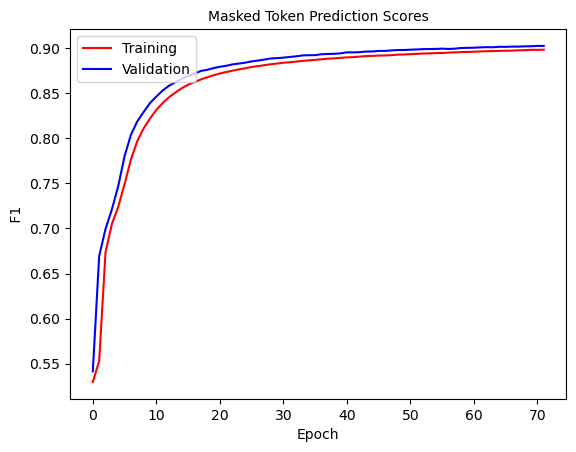

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 72: 100%|██████████| 445/445 [07:07<00:00,  1.04it/s, loss=0.162]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to

Training:   Instruction f1:  0.9639242515075642   Masked Token f1 0.898558255326136     SEQ F1 0.9858045674222209


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:40<00:00,  2.74it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior

Validation:  Instruction F1:  0.8448320565704184    v_masked_token_ F1:  0.902456415753061  V SEQ F1:  0.9864624458628335


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


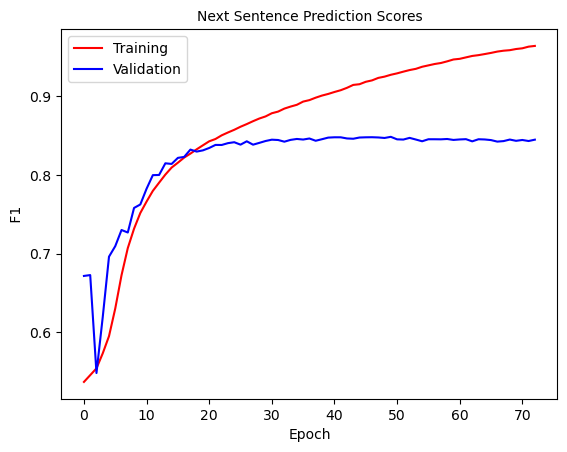

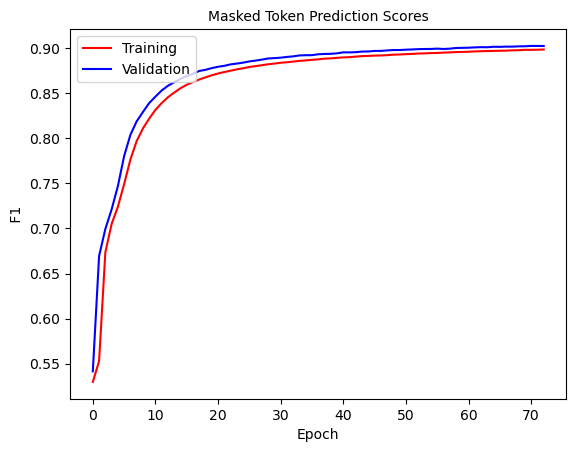

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 73: 100%|██████████| 445/445 [07:07<00:00,  1.04it/s, loss=0.128]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to

Training:   Instruction f1:  0.9647289852601377   Masked Token f1 0.8988645615150614     SEQ F1 0.9858467666071355


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:40<00:00,  2.75it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior

Validation:  Instruction F1:  0.8445146747844677    v_masked_token_ F1:  0.9029214837480185  V SEQ F1:  0.9865063833615331


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


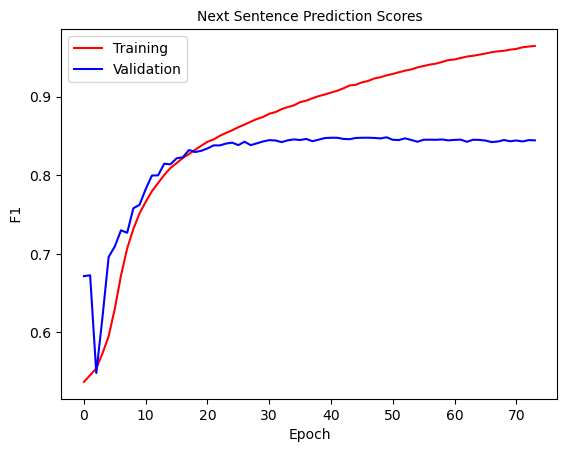

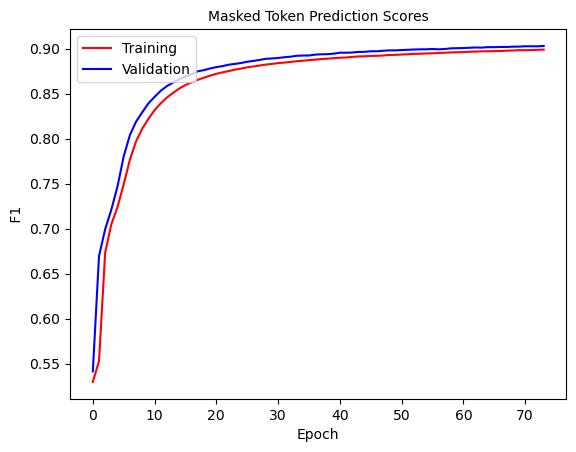

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 74: 100%|██████████| 445/445 [07:06<00:00,  1.04it/s, loss=0.159]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to

Training:   Instruction f1:  0.9657945793403492   Masked Token f1 0.8989746410542229     SEQ F1 0.9858777403222377


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:40<00:00,  2.74it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior

Validation:  Instruction F1:  0.842671955797974    v_masked_token_ F1:  0.9031106237251468  V SEQ F1:  0.986523172217607


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


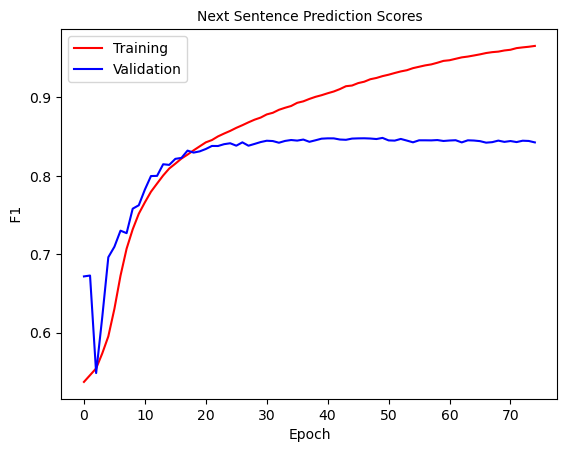

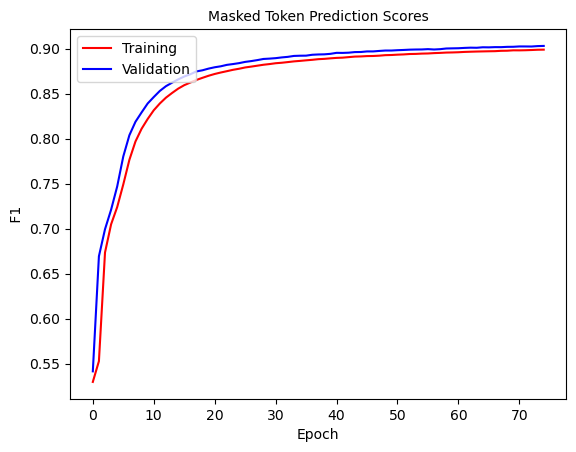

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 75: 100%|██████████| 445/445 [07:04<00:00,  1.05it/s, loss=0.127]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to

Training:   Instruction f1:  0.9662392936293788   Masked Token f1 0.8992168011080303     SEQ F1 0.9859266293550871


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:40<00:00,  2.78it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior

Validation:  Instruction F1:  0.8443488828643545    v_masked_token_ F1:  0.9030154986562959  V SEQ F1:  0.9865471760619244


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


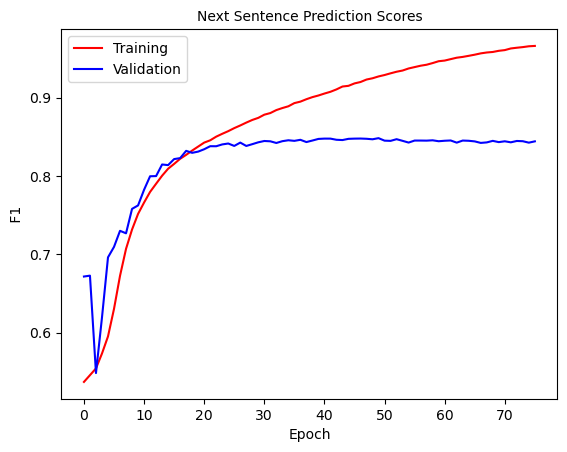

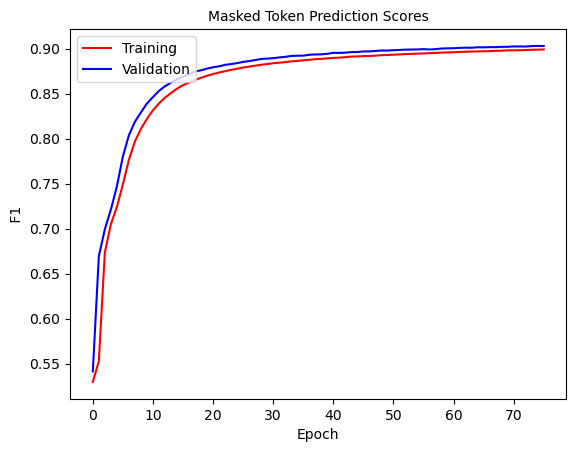

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 76: 100%|██████████| 445/445 [07:03<00:00,  1.05it/s, loss=0.139]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to

Training:   Instruction f1:  0.9680634148347935   Masked Token f1 0.8993345623755808     SEQ F1 0.9859498206982241


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:40<00:00,  2.75it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior

Validation:  Instruction F1:  0.842661282749554    v_masked_token_ F1:  0.9033077288451977  V SEQ F1:  0.9865872079836615


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


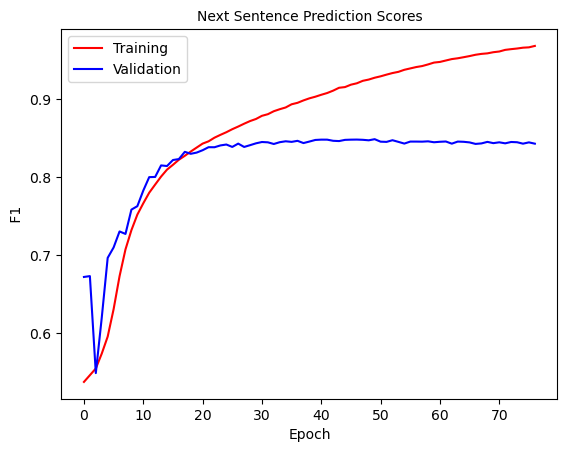

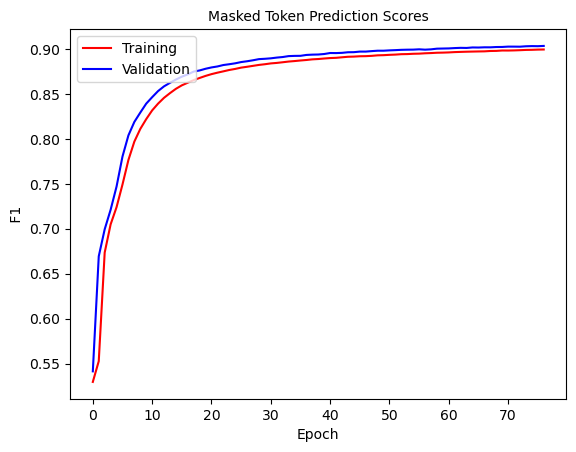

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 77: 100%|██████████| 445/445 [07:02<00:00,  1.05it/s, loss=0.149]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to

Training:   Instruction f1:  0.9682896878323355   Masked Token f1 0.8996194119727179     SEQ F1 0.9860004149477813


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:40<00:00,  2.76it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior

Validation:  Instruction F1:  0.8437719585890289    v_masked_token_ F1:  0.9034885684007012  V SEQ F1:  0.98659576970588


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


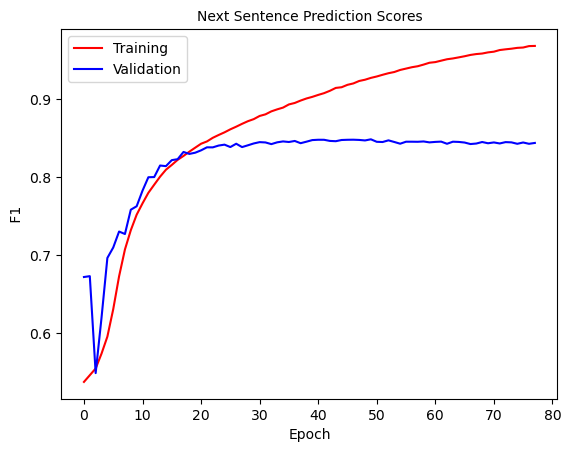

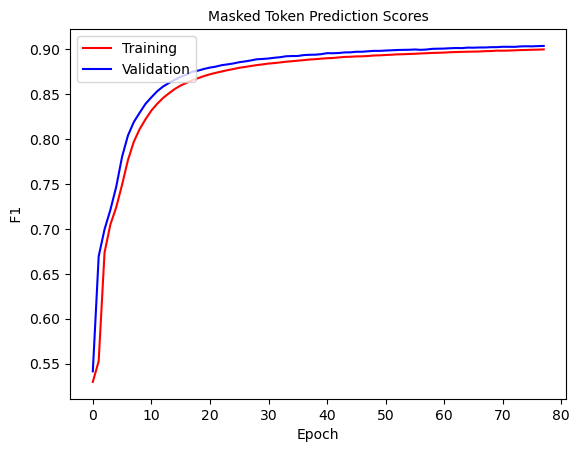

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 78: 100%|██████████| 445/445 [07:03<00:00,  1.05it/s, loss=0.123]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to

Training:   Instruction f1:  0.9695744655847132   Masked Token f1 0.8996105883630253     SEQ F1 0.9860003476120629


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:40<00:00,  2.78it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior

Validation:  Instruction F1:  0.844726289284715    v_masked_token_ F1:  0.9036421552972944  V SEQ F1:  0.9866439357957097


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


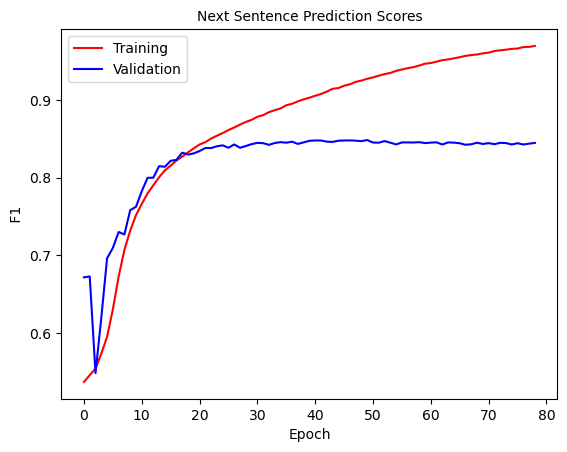

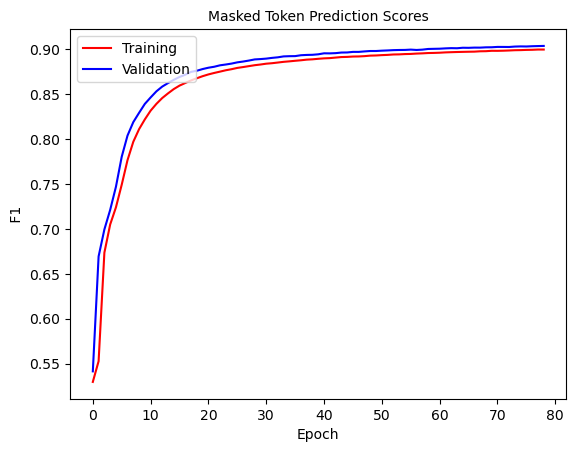

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 79: 100%|██████████| 445/445 [07:02<00:00,  1.05it/s, loss=0.0837]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter t

Training:   Instruction f1:  0.970671834625323   Masked Token f1 0.8998793870250553     SEQ F1 0.986055680598259


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:40<00:00,  2.77it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior

Validation:  Instruction F1:  0.8445665843774744    v_masked_token_ F1:  0.9038174312553988  V SEQ F1:  0.9866624491619505


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


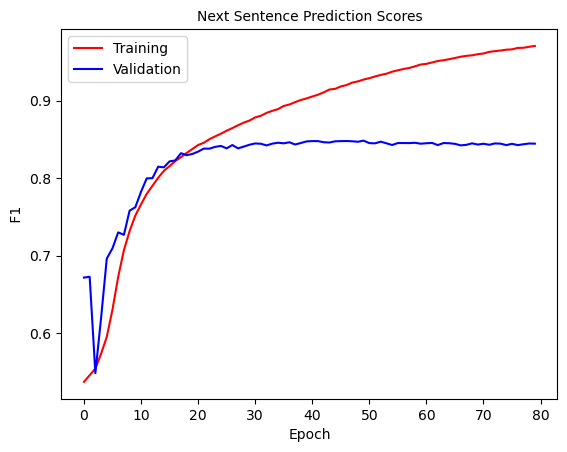

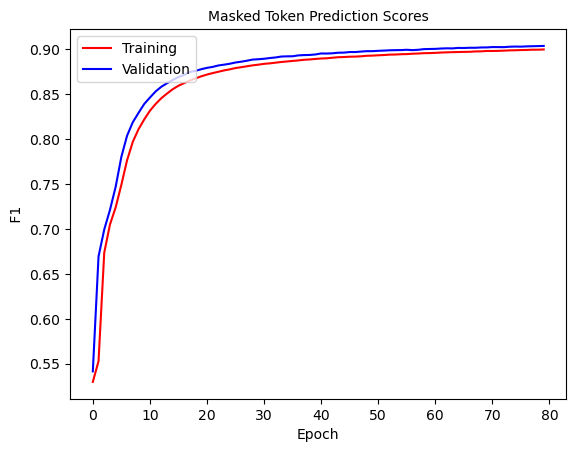

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 80: 100%|██████████| 445/445 [07:04<00:00,  1.05it/s, loss=0.0972]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter t

Training:   Instruction f1:  0.9713436587786842   Masked Token f1 0.9000976161419004     SEQ F1 0.9860823525786179


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:40<00:00,  2.76it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior

Validation:  Instruction F1:  0.843977214838142    v_masked_token_ F1:  0.9036300813543201  V SEQ F1:  0.9866696136019968


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


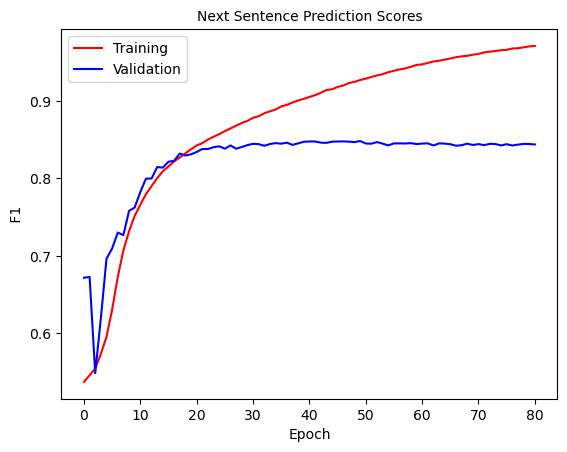

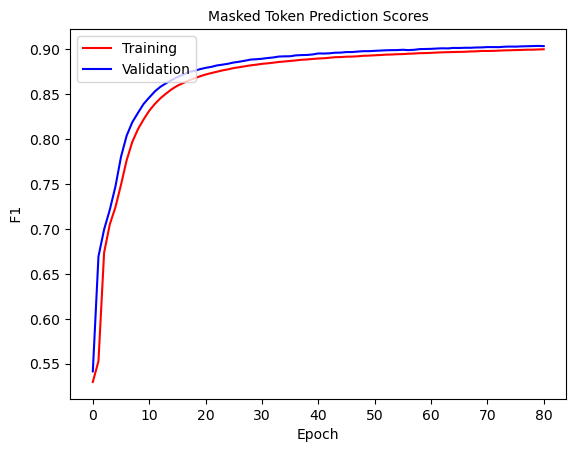

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 81: 100%|██████████| 445/445 [07:04<00:00,  1.05it/s, loss=0.106] 
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter t

Training:   Instruction f1:  0.9715060421276271   Masked Token f1 0.9001342781983637     SEQ F1 0.9861017174712413


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:40<00:00,  2.74it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior

Validation:  Instruction F1:  0.8435151146182125    v_masked_token_ F1:  0.9040339357953804  V SEQ F1:  0.9866903110572622


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


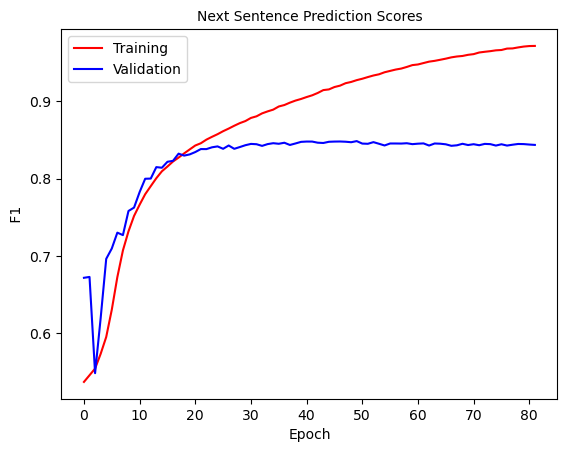

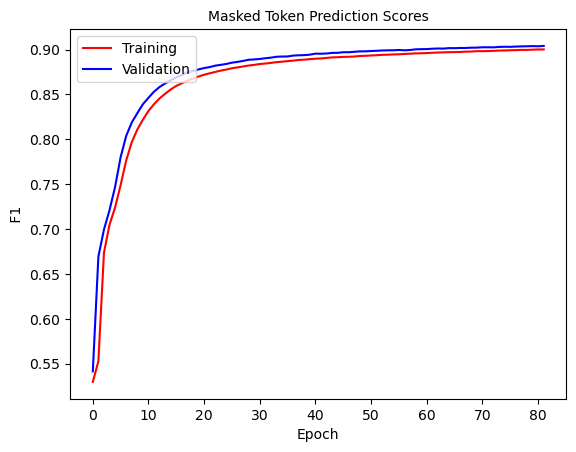

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 82: 100%|██████████| 445/445 [07:07<00:00,  1.04it/s, loss=0.128] 
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter t

Training:   Instruction f1:  0.9733099323209852   Masked Token f1 0.9005341117290714     SEQ F1 0.9861521776120447


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:40<00:00,  2.75it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior

Validation:  Instruction F1:  0.8422218556312304    v_masked_token_ F1:  0.903998858029111  V SEQ F1:  0.9867282903527814


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


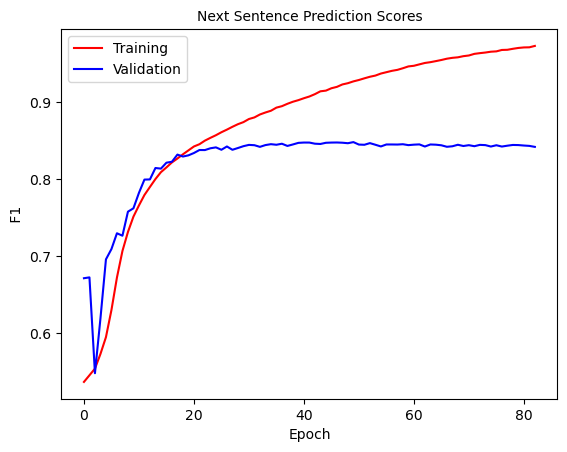

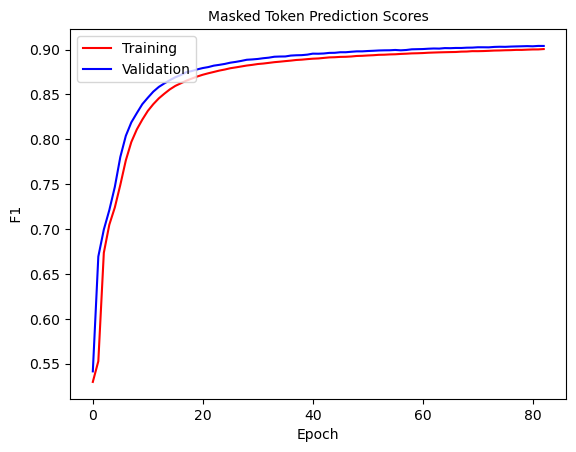

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 83: 100%|██████████| 445/445 [07:05<00:00,  1.05it/s, loss=0.149] 
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter t

Training:   Instruction f1:  0.9740389357255242   Masked Token f1 0.9008497585539058     SEQ F1 0.9862115483484439


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:40<00:00,  2.76it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior

Validation:  Instruction F1:  0.8440204746393671    v_masked_token_ F1:  0.9041128467781123  V SEQ F1:  0.9867446328906408


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


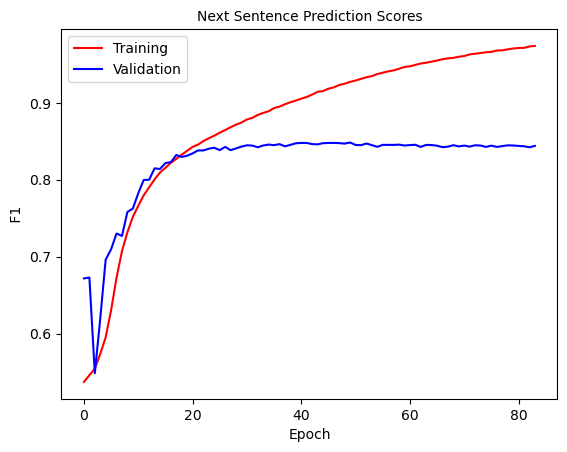

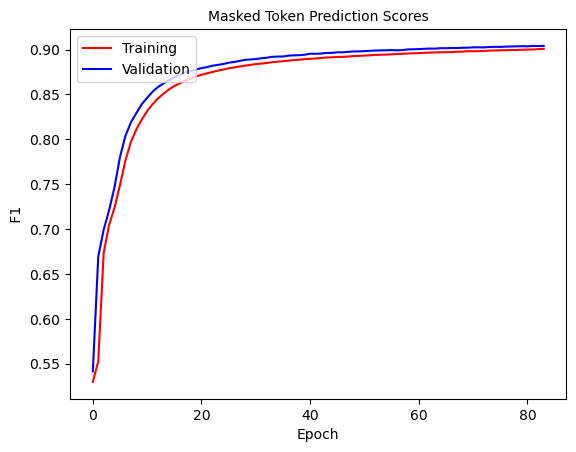

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 84: 100%|██████████| 445/445 [07:04<00:00,  1.05it/s, loss=0.0834]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter t

Training:   Instruction f1:  0.9739922205469085   Masked Token f1 0.9007339887287265     SEQ F1 0.9861947592150837


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:40<00:00,  2.76it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior

Validation:  Instruction F1:  0.8415364189047542    v_masked_token_ F1:  0.9043505916752741  V SEQ F1:  0.9867713891830417


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


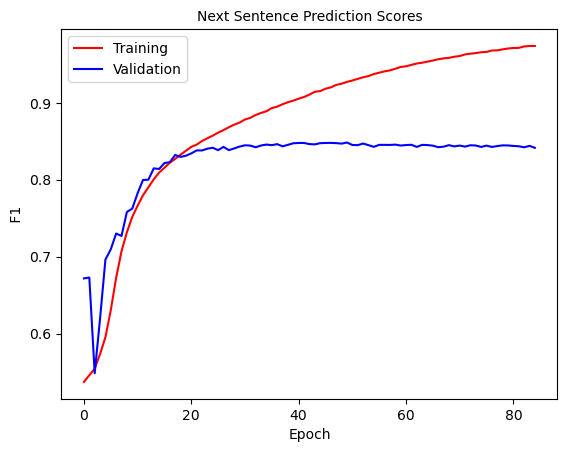

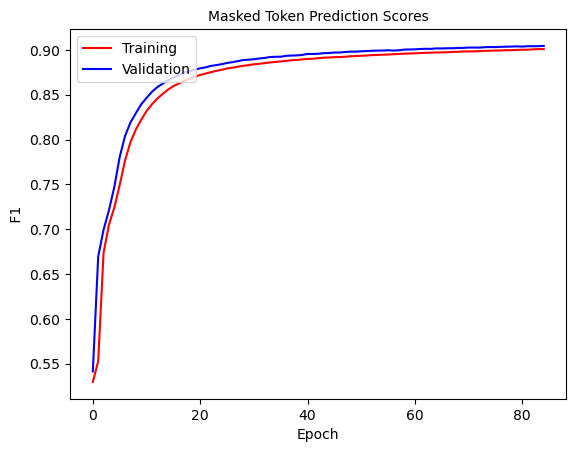

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 85: 100%|██████████| 445/445 [07:05<00:00,  1.05it/s, loss=0.0969]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter t

Training:   Instruction f1:  0.9752269832792407   Masked Token f1 0.900970413880832     SEQ F1 0.9862244558231279


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:40<00:00,  2.76it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior

Validation:  Instruction F1:  0.844137483486685    v_masked_token_ F1:  0.904712775024632  V SEQ F1:  0.9868130648400428


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


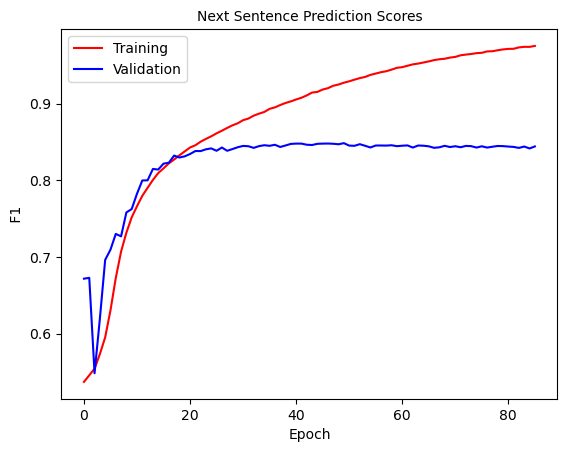

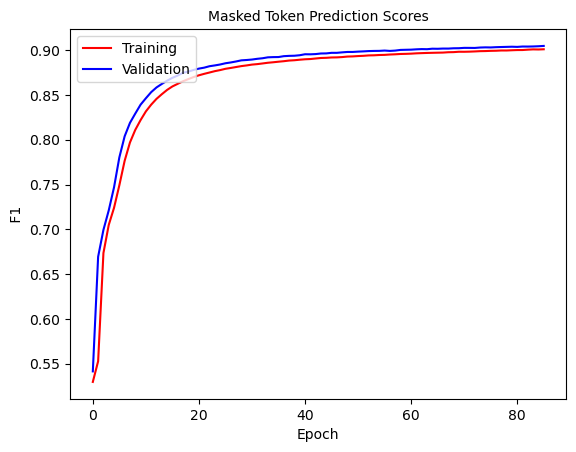

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 86: 100%|██████████| 445/445 [07:04<00:00,  1.05it/s, loss=0.0803]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter t

Training:   Instruction f1:  0.9755828616674975   Masked Token f1 0.9011489174628317     SEQ F1 0.9862530525051965


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:40<00:00,  2.75it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior

Validation:  Instruction F1:  0.8430237940931395    v_masked_token_ F1:  0.9047788571591947  V SEQ F1:  0.9868322000709626


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


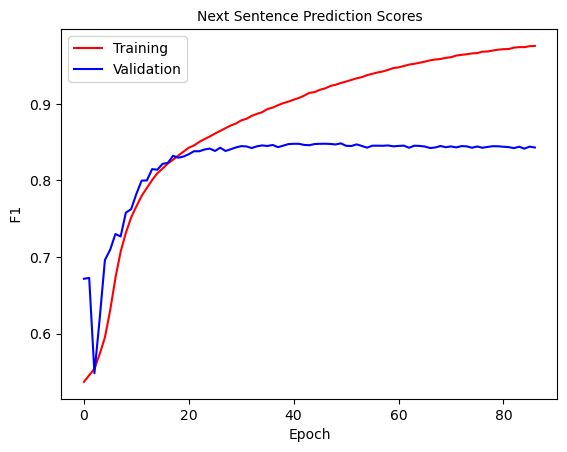

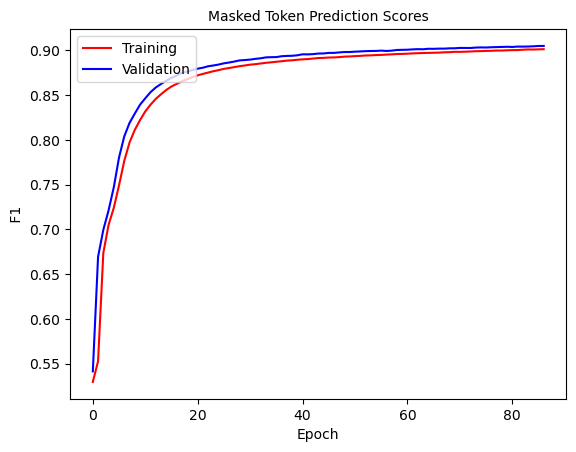

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 87: 100%|██████████| 445/445 [07:05<00:00,  1.05it/s, loss=0.154] 
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter t

Training:   Instruction f1:  0.9767433678136654   Masked Token f1 0.9015224241561061     SEQ F1 0.9863075015765252


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:40<00:00,  2.76it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior

Validation:  Instruction F1:  0.8434253626579317    v_masked_token_ F1:  0.9047977153011966  V SEQ F1:  0.9868487269698182


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


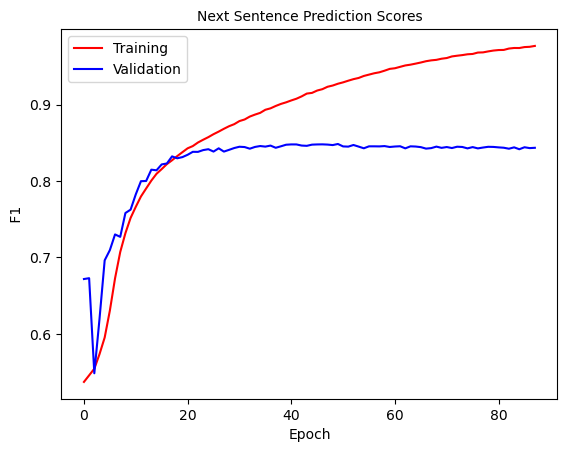

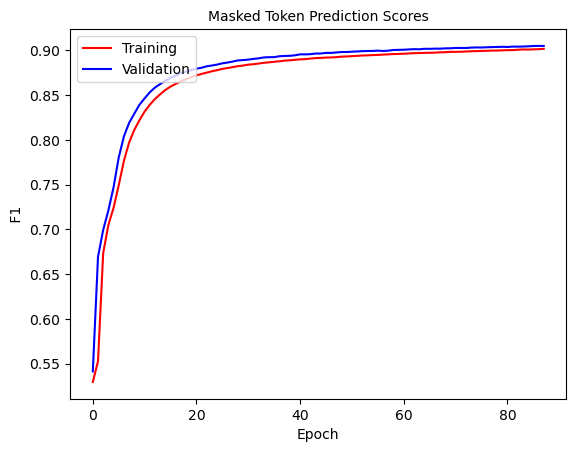

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 88: 100%|██████████| 445/445 [07:03<00:00,  1.05it/s, loss=0.106] 
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter t

Training:   Instruction f1:  0.9768982703019642   Masked Token f1 0.9015311696712699     SEQ F1 0.9863157386052664


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:40<00:00,  2.75it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior

Validation:  Instruction F1:  0.8436099949194032    v_masked_token_ F1:  0.9050399334590429  V SEQ F1:  0.9868808855758433


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


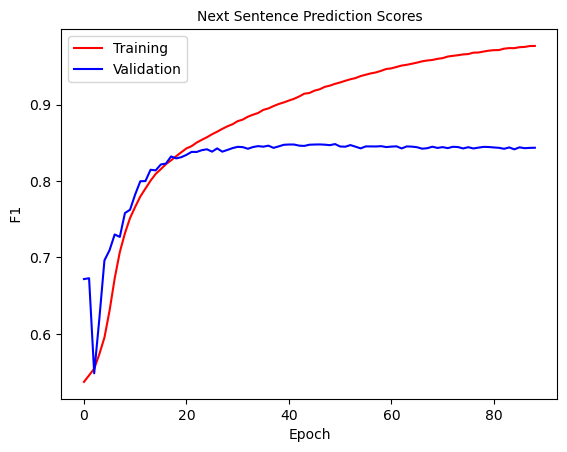

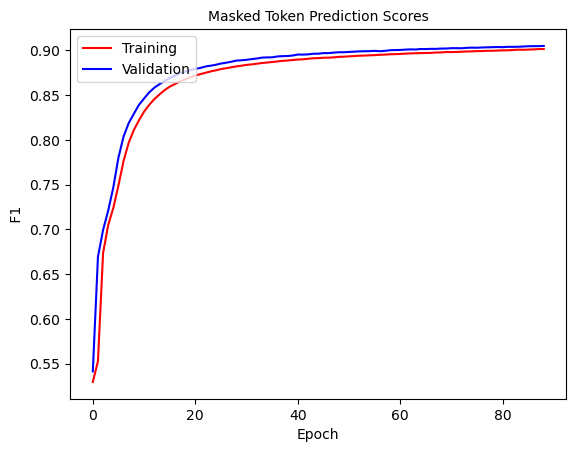

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 89: 100%|██████████| 445/445 [07:03<00:00,  1.05it/s, loss=0.234] 
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter t

Training:   Instruction f1:  0.977638068651657   Masked Token f1 0.901762745534939     SEQ F1 0.9863618685485929


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:40<00:00,  2.76it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior

Validation:  Instruction F1:  0.8448295782784517    v_masked_token_ F1:  0.9051910164901671  V SEQ F1:  0.9868980269291189


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


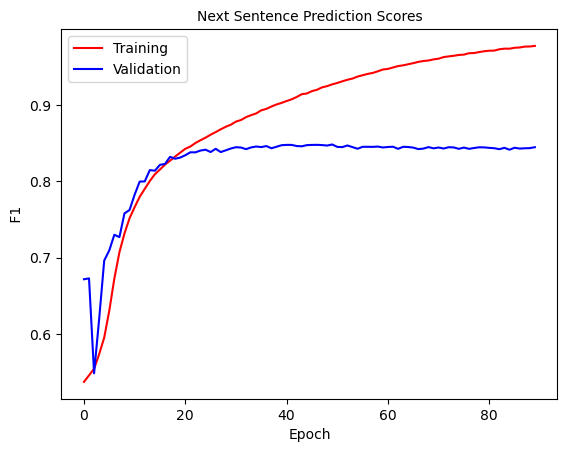

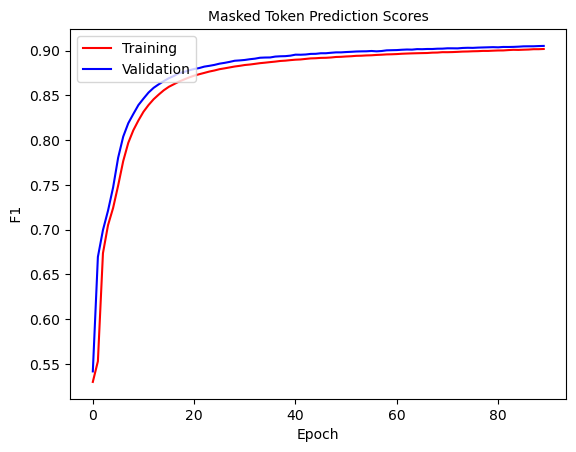

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 90: 100%|██████████| 445/445 [07:03<00:00,  1.05it/s, loss=0.24]  
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter t

Training:   Instruction f1:  0.9778710482968035   Masked Token f1 0.9017538353938928     SEQ F1 0.9863629718856638


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:40<00:00,  2.76it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior

Validation:  Instruction F1:  0.8422658156560916    v_masked_token_ F1:  0.9052678021691749  V SEQ F1:  0.9869167443929691


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


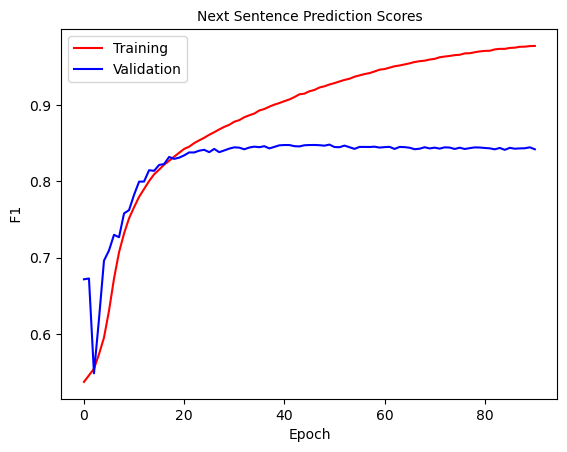

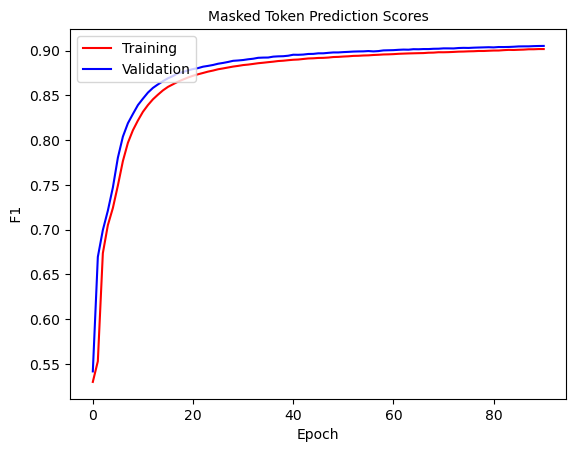

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 91: 100%|██████████| 445/445 [07:04<00:00,  1.05it/s, loss=0.0961]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter t

Training:   Instruction f1:  0.9786193756412136   Masked Token f1 0.9020249024370703     SEQ F1 0.9864035964951824


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:40<00:00,  2.76it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior

Validation:  Instruction F1:  0.8441170986388216    v_masked_token_ F1:  0.9053719330506933  V SEQ F1:  0.9869383086288387


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


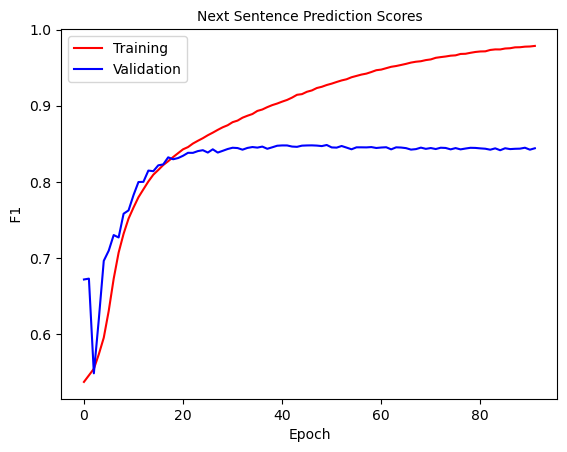

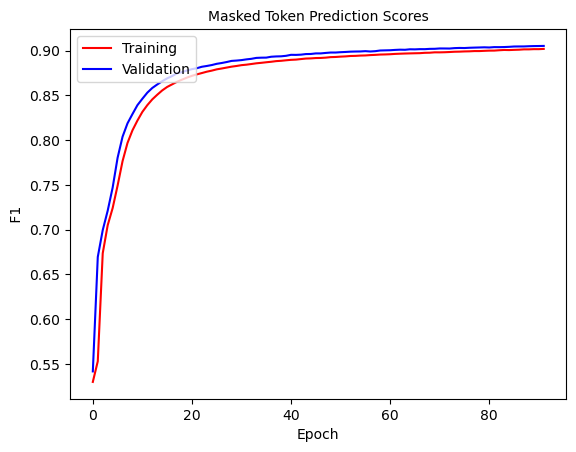

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 92: 100%|██████████| 445/445 [07:03<00:00,  1.05it/s, loss=0.0845]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter t

Training:   Instruction f1:  0.9794047123518963   Masked Token f1 0.902430363947711     SEQ F1 0.9864578337083326


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:40<00:00,  2.77it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior

Validation:  Instruction F1:  0.8441898978746895    v_masked_token_ F1:  0.9055012279625805  V SEQ F1:  0.9869489682573394


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


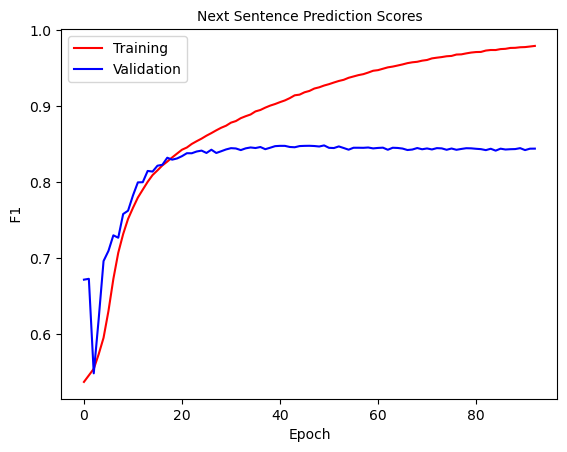

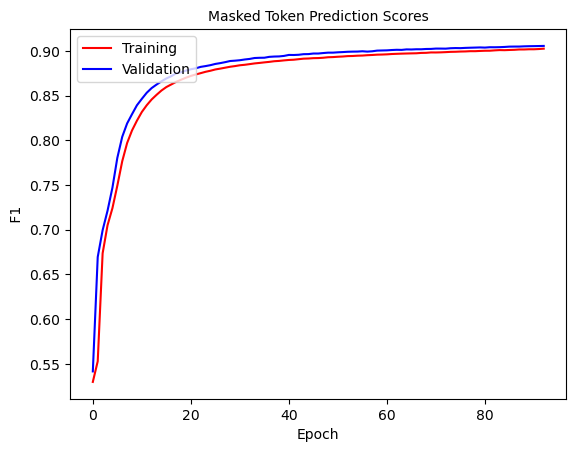

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 93: 100%|██████████| 445/445 [07:03<00:00,  1.05it/s, loss=0.14]  
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter t

Training:   Instruction f1:  0.9801395157981124   Masked Token f1 0.9024442599933131     SEQ F1 0.9864715201645865


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:40<00:00,  2.75it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior

Validation:  Instruction F1:  0.842339285296389    v_masked_token_ F1:  0.9057557315969473  V SEQ F1:  0.9869819791395449


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


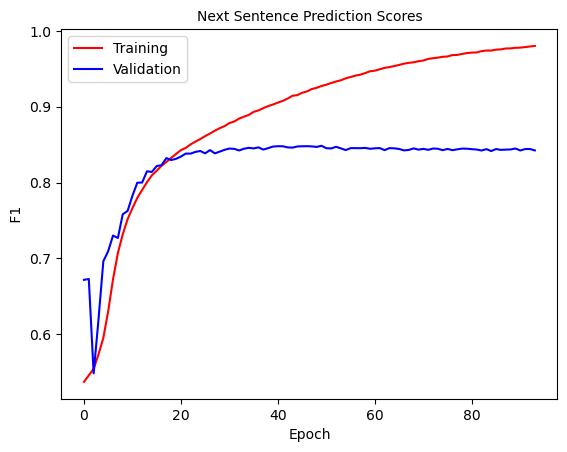

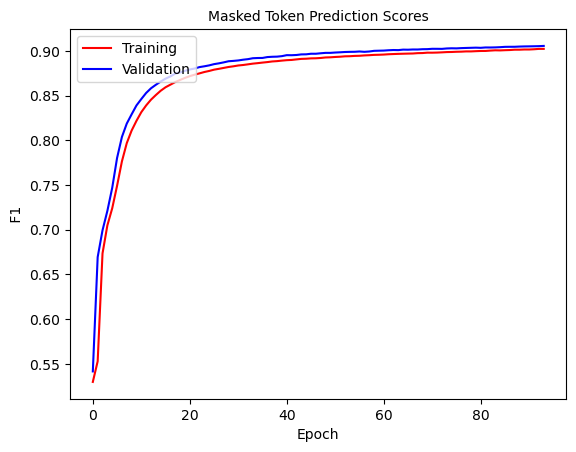

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 94: 100%|██████████| 445/445 [07:04<00:00,  1.05it/s, loss=0.203] 
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter t

Training:   Instruction f1:  0.9801097072130148   Masked Token f1 0.9024173661407381     SEQ F1 0.9864661211833334


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:40<00:00,  2.75it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior

Validation:  Instruction F1:  0.8443187924951517    v_masked_token_ F1:  0.9059825411207818  V SEQ F1:  0.9870250404708971


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


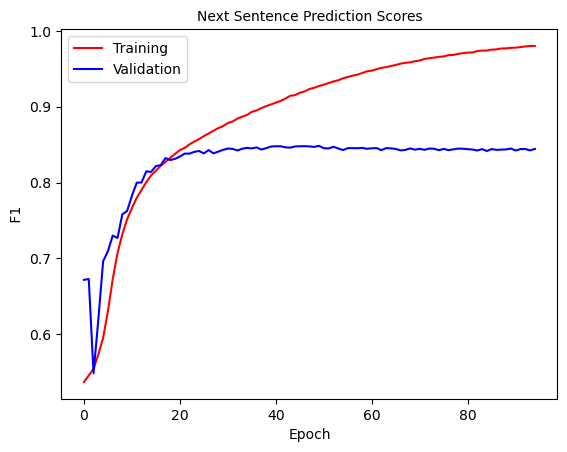

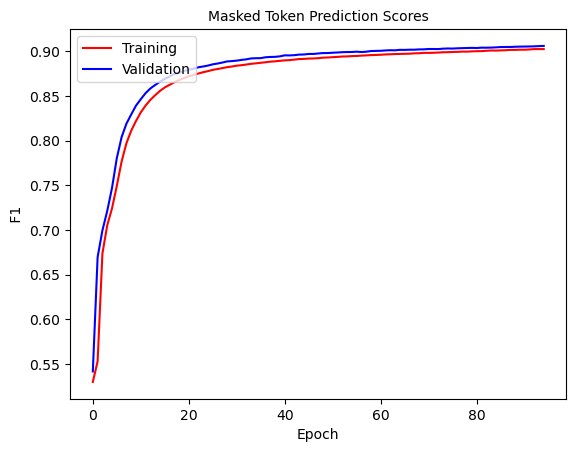

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 95: 100%|██████████| 445/445 [07:07<00:00,  1.04it/s, loss=0.0744]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter t

Training:   Instruction f1:  0.9806105223670637   Masked Token f1 0.9026082407936977     SEQ F1 0.986499178010243


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:41<00:00,  2.73it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior

Validation:  Instruction F1:  0.8452686017798071    v_masked_token_ F1:  0.9059943431690941  V SEQ F1:  0.9870197137171254


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


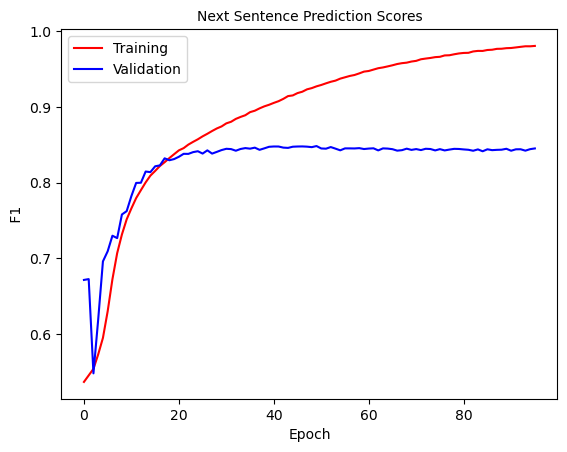

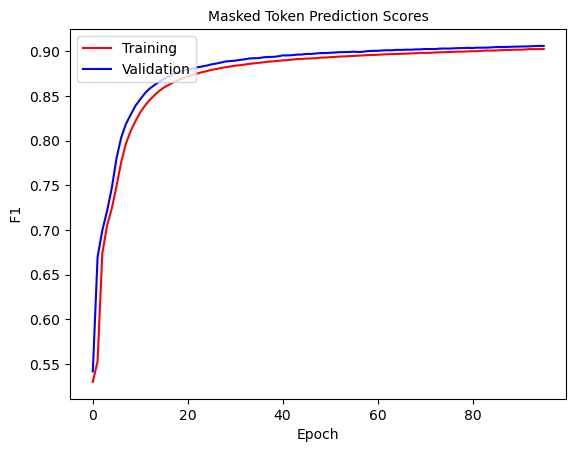

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 96: 100%|██████████| 445/445 [07:06<00:00,  1.04it/s, loss=0.0588]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter t

Training:   Instruction f1:  0.9812904435899841   Masked Token f1 0.9029683877201351     SEQ F1 0.9865486854958581


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:40<00:00,  2.76it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior

Validation:  Instruction F1:  0.8436240678123118    v_masked_token_ F1:  0.9060974406762522  V SEQ F1:  0.9870536073587922


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


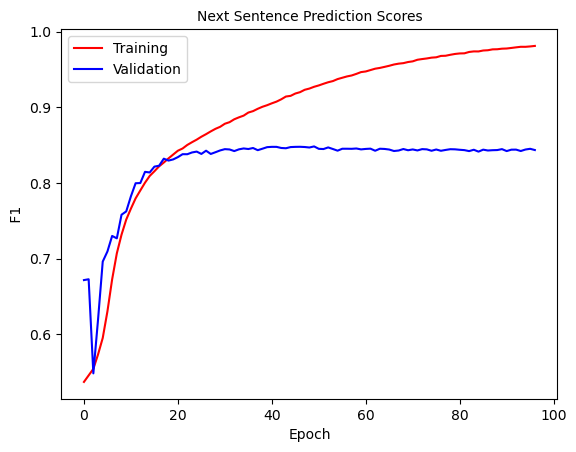

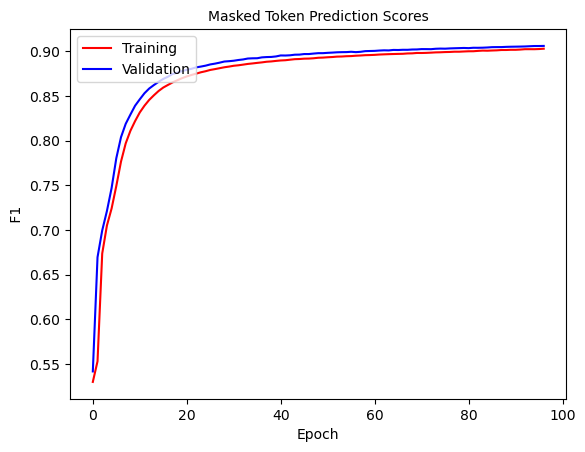

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 97: 100%|██████████| 445/445 [07:07<00:00,  1.04it/s, loss=0.145] 
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter t

Training:   Instruction f1:  0.9821172140131644   Masked Token f1 0.9032631652098913     SEQ F1 0.9865974613276172


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:40<00:00,  2.74it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior

Validation:  Instruction F1:  0.8443937524731734    v_masked_token_ F1:  0.9061368351273558  V SEQ F1:  0.9870500863732006


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


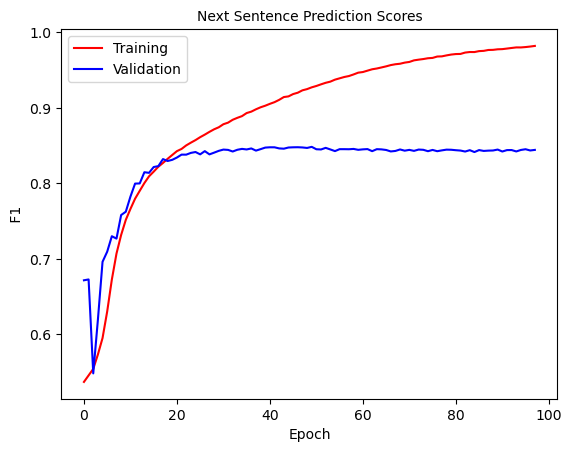

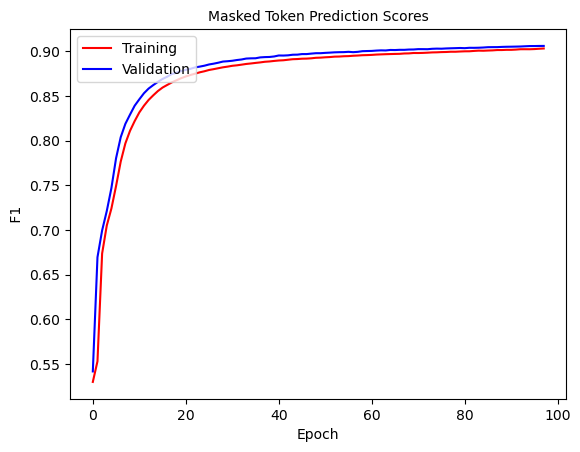

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 98: 100%|██████████| 445/445 [07:07<00:00,  1.04it/s, loss=0.109] 
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter t

Training:   Instruction f1:  0.982252195770761   Masked Token f1 0.9031220365309232     SEQ F1 0.9865691862718808


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:40<00:00,  2.74it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior

Validation:  Instruction F1:  0.8437937144455843    v_masked_token_ F1:  0.9062721074798081  V SEQ F1:  0.9870730130737139


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


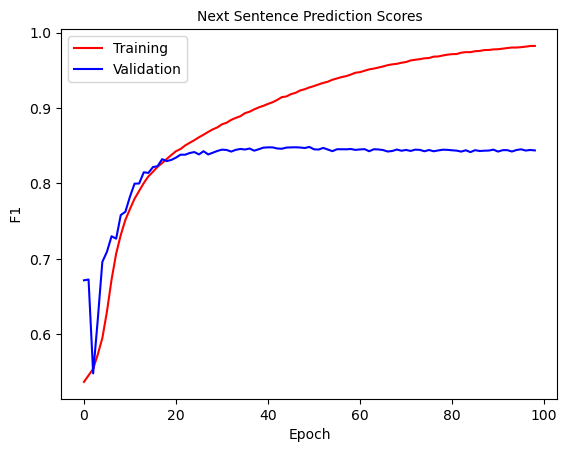

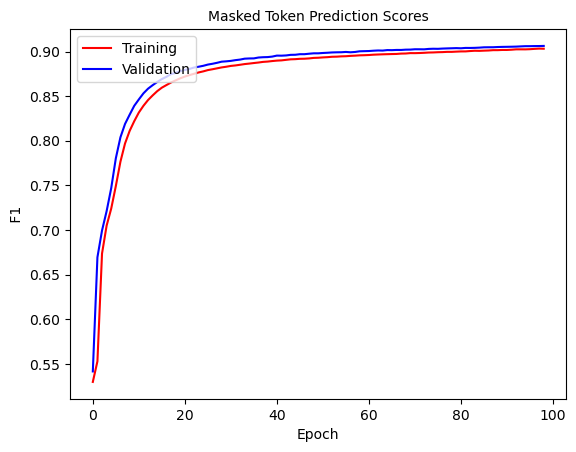

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 99: 100%|██████████| 445/445 [07:07<00:00,  1.04it/s, loss=0.0951]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter t

Training:   Instruction f1:  0.9831380360909304   Masked Token f1 0.9033220879059017     SEQ F1 0.9866104432525131


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:40<00:00,  2.74it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior

Validation:  Instruction F1:  0.8438928804702809    v_masked_token_ F1:  0.9065201952725847  V SEQ F1:  0.9871097564530446


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


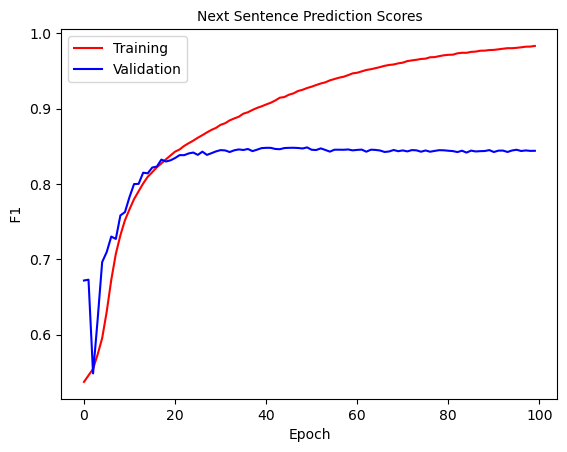

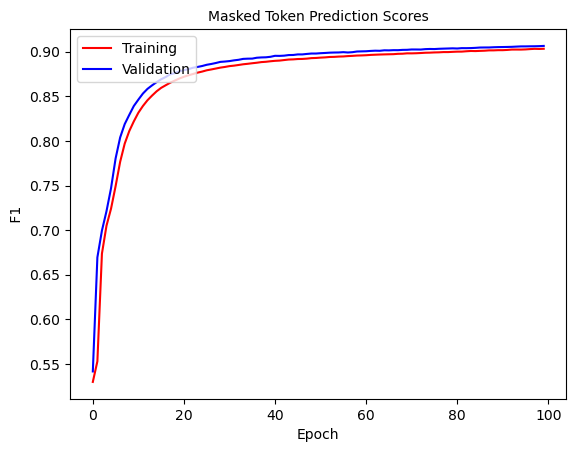

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 100: 100%|██████████| 445/445 [07:05<00:00,  1.05it/s, loss=0.161] 
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter 

Training:   Instruction f1:  0.9830639584627465   Masked Token f1 0.9034158633987723     SEQ F1 0.9866147441856169


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:40<00:00,  2.76it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior

Validation:  Instruction F1:  0.845997693194925    v_masked_token_ F1:  0.9068070294025385  V SEQ F1:  0.9871037707413971


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


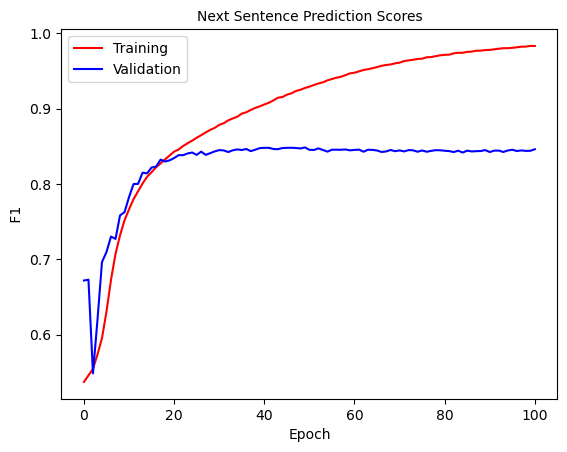

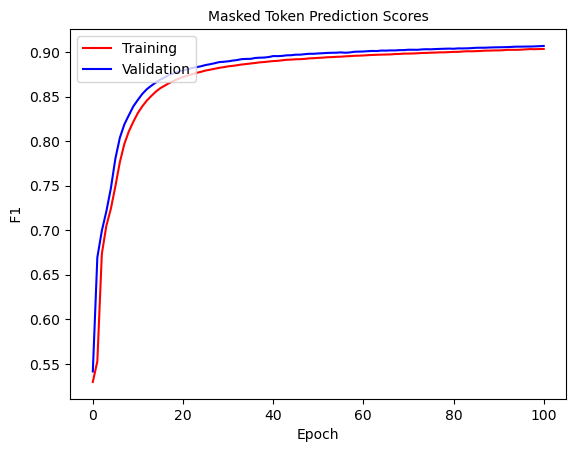

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 101: 100%|██████████| 445/445 [07:06<00:00,  1.04it/s, loss=0.0943]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter 

Training:   Instruction f1:  0.9830244291180555   Masked Token f1 0.903659712976375     SEQ F1 0.9866615120027283


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:40<00:00,  2.76it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior

Validation:  Instruction F1:  0.8434537298247237    v_masked_token_ F1:  0.9066495074338153  V SEQ F1:  0.987133717107652


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


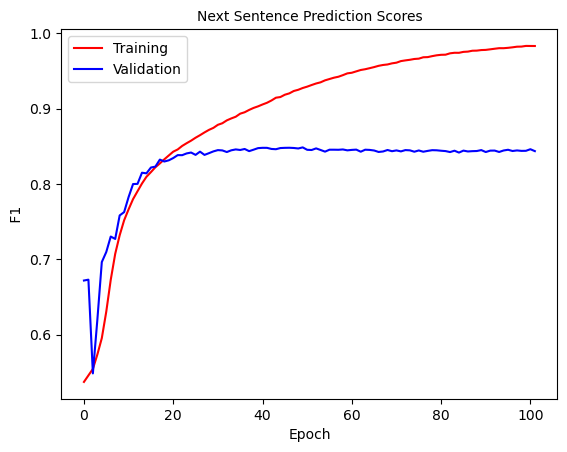

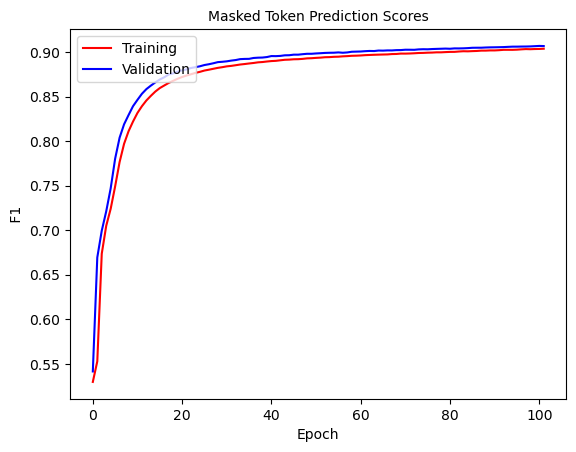

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 102: 100%|██████████| 445/445 [07:04<00:00,  1.05it/s, loss=0.106] 
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter 

Training:   Instruction f1:  0.9836453525152885   Masked Token f1 0.903862920819833     SEQ F1 0.9866793489881502


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:40<00:00,  2.74it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior

Validation:  Instruction F1:  0.8438009218306253    v_masked_token_ F1:  0.9067242442616138  V SEQ F1:  0.9871394273911812


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


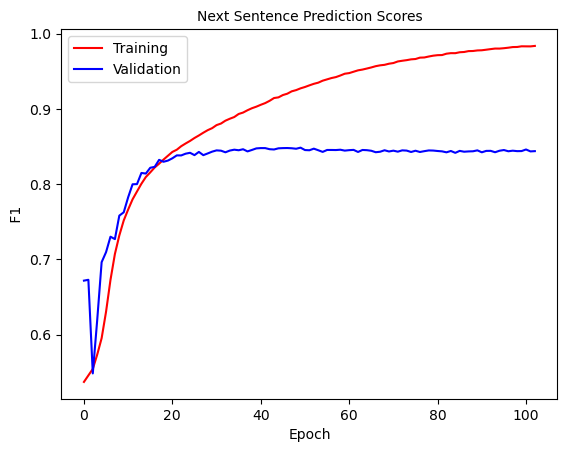

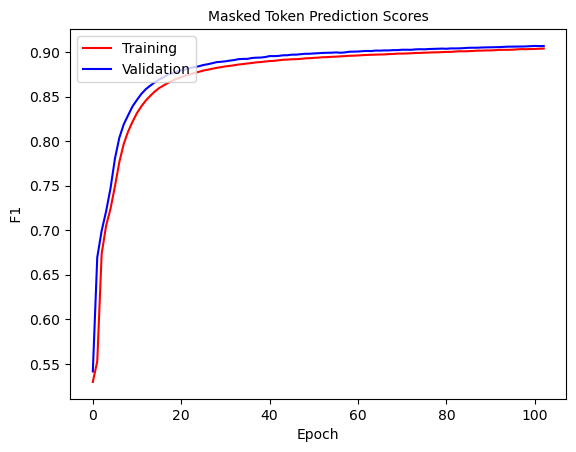

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 103: 100%|██████████| 445/445 [07:07<00:00,  1.04it/s, loss=0.0797]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter 

Training:   Instruction f1:  0.9838314723904816   Masked Token f1 0.9039020650453606     SEQ F1 0.9866894726246092


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:40<00:00,  2.75it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior

Validation:  Instruction F1:  0.8429759790634639    v_masked_token_ F1:  0.9070523315346796  V SEQ F1:  0.9871675863721371


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


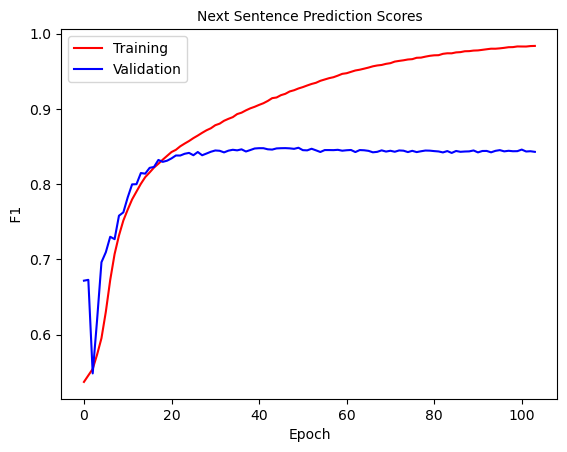

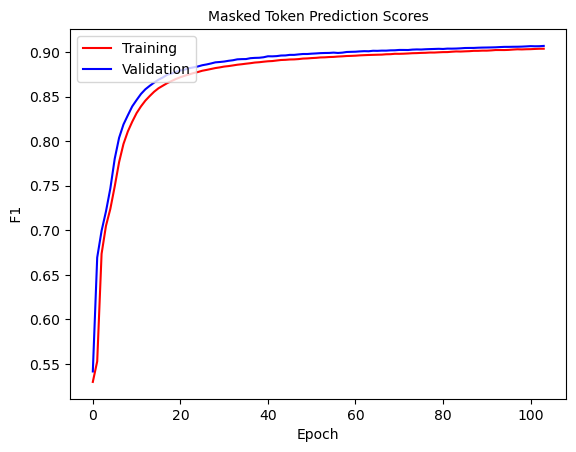

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 104: 100%|██████████| 445/445 [07:04<00:00,  1.05it/s, loss=0.084] 
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter 

Training:   Instruction f1:  0.9844717404420077   Masked Token f1 0.9041127264904336     SEQ F1 0.9867156740159467


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:41<00:00,  2.72it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior

Validation:  Instruction F1:  0.843865393994287    v_masked_token_ F1:  0.9071502466372655  V SEQ F1:  0.9871674027553374


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


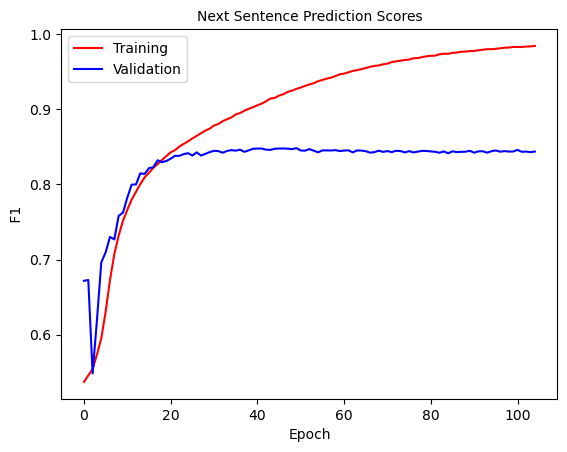

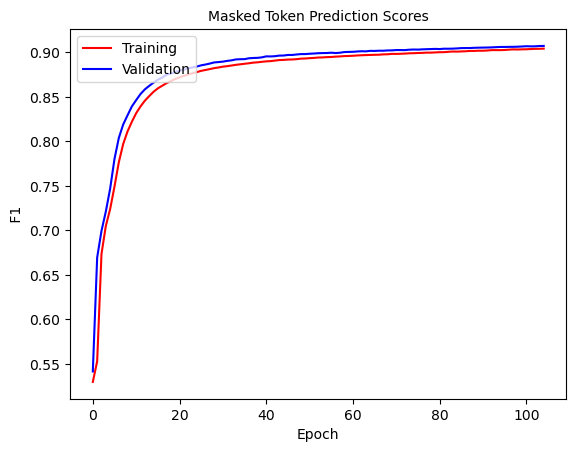

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 105: 100%|██████████| 445/445 [07:05<00:00,  1.04it/s, loss=0.0888]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter 

Training:   Instruction f1:  0.9850744520760506   Masked Token f1 0.9042858400216065     SEQ F1 0.9867453773092649


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:40<00:00,  2.75it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior

Validation:  Instruction F1:  0.8451648965902739    v_masked_token_ F1:  0.907167709449165  V SEQ F1:  0.9872008459725503


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


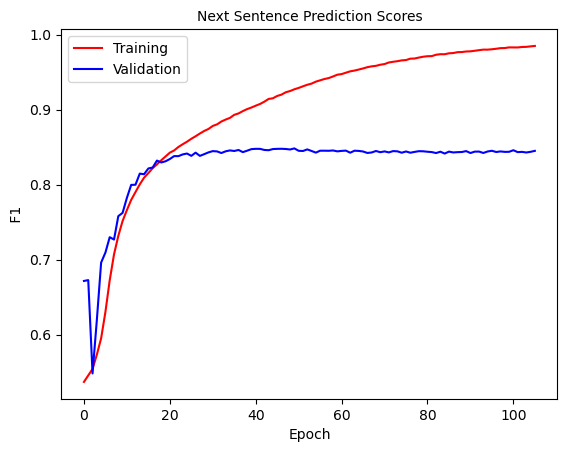

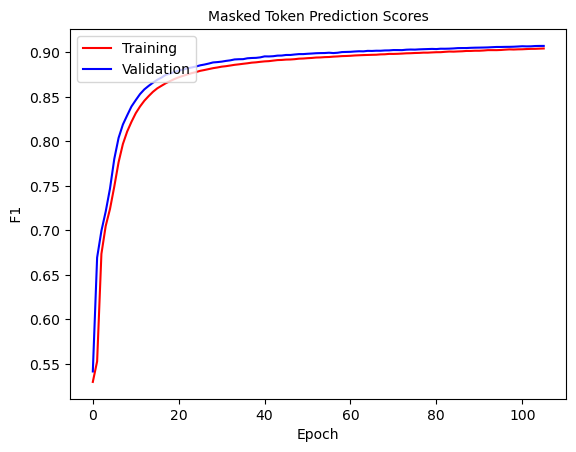

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 106: 100%|██████████| 445/445 [07:06<00:00,  1.04it/s, loss=0.152] 
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter 

Training:   Instruction f1:  0.9853936795745777   Masked Token f1 0.9045418827817641     SEQ F1 0.9867892006203652


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:40<00:00,  2.74it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior

Validation:  Instruction F1:  0.843633463892863    v_masked_token_ F1:  0.907249329597967  V SEQ F1:  0.9871906702266617


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


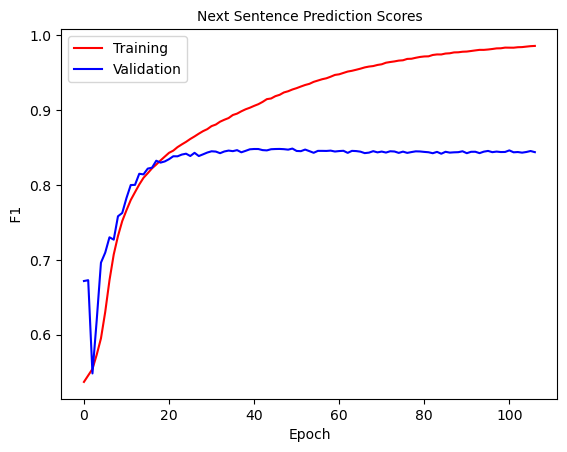

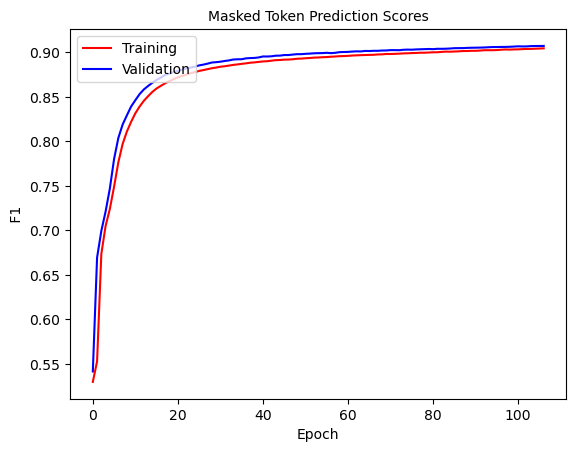

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 107: 100%|██████████| 445/445 [07:05<00:00,  1.05it/s, loss=0.11]  
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter 

Training:   Instruction f1:  0.9857285914231001   Masked Token f1 0.9046874997919514     SEQ F1 0.9868064081583613


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:40<00:00,  2.74it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior

Validation:  Instruction F1:  0.8440156429290682    v_masked_token_ F1:  0.9075744761291381  V SEQ F1:  0.9872309917742023


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


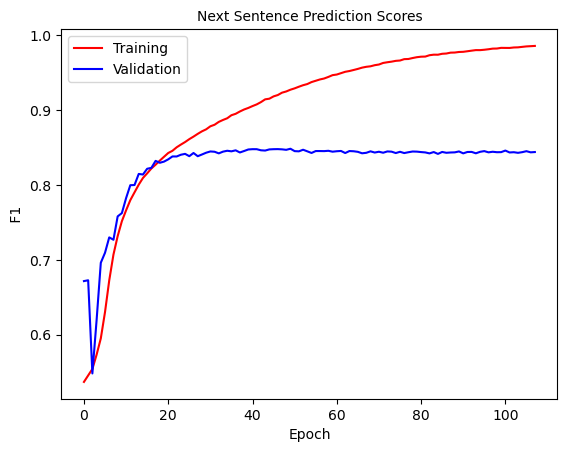

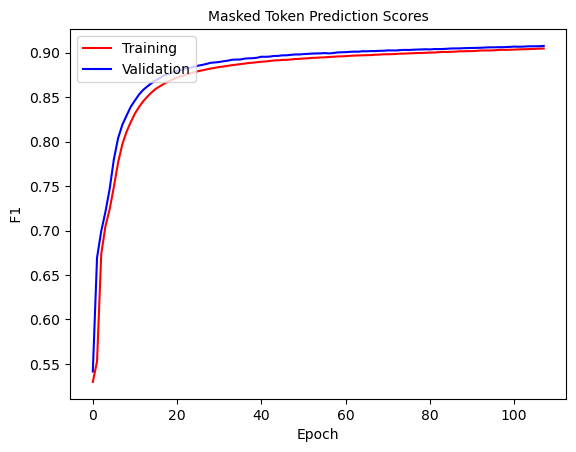

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 108: 100%|██████████| 445/445 [07:07<00:00,  1.04it/s, loss=0.122] 
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter 

Training:   Instruction f1:  0.9865988801162056   Masked Token f1 0.9048107473368455     SEQ F1 0.9868194398331428


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:41<00:00,  2.73it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior

Validation:  Instruction F1:  0.8444485285671621    v_masked_token_ F1:  0.907579235058309  V SEQ F1:  0.9872205828013876


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


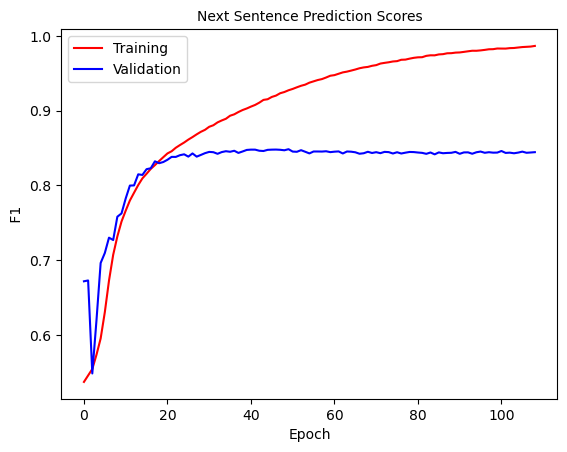

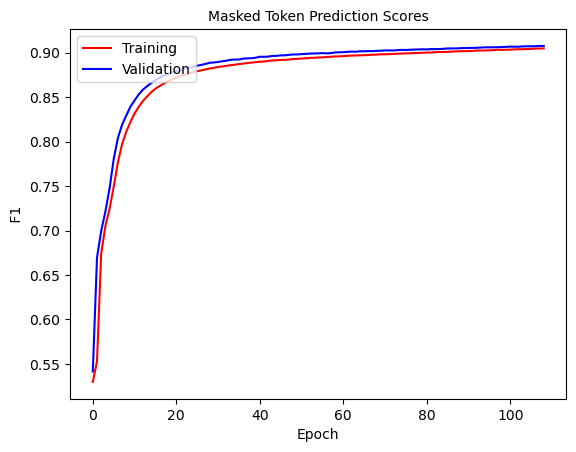

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 109: 100%|██████████| 445/445 [07:05<00:00,  1.05it/s, loss=0.0725]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter 

Training:   Instruction f1:  0.9858368219210164   Masked Token f1 0.9048873691902654     SEQ F1 0.9868277762408143


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:40<00:00,  2.75it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior

Validation:  Instruction F1:  0.8432554808603044    v_masked_token_ F1:  0.9078482001977776  V SEQ F1:  0.9872695928823491


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


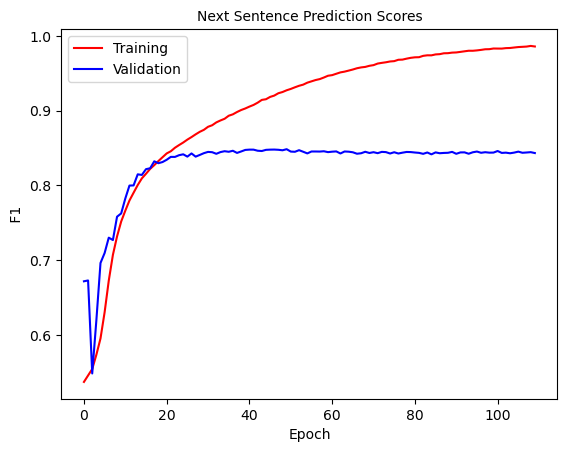

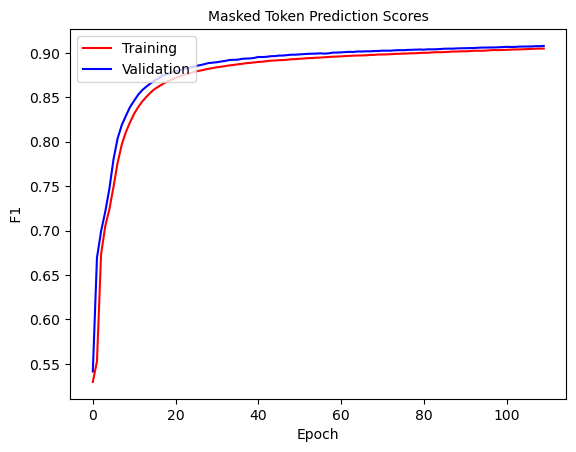

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 110: 100%|██████████| 445/445 [07:06<00:00,  1.04it/s, loss=0.0767]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter 

Training:   Instruction f1:  0.9865655128813023   Masked Token f1 0.9050864624771094     SEQ F1 0.9868630973809496


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:40<00:00,  2.75it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior

Validation:  Instruction F1:  0.842765228009205    v_masked_token_ F1:  0.9076633878558846  V SEQ F1:  0.9872511037451198


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


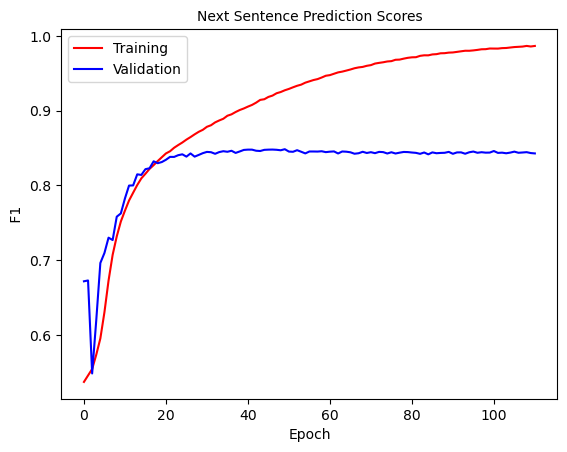

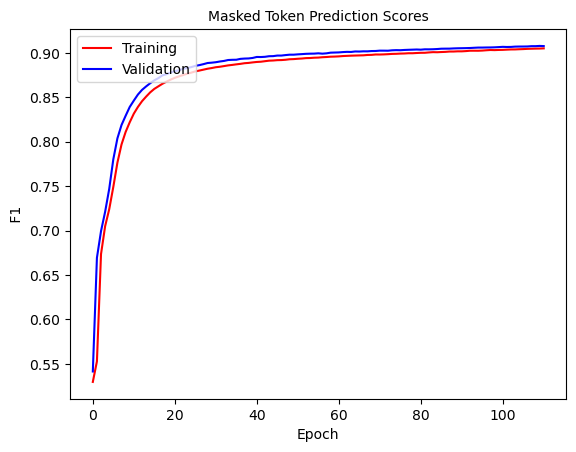

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 111: 100%|██████████| 445/445 [07:06<00:00,  1.04it/s, loss=0.0723]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter 

Training:   Instruction f1:  0.9867890402299186   Masked Token f1 0.9052767989728375     SEQ F1 0.9868836514091461


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:40<00:00,  2.75it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior

Validation:  Instruction F1:  0.8439818920054137    v_masked_token_ F1:  0.9079863688284819  V SEQ F1:  0.9872961602575949


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


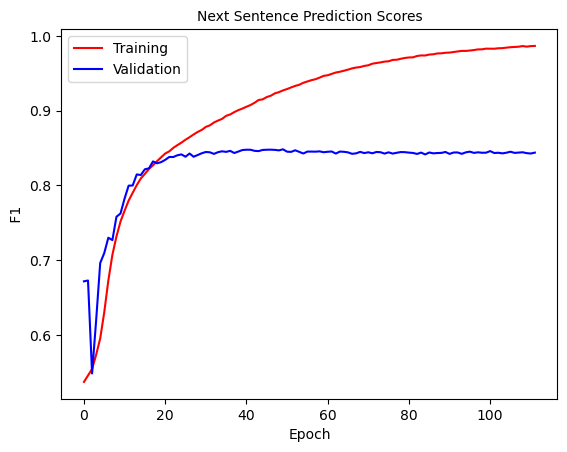

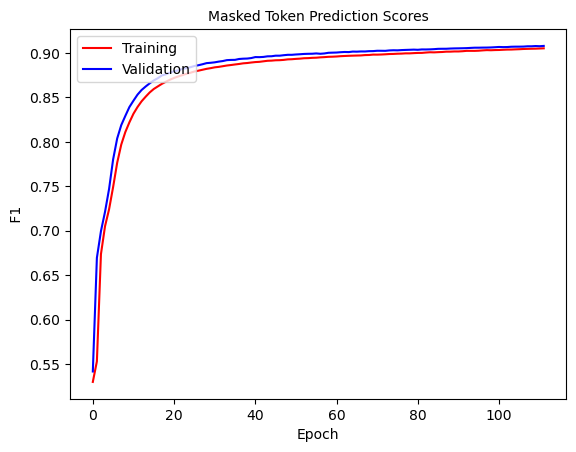

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 112: 100%|██████████| 445/445 [07:05<00:00,  1.05it/s, loss=0.066] 
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter 

Training:   Instruction f1:  0.9869550713696297   Masked Token f1 0.9052693536192947     SEQ F1 0.9868827062584258


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:40<00:00,  2.76it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior

Validation:  Instruction F1:  0.8421425367673095    v_masked_token_ F1:  0.9079982154508478  V SEQ F1:  0.9873079060055076


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


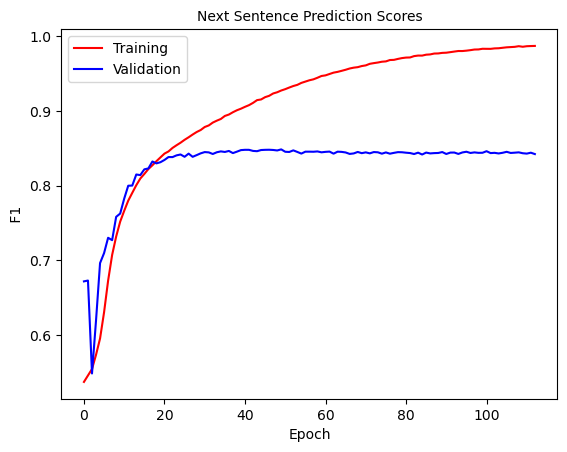

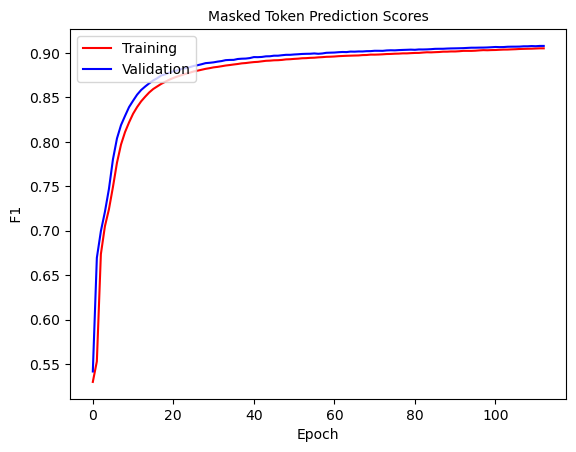

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 113: 100%|██████████| 445/445 [07:04<00:00,  1.05it/s, loss=0.0776]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter 

Training:   Instruction f1:  0.9874055120645944   Masked Token f1 0.90550650646837     SEQ F1 0.9869204660352022


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:40<00:00,  2.75it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior

Validation:  Instruction F1:  0.8430656084902367    v_masked_token_ F1:  0.9080586646672169  V SEQ F1:  0.9873089401571771


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


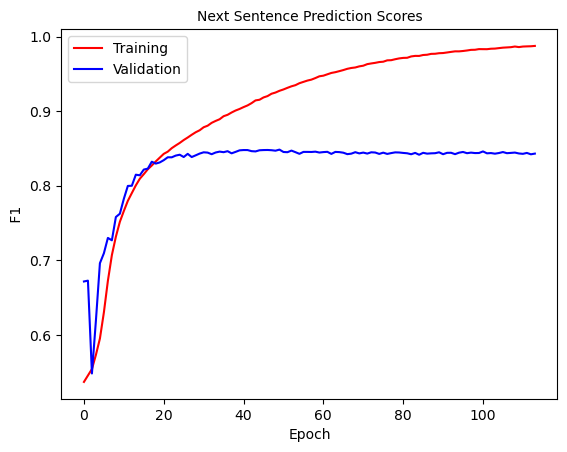

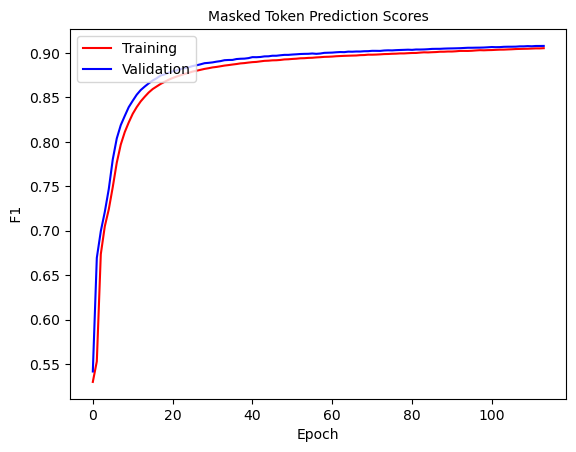

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 114: 100%|██████████| 445/445 [07:06<00:00,  1.04it/s, loss=0.0752]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter 

Training:   Instruction f1:  0.9869728571930194   Masked Token f1 0.9057055107261734     SEQ F1 0.9869472870146335


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:40<00:00,  2.77it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior

Validation:  Instruction F1:  0.841495449854583    v_masked_token_ F1:  0.9084128518678193  V SEQ F1:  0.9873263619200014


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


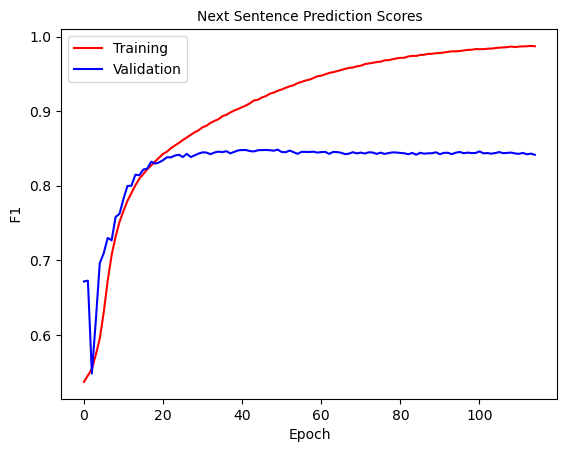

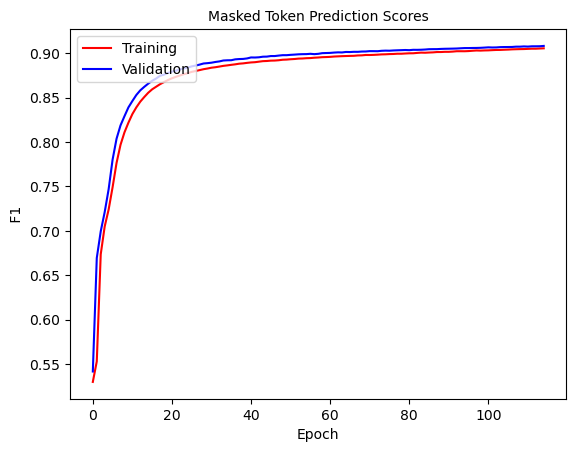

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 115: 100%|██████████| 445/445 [07:05<00:00,  1.05it/s, loss=0.0574]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter 

Training:   Instruction f1:  0.9878082328083206   Masked Token f1 0.9057005391161449     SEQ F1 0.9869388567070639


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:40<00:00,  2.74it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior

Validation:  Instruction F1:  0.8414977477477478    v_masked_token_ F1:  0.9083181577041539  V SEQ F1:  0.9873405215303062


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


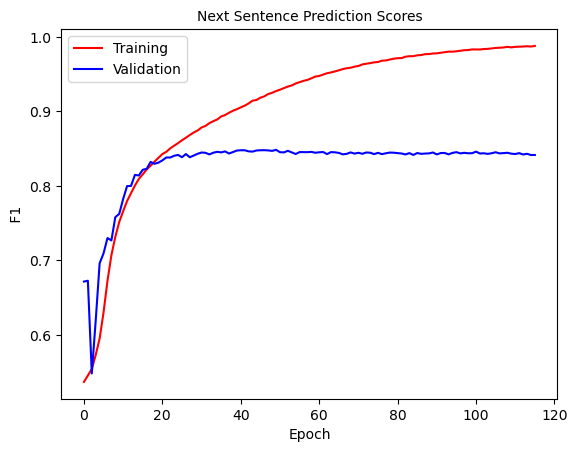

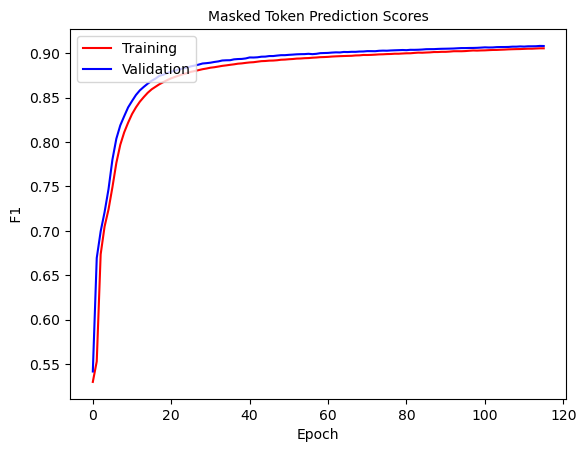

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 116: 100%|██████████| 445/445 [07:06<00:00,  1.04it/s, loss=0.0706]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter 

Training:   Instruction f1:  0.9879649250149267   Masked Token f1 0.9057800049775712     SEQ F1 0.9869462319839121


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:40<00:00,  2.75it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior

Validation:  Instruction F1:  0.843475039362786    v_masked_token_ F1:  0.9084144102859427  V SEQ F1:  0.9873524720804701


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


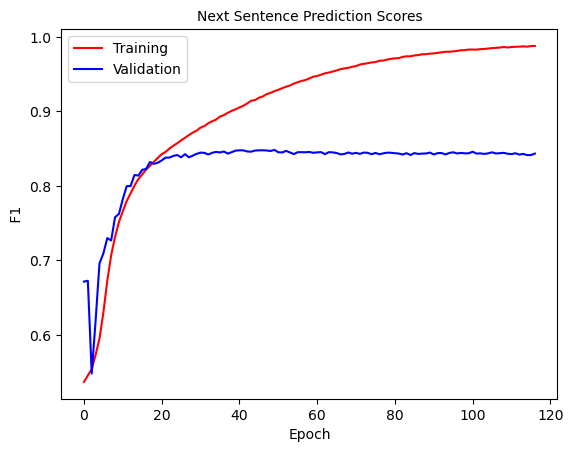

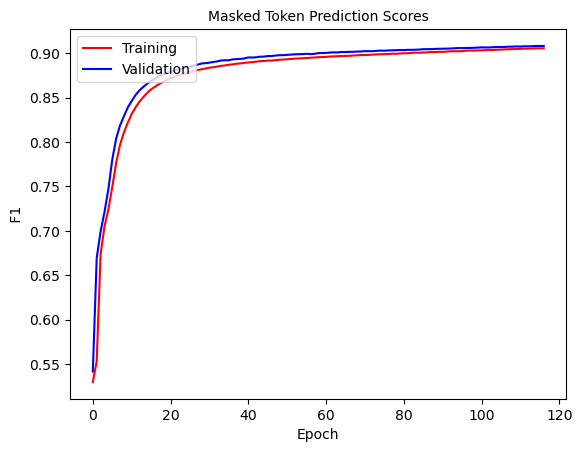

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 117: 100%|██████████| 445/445 [07:06<00:00,  1.04it/s, loss=0.0819]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter 

Training:   Instruction f1:  0.9878979138977851   Masked Token f1 0.9060809315960432     SEQ F1 0.9869915732424643


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:40<00:00,  2.74it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior

Validation:  Instruction F1:  0.8406646199995313    v_masked_token_ F1:  0.9085159209205121  V SEQ F1:  0.9873566084713972


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


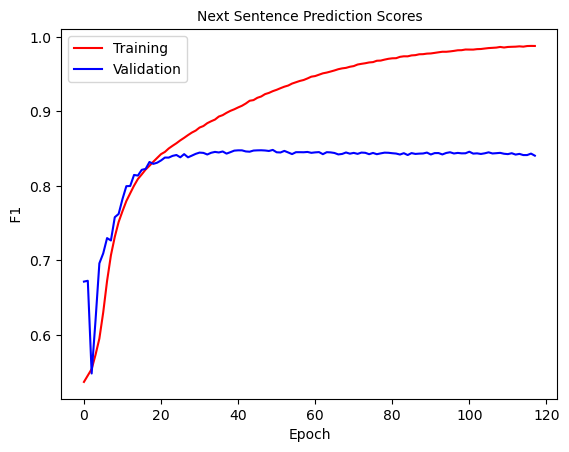

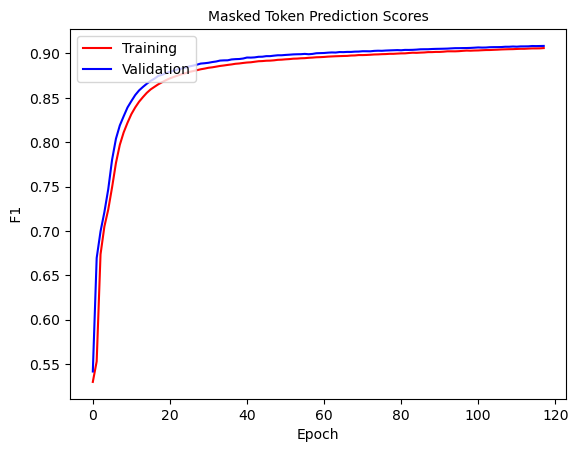

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 118: 100%|██████████| 445/445 [07:05<00:00,  1.05it/s, loss=0.0874]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter 

Training:   Instruction f1:  0.9885054780410151   Masked Token f1 0.9062013139642577     SEQ F1 0.9870012484189024


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:40<00:00,  2.76it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior

Validation:  Instruction F1:  0.8430130647159184    v_masked_token_ F1:  0.9085178216422584  V SEQ F1:  0.9873841030157506


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


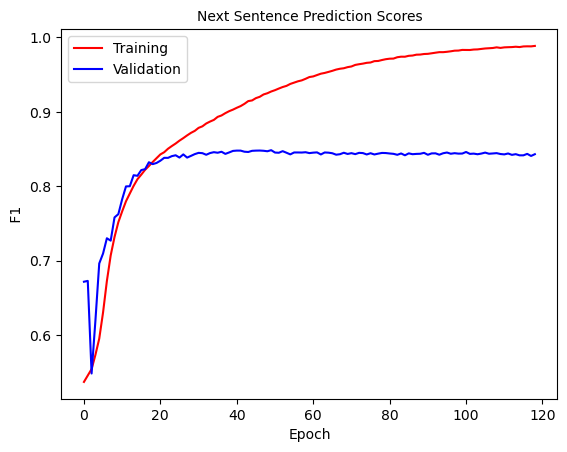

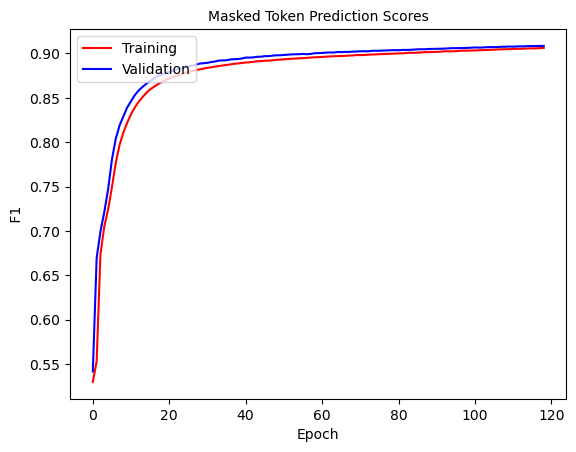

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 119: 100%|██████████| 445/445 [07:05<00:00,  1.04it/s, loss=0.0724]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter 

Training:   Instruction f1:  0.9882252369883306   Masked Token f1 0.9063466085966526     SEQ F1 0.9870262457345952


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:40<00:00,  2.75it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior

Validation:  Instruction F1:  0.8438491693111816    v_masked_token_ F1:  0.908559476483779  V SEQ F1:  0.9873724664796267


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


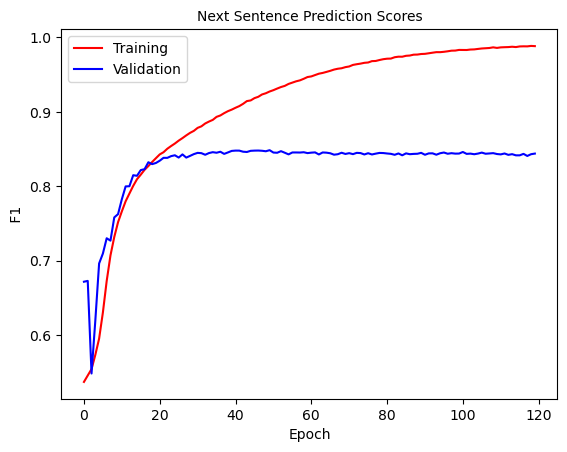

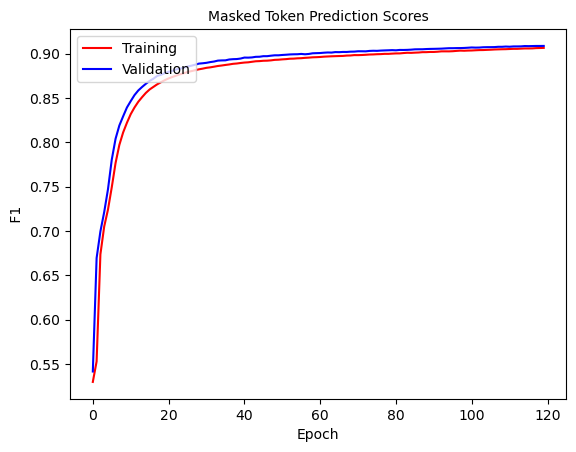

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 120: 100%|██████████| 445/445 [07:05<00:00,  1.04it/s, loss=0.066] 
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter 

Training:   Instruction f1:  0.9893520496865323   Masked Token f1 0.9064313553182793     SEQ F1 0.9870522914758445


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:40<00:00,  2.75it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior

Validation:  Instruction F1:  0.8433601074049212    v_masked_token_ F1:  0.9088882400244903  V SEQ F1:  0.9874092260430174


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


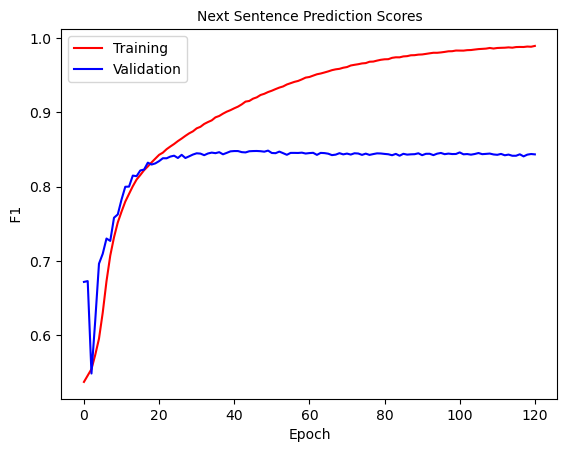

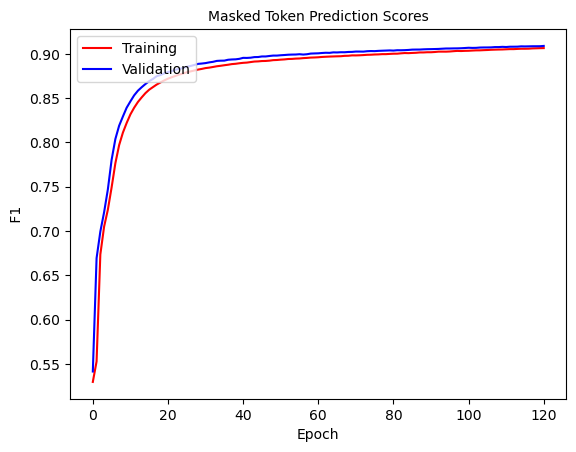

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 121: 100%|██████████| 445/445 [07:04<00:00,  1.05it/s, loss=0.0699]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter 

Training:   Instruction f1:  0.9892329658497765   Masked Token f1 0.9067205206788506     SEQ F1 0.9870850603494334


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:40<00:00,  2.76it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior

Validation:  Instruction F1:  0.8429752066115702    v_masked_token_ F1:  0.9092859052782906  V SEQ F1:  0.9874380261804543


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


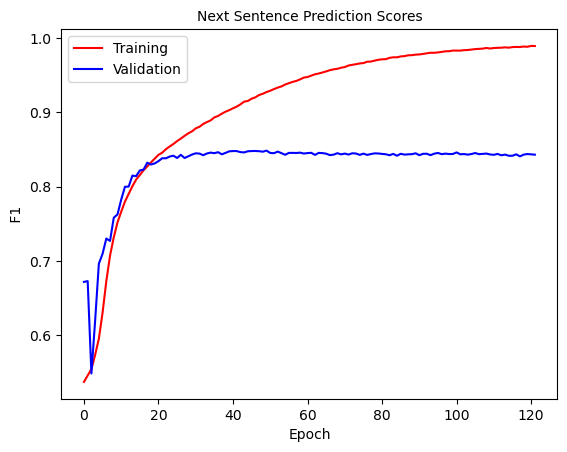

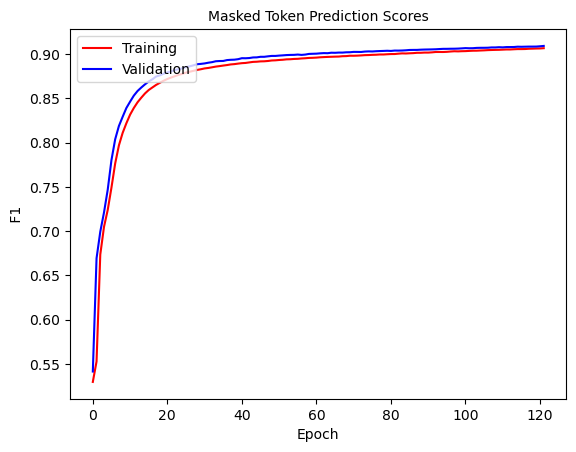

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 122: 100%|██████████| 445/445 [07:05<00:00,  1.05it/s, loss=0.0761]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter 

Training:   Instruction f1:  0.989291732983803   Masked Token f1 0.9068013652971921     SEQ F1 0.9870876991013333


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:40<00:00,  2.75it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior

Validation:  Instruction F1:  0.8434242831333673    v_masked_token_ F1:  0.909123875836186  V SEQ F1:  0.9874471274407969


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


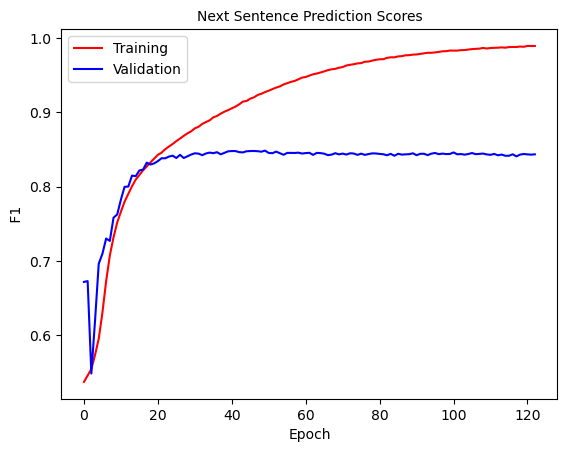

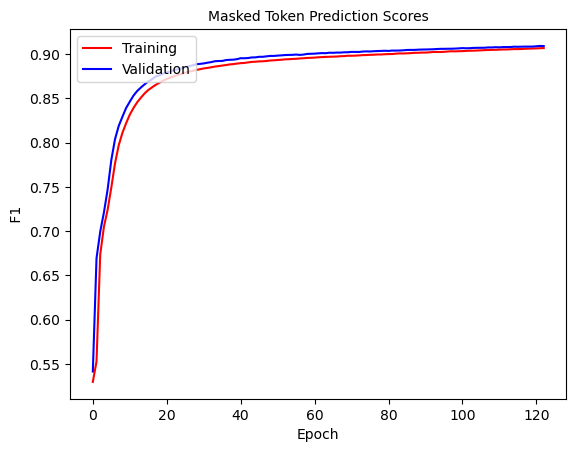

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 123: 100%|██████████| 445/445 [07:04<00:00,  1.05it/s, loss=0.167] 
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter 

Training:   Instruction f1:  0.9891908025258526   Masked Token f1 0.9070014460481455     SEQ F1 0.9871196299095939


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:40<00:00,  2.76it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior

Validation:  Instruction F1:  0.843780493471493    v_masked_token_ F1:  0.9092980323087307  V SEQ F1:  0.9874683424931436


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


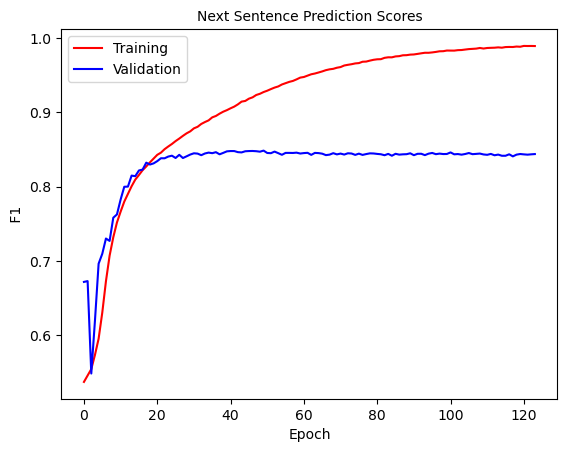

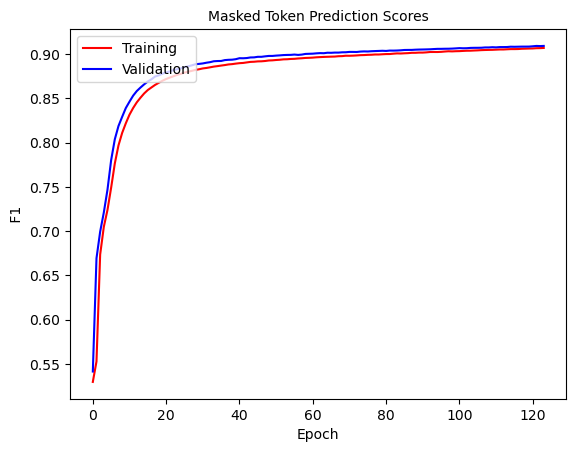

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 124: 100%|██████████| 445/445 [07:05<00:00,  1.05it/s, loss=0.108] 
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter 

Training:   Instruction f1:  0.9894702358667166   Masked Token f1 0.9071557019373035     SEQ F1 0.9871432991479367


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:40<00:00,  2.74it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior

Validation:  Instruction F1:  0.8416905611114996    v_masked_token_ F1:  0.909352525209714  V SEQ F1:  0.9874446750816694


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


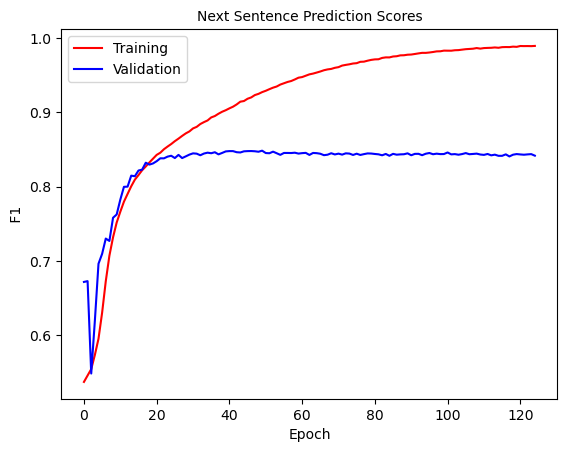

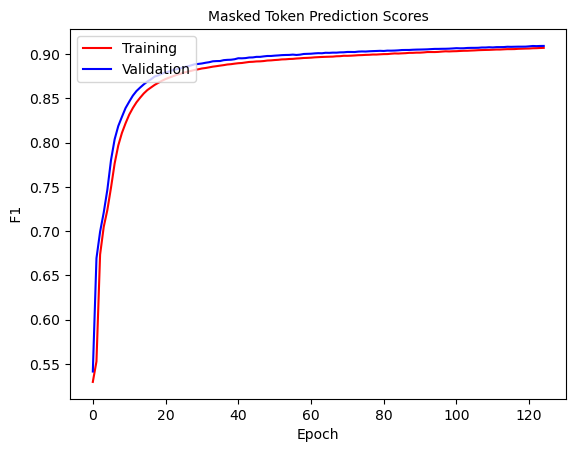

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 125: 100%|██████████| 445/445 [07:04<00:00,  1.05it/s, loss=0.0582]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter 

Training:   Instruction f1:  0.9897188332016735   Masked Token f1 0.9070330247028539     SEQ F1 0.9871208521892868


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:40<00:00,  2.76it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior

Validation:  Instruction F1:  0.843477651346994    v_masked_token_ F1:  0.9094870442615631  V SEQ F1:  0.9874907156673208


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


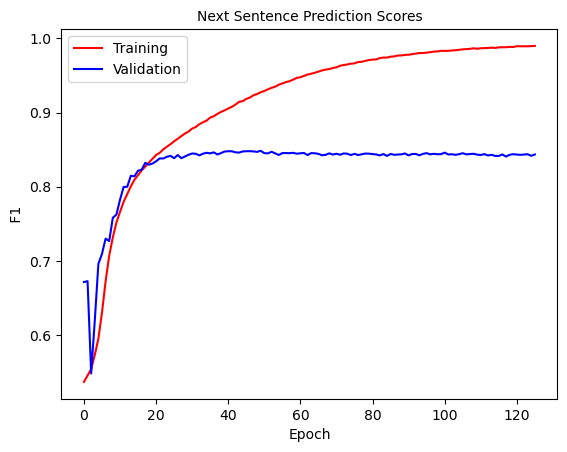

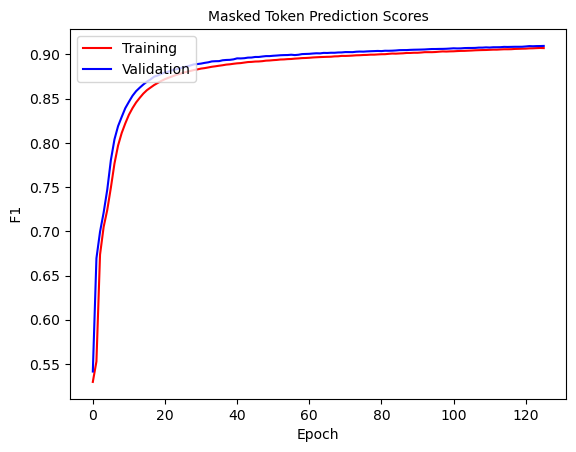

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 126: 100%|██████████| 445/445 [07:04<00:00,  1.05it/s, loss=0.0675]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter 

Training:   Instruction f1:  0.9898357451738807   Masked Token f1 0.9073250494078392     SEQ F1 0.9871619420099979


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:40<00:00,  2.75it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior

Validation:  Instruction F1:  0.8426913936908811    v_masked_token_ F1:  0.9097096821964088  V SEQ F1:  0.9875178461986833


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


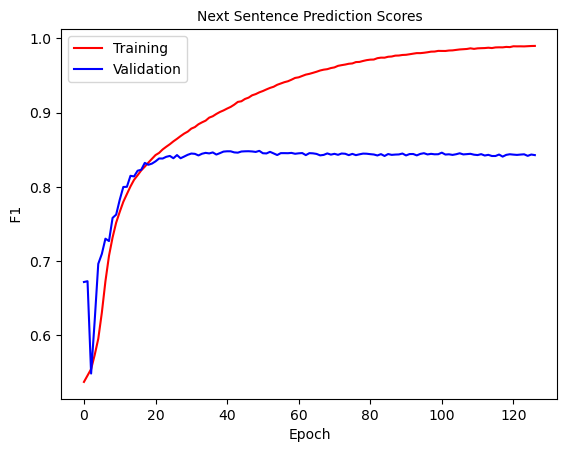

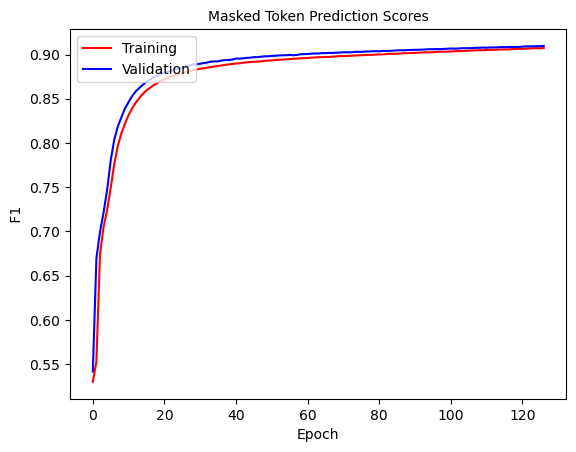

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 127: 100%|██████████| 445/445 [07:04<00:00,  1.05it/s, loss=0.0543]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter 

Training:   Instruction f1:  0.9900518474304507   Masked Token f1 0.9075303405916773     SEQ F1 0.9871819255640197


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:40<00:00,  2.77it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior

Validation:  Instruction F1:  0.8445963223841737    v_masked_token_ F1:  0.9096114514345194  V SEQ F1:  0.9874922051568655


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


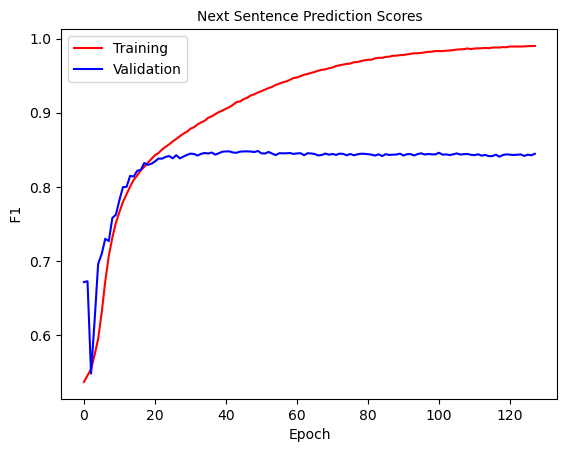

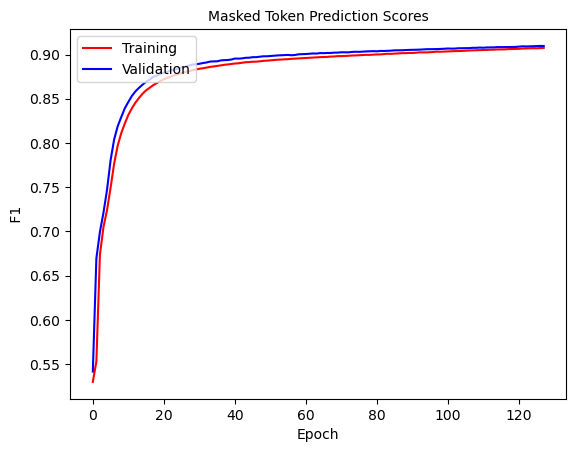

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 128: 100%|██████████| 445/445 [07:04<00:00,  1.05it/s, loss=0.0442]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter 

Training:   Instruction f1:  0.9902271743074168   Masked Token f1 0.907768069364238     SEQ F1 0.9872186289989728


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:40<00:00,  2.76it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior

Validation:  Instruction F1:  0.8432786576168929    v_masked_token_ F1:  0.909730254936357  V SEQ F1:  0.9875310670137524


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


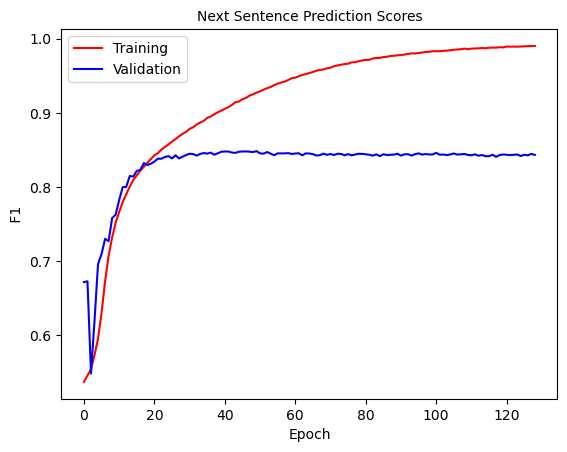

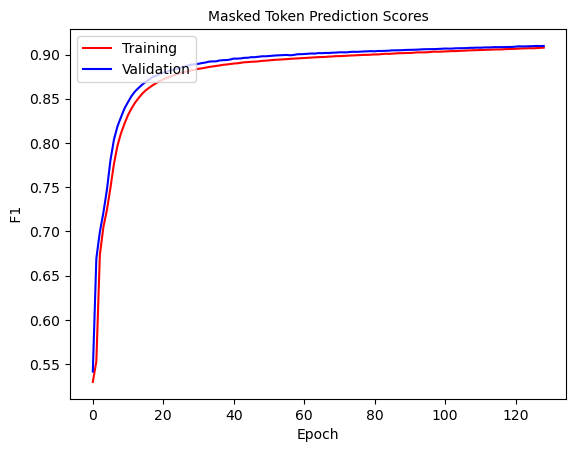

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 129: 100%|██████████| 445/445 [07:05<00:00,  1.05it/s, loss=0.128] 
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter 

Training:   Instruction f1:  0.9902410484437164   Masked Token f1 0.9077291337599654     SEQ F1 0.9872113473510848


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:40<00:00,  2.75it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior

Validation:  Instruction F1:  0.8430565828402367    v_masked_token_ F1:  0.9098904661133691  V SEQ F1:  0.987546524586106


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


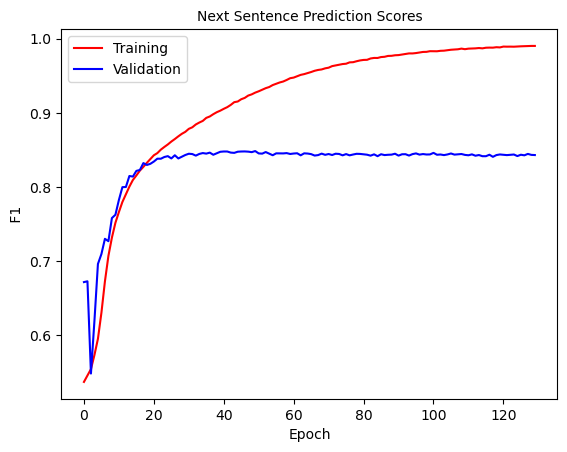

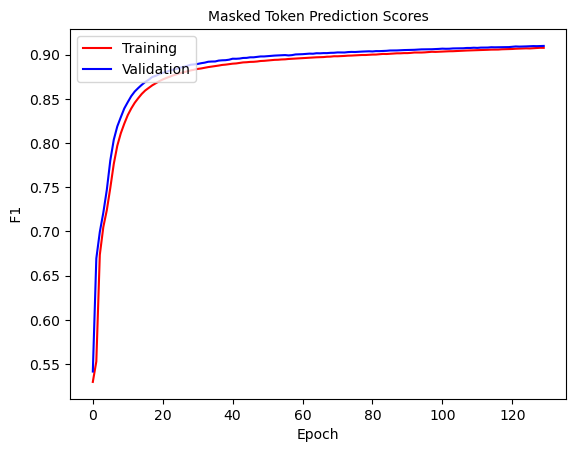

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 130: 100%|██████████| 445/445 [07:05<00:00,  1.05it/s, loss=0.0571]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter 

Training:   Instruction f1:  0.9905931905931906   Masked Token f1 0.9079088012659363     SEQ F1 0.9872368170383813


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:40<00:00,  2.75it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior

Validation:  Instruction F1:  0.8428730719197175    v_masked_token_ F1:  0.9098835181307164  V SEQ F1:  0.9875345342843349


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


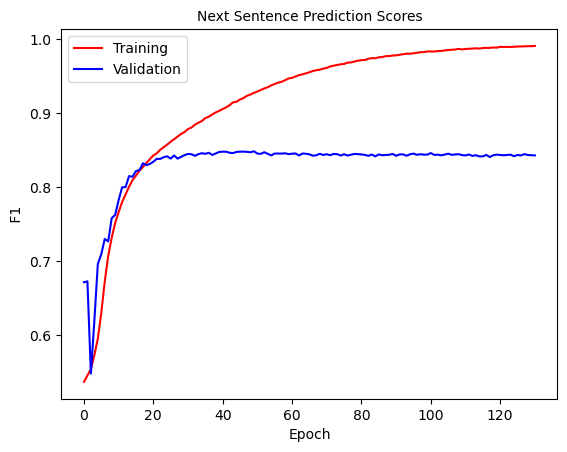

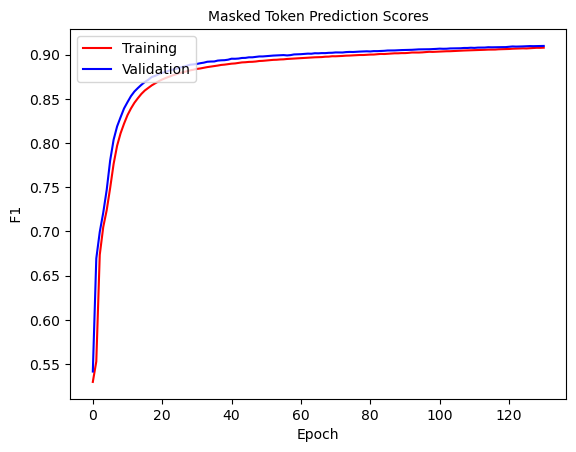

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_60863/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 131:  53%|█████▎    | 237/445 [03:46<03:19,  1.04it/s, loss=0.0923]

In [ ]:
from transformers import AdamW
from tqdm import tqdm  # for our progress bar
from itertools import chain

# initialize optimizer
optim = AdamW(model.parameters(), lr=5e-6)



epochs =1000
counter = 0

global_instruction_metrices = []
global_masked_token_metrices = []

v_global_instruction_metrices = []
v_global_masked_token_metrices = []


for epoch in range(epochs):
    # setup loop with TQDM and dataloader
    train_loop = tqdm(train_loader, leave=True)
    
    
    instruction_predictions_all, instruction_ground_truths_all = None, None
    masked_token_predictions_all, masked_token_ground_truths_all = None, None
    seq_predictions_all, seq_ground_truths_all = None, None
    
    # activate training mode
    model.train()
    for N,batch in enumerate(train_loop):

        optim.zero_grad()
        # pull all tensor batches required for training
        input_ids = batch['input_ids'].to(device)
        token_type_ids = batch['token_type_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        next_sentence_label = batch['next_sentence_label'].to(device)
        batch_mask_arr = batch ['mask_arr']
        labels = batch['labels'].to(device)

        # process
        outputs = model(input_ids, attention_mask=attention_mask,
                        token_type_ids=token_type_ids,
                        next_sentence_label=next_sentence_label,
                        labels=labels)


        token_prediction = torch.argmax(outputs.prediction_logits, axis=-1)
       


        # batch_masks = selection [BATCH_SIZE*N : (BATCH_SIZE*(N+1))]
        # print('batch_masks old: ',batch_masks)

        # print(batch ['mask_arr'].shape) #torch.flatten(mask_arr[i].nonzero()).tolist()
        batch_masks =   [ torch.flatten(bm.nonzero()).tolist()  for bm in batch_mask_arr]    # torch.flatten(batch ['mask_arr'].nonzero()).tolist()
        # print('batch_masks new: ',batch_masks)
        
        # print("BATCH_SIZE*N : (BATCH_SIZE*(N+1)): ",BATCH_SIZE*N , (BATCH_SIZE*(N+1)) )
        # print("batch_masks:",batch_masks)



        

        masked_token_prediction = [ token[batch_masks[t]].tolist() for t,token in enumerate(token_prediction) ]
        masked_token_prediction = list(chain.from_iterable(masked_token_prediction))
        
        masked_token_ground_truth   = [ token[batch_masks[t]].tolist() for t,token in enumerate(labels) ]
        masked_token_ground_truth = list(chain.from_iterable(masked_token_ground_truth))
        

        # print(token_prediction , token_ground_truth)

        # token_prediction = token_prediction.detach().cpu().numpy().flatten()
        # token_ground_truth = labels.detach().cpu().numpy().flatten()

        # print("token_prediction  : ", token_prediction)
        # print("token_ground_truth: ", token_ground_truth)


        seq_predictions   = token_prediction.detach().cpu().numpy().flatten()
        seq_ground_truths = labels.detach().cpu().numpy().flatten()

        
        instruction_prediction = torch.argmax(outputs.seq_relationship_logits, axis=-1)
        instruction_prediction   = instruction_prediction.detach().cpu().numpy().flatten()
        instruction_ground_truth = next_sentence_label.detach().cpu().numpy().flatten()
        
        if N==0:
            instruction_predictions_all   = instruction_prediction
            instruction_ground_truths_all = instruction_ground_truth
            
            masked_token_predictions_all         = masked_token_prediction
            masked_token_ground_truths_all       = masked_token_ground_truth  


            seq_predictions_all = seq_predictions
            seq_ground_truths_all = seq_ground_truths
            
        else:
            instruction_predictions_all   = np.concatenate((instruction_predictions_all, instruction_prediction))
            instruction_ground_truths_all = np.concatenate((instruction_ground_truths_all, instruction_ground_truth))
            
            masked_token_predictions_all   = np.concatenate((masked_token_predictions_all, masked_token_prediction))
            masked_token_ground_truths_all = np.concatenate((masked_token_ground_truths_all, masked_token_ground_truth))

            seq_predictions_all = np.concatenate((seq_predictions_all, seq_predictions))
            seq_ground_truths_all = np.concatenate((seq_ground_truths_all, seq_ground_truths))
            

        # extract loss
        loss = outputs.loss
        # calculate loss for every parameter that needs grad update
        loss.backward()
        # update parameters
        optim.step()
        # print relevant info to progress bar
        train_loop.set_description(f'Epoch {epoch}')
        train_loop.set_postfix(loss=loss.item())
    
    
    instruction_accuracy = (accuracy_score(instruction_ground_truths_all,instruction_predictions_all))
    instruction_precision, instruction_recall, instruction_f1, _ = precision_recall_fscore_support(instruction_ground_truths_all,instruction_predictions_all, average='binary')
    
    masked_token_accuracy = (accuracy_score(masked_token_ground_truths_all, masked_token_predictions_all))
    masked_token_precision, masked_token_recall, masked_token_f1, _ = precision_recall_fscore_support(masked_token_ground_truths_all,masked_token_predictions_all,average='weighted')

    seq_precision, seq_recall, seq_f1, _ = precision_recall_fscore_support(seq_ground_truths_all,seq_predictions_all,average='weighted')
    
    print("Training: ",  ' Instruction f1: ', instruction_f1 , '  Masked Token f1',masked_token_f1 , "    SEQ F1",seq_f1)
    global_instruction_metrices.append(instruction_f1)
    global_masked_token_metrices.append( masked_token_f1) 

    ###########################################
    ###############  EVAL Validation  #########
    ###########################################
    with torch.no_grad():
        model.eval()
#         v_predictions_all, v_ground_truths_all = None, None
        
        v_instruction_predictions_all, v_instruction_ground_truths_all = None, None
        v_masked_token_predictions_all, v_masked_token_ground_truths_all = None, None
        v_seq_predictions_all, v_seq_ground_truths_all = None, None
    
    
        validation_loop = tqdm(validation_loader, leave=True)
        for N,v_batch in enumerate(validation_loop):
            
            
            
            v_input_ids = v_batch['input_ids'].to(device)
            v_token_type_ids = v_batch['token_type_ids'].to(device)
            v_attention_mask = v_batch['attention_mask'].to(device)
            v_next_sentence_label = v_batch['next_sentence_label'].to(device)
            v_mask_arr = v_batch ['mask_arr']
            v_labels = v_batch['labels'].to(device)
            # process
            v_outputs = model(v_input_ids, attention_mask=v_attention_mask,
                            token_type_ids=v_token_type_ids,
                            next_sentence_label=v_next_sentence_label,
                            labels=v_labels)
        
            v_token_prediction = torch.argmax(v_outputs.prediction_logits, axis=-1)

                    

            v_batch_masks =   [ torch.flatten(bm.nonzero()).tolist()  for bm in v_mask_arr]
            
            v_masked_token_prediction = [ token[v_batch_masks[t]].tolist() for t,token in enumerate(v_token_prediction) ]
            v_masked_token_prediction = list(chain.from_iterable(v_masked_token_prediction))
            
            v_masked_token_ground_truth   = [ token[v_batch_masks[t]].tolist() for t,token in enumerate(v_labels) ]
            v_masked_token_ground_truth = list(chain.from_iterable(v_masked_token_ground_truth))
    
            
            

            v_seq_prediction = v_token_prediction.detach().cpu().numpy().flatten()
            v_seq_ground_truth = v_labels.detach().cpu().numpy().flatten()


            

            # token_prediction = [ token[batch_masks[t]].tolist() for t,token in enumerate(token_prediction) ]
            # token_prediction = list(chain.from_iterable(token_prediction))
            
            # token_ground_truth   = [ token[batch_masks[t]].tolist() for t,token in enumerate(labels) ]
            # token_ground_truth = list(chain.from_iterable(token_ground_truth))

            
            v_instruction_prediction = torch.argmax(v_outputs.seq_relationship_logits, axis=-1)
            v_instruction_prediction   = v_instruction_prediction.detach().cpu().numpy().flatten()
            v_instruction_ground_truth = v_next_sentence_label.detach().cpu().numpy().flatten()



        

            if N==0:
                v_instruction_predictions_all   = v_instruction_prediction
                v_instruction_ground_truths_all = v_instruction_ground_truth

                v_masked_token_predictions_all   = v_masked_token_prediction
                v_masked_token_ground_truths_all = v_masked_token_ground_truth
                
                v_seq_predictions_all= v_seq_prediction
                v_seq_ground_truths_all = v_seq_ground_truth

        

            else:
                v_instruction_predictions_all   = np.concatenate((v_instruction_predictions_all, v_instruction_prediction))
                v_instruction_ground_truths_all = np.concatenate((v_instruction_ground_truths_all, v_instruction_ground_truth))

                v_masked_token_predictions_all   = np.concatenate((v_masked_token_predictions_all, v_masked_token_prediction ))
                v_masked_token_ground_truths_all = np.concatenate((v_masked_token_ground_truths_all, v_masked_token_ground_truth ))
                
                v_seq_predictions_all =np.concatenate((v_seq_predictions_all, v_seq_prediction ))
                v_seq_ground_truths_all =np.concatenate((v_seq_ground_truths_all, v_seq_ground_truth ))
                

            

        v_instruction_accuracy = (accuracy_score(v_instruction_ground_truths_all,v_instruction_predictions_all))
        v_instruction_precision, v_instruction_recall, v_instruction_f1, _ = precision_recall_fscore_support(v_instruction_ground_truths_all,v_instruction_predictions_all, average='binary')


        v_masked_token_accuracy = (accuracy_score(v_masked_token_ground_truths_all, v_masked_token_predictions_all))
        v_masked_token_precision, v_masked_token_recall, v_masked_token_f1, _ = precision_recall_fscore_support(v_masked_token_ground_truths_all,v_masked_token_predictions_all,average='weighted')


        v_seq_accuracy = (accuracy_score(v_seq_predictions_all, v_seq_ground_truths_all))
        v_seq_precision, v_seq_recall, v_seq_f1, _ = precision_recall_fscore_support(v_seq_ground_truths_all,v_seq_predictions_all,average='weighted')

        print("Validation: ", "Instruction F1: ", v_instruction_f1,  "   v_masked_token_ F1: ",v_masked_token_f1 ," V SEQ F1: ", v_seq_f1)
        
        v_global_instruction_metrices.append(v_instruction_f1)
        v_global_masked_token_metrices.append(v_masked_token_f1) 

    
    plot_graph(global_instruction_metrices, v_global_instruction_metrices, 'Next Sentence Prediction Scores')
    plot_graph(global_masked_token_metrices, v_global_masked_token_metrices, 'Masked Token Prediction Scores')
    # model.save_pretrained("./../models/MLM_NSP_512_redo.ckpt")

In [ ]:
# Save the trained model weights


In [ ]:
a=[0,1,2,3,4,5]
a[0:3]